In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import math
import matplotlib.gridspec as gridspec
import plotly.express as px
import numpy as np
import plotly.graph_objs as go
import plotly

In [2]:
import re
finder = re.compile(r'[+-]?\d+.\d+')

In [3]:
import sympy
def is_monotonic_increasing(expr, interval, var):
    #print("expr =", str(expr))
    #print("here now yay")
    # get critical points as list
    turning_points = list(sympy.solveset(expr.diff(var), var, interval))
    turning_points.sort()
    #print("turning points =", turning_points)
    # failed to find critical points
    # there could be 0 or infinite...
    if (turning_points == []):
        # fall back to simpler increasing function
        result = False
        try:
            # wait time, function, args
            result = func_timeout(5, is_increasing, args=(expr, sympy.Interval(0,sympy.oo, false, false), var))
        except FunctionTimedOut:
            print("timed out")
        return False
    increasing = 1
    print("turning points = ", turning_points)
    # turn to false if interval from start of main interval to first critical point not increasing
    increasing = min(increasing, sympy.is_increasing(expr, sympy.Interval(interval.start, turning_points[0], false, false), var))
    # check intervals between all critical points
    for i in range(len(turning_points)-1):
        thisPoint = turning_points[i]
        nextPoint = turning_points[i+1]
        increasing = min(increasing, sympy.is_increasing(expr, sympy.Interval(thisPoint, nextPoint, false, false), var))
    # check last interval
    increasing = min(increasing, sympy.is_increasing(expr, sympy.Interval(turning_points[-1], interval.end, false, false), var))
    return bool(increasing)

In [4]:
import sympy
def is_monotonic_increasing_test(expr, interval, var):

    # constant value never decreases    
    if expr.is_constant():
        return True

    # get critical points as list
    turning_points = list(sympy.solveset(expr.diff(var), var, interval))
    turning_points.sort()
    # failed to find critical points
    # there could be 0 or infinite...
    if (turning_points == []):
        # fall back to simpler increasing function
        return bool(1 if (expr.limit(var, interval.end) - expr.limit(var, interval.start)) >= 0 else 0)
    increasing = 1
    # turn to false if interval from start of main interval to first critical point not increasing
    increasing = min(increasing, (1 if (expr.limit(var, turning_points[0]) - expr.limit(var, interval.start)) >= 0 else 0))
    # check intervals between all critical points
    for i in range(len(turning_points)-1):
        thisPoint = turning_points[i]
        nextPoint = turning_points[i+1]
        increasing = min(increasing, (1 if (expr.limit(var, nextPoint) - expr.limit(var, thisPoint)) >= 0 else 0))
        #increasing = min(increasing, sympy.is_increasing(expr, sympy.Interval(thisPoint, nextPoint, false, false), var))
    # check last interval
    increasing = min(increasing, (1 if (expr.limit(var, interval.end) - expr.limit(var, turning_points[-1])) >= 0 else 0))
    #increasing = min(increasing, sympy.is_increasing(expr, sympy.Interval(turning_points[-1], interval.end, false, false), var))
    return bool(increasing)

In [30]:
# no parameters to fill variant
def thermo(expr, var):
    #print(expr)

    if type(expr) == str:
        expr = sympy.parse_expr(expr)

    #println("expression:", expr)
    results = [True, True, True]

    
    # Axiom 1: the expr needs to pass through the origin
    try:
        if sympy.limit(expr, var, 0, "+") != 0:
            #println("constraint 1")
            results[0] = False
    except:
        #println(error)
        #println("SymPy cannot evaluate Axiom 1")
        results[0] = False
    # Axiom 2: the expr needs to converge to Henry's Law at zero pressure
    try:
        if (sympy.limit(sympy.diff(expr, var), var, 0) == sympy.oo 
            or sympy.limit(sympy.diff(expr, var), var, 0) == -sympy.oo 
            or sympy.limit(sympy.diff(expr, var), var, 0) == 0):
            #println("constraint 2")
            results[1] = False
    except:
        #println(error)
        #println("SymPy cannot evaluate Axiom 2")
        results[1] = False

    # Axiom 3: the expr must be strictly increasing as pressure increases
    try:
        # use custom function because sympy doesn't work as expected
        if not(is_monotonic_increasing_test(expr, sympy.Interval(0,sympy.oo), var)):
            #println("constraint 3")
            results[2] = False
    except:
        #print("SymPy cannot evaluate Axiom 3")
        print("Oops!", sys.exc_info()[0], "occurred for", expr)
        results[2] = False

    return results

m = sympy.symbols("m")
x = sympy.symbols("x")
p = sympy.symbols("p")
expr6 = sympy.parse_expr("2.14534*m/(1.5367+m)")
print(expr6, " ", thermo(expr6, m))
expr7 = sympy.parse_expr("(x-1)**3+1")
print(expr7, " ", thermo(expr7, x))
expr8 = sympy.parse_expr("(p + 1.5713046)/(-7.89819399268874e-8*p**2 + 0.008879019*p + 0.112832144)")
print(expr8, " ", thermo(expr8, p))
expr9 = "112.61905 - 1253.9408/(p + p/(p - 98.7065556330135) + 12.704909)"
print(expr9, " ", thermo(expr9, p))
# does not work for trig functions
#expr10 = "sin(x)"
#print(expr10, " ", thermo(expr10, x))
expr11 = "(p + ((11 + (3 * p)) / ((7 / (11 + p)) + (17 / p))))"
print(expr11, " ", thermo(expr11, p))
expr12 = "5*p/(11 + p)"
expr12 = "(p / (((((p + 0.716343) - -4.6582813) + 0.9330768) * 0.08110518) / 3.1534908))"
print(expr12, " ", thermo(expr12, p))
# does not work for expressions with constant place holders
#expr13 = "a*x + b"
#print(expr13, " ", thermo(expr13, p))
print("new ones")
expr = "(((p ** 2) + (0.7468791122411076 + p)) / (((0.0026263567386989547 + p) * 0.006063295132751636) / p))"
print(expr, " ", thermo(expr, p))
expr = "(((p ** 2) + (0.746879 + p)) / (((0.746879 + (p -0.744253)) * 0.006063) / p))"
print(expr, " ", thermo(expr, p))
expr = "((((p ** 2) ** 2) + (0.5366392314039041 + p)) / (((0.5366392314039041 + ((0.5366392314039041 + 223.89497887658717) * p)) * 2.010186622980904e-05) / p))"
print(expr, " ", thermo(expr, p))

2.14534*m/(m + 1.5367)   [True, True, True]
(x - 1)**3 + 1   [True, True, True]
(p + 1.5713046)/(-7.89819399268874e-8*p**2 + 0.008879019*p + 0.112832144)   [False, True, False]
112.61905 - 1253.9408/(p + p/(p - 98.7065556330135) + 12.704909)   [False, True, False]
(p + ((11 + (3 * p)) / ((7 / (11 + p)) + (17 / p))))   [True, True, True]
Oops! <class 'mpmath.libmp.libhyper.NoConvergence'> occurred for p/(0.0257191744462993*p + 0.162228864946014)
(p / (((((p + 0.716343) - -4.6582813) + 0.9330768) * 0.08110518) / 3.1534908))   [True, True, False]
new ones
(((p ** 2) + (0.7468791122411076 + p)) / (((0.0026263567386989547 + p) * 0.006063295132751636) / p))   [True, True, True]
(((p ** 2) + (0.746879 + p)) / (((0.746879 + (p -0.744253)) * 0.006063) / p))   [True, True, True]
((((p ** 2) ** 2) + (0.5366392314039041 + p)) / (((0.5366392314039041 + ((0.5366392314039041 + 223.89497887658717) * p)) * 2.010186622980904e-05) / p))   [True, True, True]


In [6]:
p = 0
print((p + 1.5713046)/(-7.89819399268874e-8*p**2 + 0.008879019*p + 0.112832144))

13.926036892465678


In [7]:
import sympy
from sympy import is_increasing
from func_timeout import func_timeout, FunctionTimedOut
var = sympy.symbols("p")
# original expression and simplest that still causes error
#expr = "(p + 1.5713046)/(-7.89819399268874e-8*p**2 + 0.008879019*p + 0.112832144)"
expr = sympy.parse_expr("(p + 1)/(-1.0e-2*p**2 + 0.1*p + 0.1)")
result = False

try:
    # wait time, function, args
    result = func_timeout(5, is_increasing, args=(expr, sympy.Interval(1,2), var)
    )
except FunctionTimedOut:
    print("timed out")

print(result)
    

True


In [8]:
from sympy import *
assuming_positive_pressure = True

def simplify_expr(expr, variables=[], parameters=[]):
    # expr is sympy operation
    # parameters: list of parameters in sympy format
    if assuming_positive_pressure and variables: # for SymPy to simplify sqrt(p)**2 
        expr = expr.subs(variables[0],symbols(str(variables[0]),positive = True))
    prime_num = [5., 7., 11., 13., 17., 19., 23., 29., 31., 37., 41., 43., 47., 53., 59., 61., 67., 71., 73., 79., 83.]
    prime_list = prime_num[0:len(parameters)]
    # substitute and simplify
    sub_expr = expr.subs([(parameters[i], prime_list[i]) for i in range(len(prime_list))]).evalf()
    #print("original expr =", expr)
    #print("sub_expr =", sub_expr)
    try:
        # this is only for rational function, simplify the coefficient of the highest degree term
        if sub_expr.is_rational_function() \
            and ('DIV' in [i.name for i in count_ops(sub_expr,visual=True).free_symbols]): # SymPy classifies polynomial as rational
            # splitting numerator and denominator
            num, den = sub_expr.as_numer_denom()
            #print("(num) / (den) = (", num, ") / (", den, ")")
            # finding leading coefficient of num and den
            if not num.is_constant():
                #print(type(variables[0]))
                num_degree = degree(num, gen=variables[0])
                #print("here")
                for i in LT(num).atoms(Number):
                    lead_num = i
            else:
                num_degree = 0
                lead_num = num
            
            den_degree = degree(den, gen=variables[0])
            den = Poly(den)
            lead_den = den.all_coeffs()[0]
            # compare the degree to decide the factor for simplification
            if num_degree > den_degree:
                factor = lead_num
            else:
                factor = lead_den
            sub_expr = (expand(num/factor))/(expand(den/factor))
            sub_expr = sub_expr.subs(1.0, 1) # SymPy doesn't reduce 1 if it is float --> convert to integer
    except:
        print('Error in simplifying this rational function to reduce 1 parameter')
    # obtain the numerical parameter after simplifying the expression
    # num_val = [a for a in sub_expr.atoms() if not a.is_Symbol]
    #print(sub_expr)
    num_val = [a for a in sub_expr.atoms(Number)]
    # remove -1 if there is a division in the expression
    # remove 2 or -2 if pow2 presents, remove 3 or -3 if pow3 presents
    for element in [1, -1, 2, -2, 3, -3, Rational(1, 2), Rational(-1, 2)]:
        if element in num_val:
            num_val.remove(element)
    # substitute back the parameter
    constant_list = ['_c' + str(i) + '_' for i in range(len(num_val))]
    cansp = sub_expr.subs([(num_val[i], constant_list[i]) for i in range(len(num_val))])
    # rearrange constants in order of subcription number (adapted from BMS original code)
    can = str(cansp)
    ps = list([str(s) for s in cansp.free_symbols])
    positions = []
    for p in ps:
        if p.startswith('_') and p.endswith('_'):
            positions.append((can.find(p), p))
    positions.sort()
    pcount = 1
    for pos, p in positions:
        can = can.replace(p, 'c%d' % pcount)
        pcount += 1
    return can
    #return sub_expr

In [9]:
from sympy import *
assuming_positive_pressure = True

def simplify_expr_num(expr, variables=[], parameters=[]):
    if type(expr) == str:
        expr = parse_expr(expr)
    #variables = [symbols(v) for v in variables]
    # expr is sympy operation
    # parameters: list of parameters in sympy format
    if assuming_positive_pressure and variables: # for SymPy to simplify sqrt(p)**2 
        expr = expr.subs(variables[0],symbols(str(variables[0]),positive = True))
    prime_num = [5., 7., 11., 13., 17., 19., 23., 29., 31., 37., 41., 43., 47., 53., 59., 61., 67., 71., 73., 79., 83.]
    prime_list = prime_num[0:len(parameters)]
    # substitute and simplify
    sub_expr = expr.subs([(parameters[i], prime_list[i]) for i in range(len(prime_list))]).evalf()
    #print("original expr =", expr)
    #print("sub_expr =", sub_expr)
    #print("here now")
    try:
        # this is only for rational function, simplify the coefficient of the highest degree term
        if sub_expr.is_rational_function() \
            and ('DIV' in [i.name for i in count_ops(sub_expr,visual=True).free_symbols]): # SymPy classifies polynomial as rational
            # splitting numerator and denominator
            num, den = sub_expr.as_numer_denom()
            #print("(num) / (den) = (", num, ") / (", den, ")")
            # finding leading coefficient of num and den
            if not num.is_constant():
                #print(type(variables[0]))
                num_degree = degree(num, gen=variables[0])
                for i in LT(num).atoms(Number):
                    lead_num = i
            else:
                num_degree = 0
                lead_num = num
            den_degree = degree(den, gen=variables[0])
            den = Poly(den)
            lead_den = den.all_coeffs()[0]
            # compare the degree to decide the factor for simplification
            if num_degree > den_degree:
                factor = lead_num
            else:
                factor = lead_den
            sub_expr = (expand(num/factor))/(expand(den/factor))
            sub_expr = sub_expr.subs(1.0, 1) # SymPy doesn't reduce 1 if it is float --> convert to integer
    except:
        print('Error in simplifying this rational function to reduce 1 parameter')
    # obtain the numerical parameter after simplifying the expression
    # num_val = [a for a in sub_expr.atoms() if not a.is_Symbol]
    #print(sub_expr)
    num_val = [a for a in sub_expr.atoms(Number)]
    # remove -1 if there is a division in the expression
    # remove 2 or -2 if pow2 presents, remove 3 or -3 if pow3 presents
    for element in [1, -1, 2, -2, 3, -3, Rational(1, 2), Rational(-1, 2)]:
        if element in num_val:
            num_val.remove(element)
    # substitute back the parameter
    #constant_list = ['_c' + str(i) + '_' for i in range(len(num_val))]
    #cansp = sub_expr.subs([(num_val[i], constant_list[i]) for i in range(len(num_val))])
    # rearrange constants in order of subcription number (adapted from BMS original code)
    #can = str(cansp)
    #ps = list([str(s) for s in cansp.free_symbols])
    #positions = []
    #for p in ps:
    #    if p.startswith('_') and p.endswith('_'):
    #        positions.append((can.find(p), p))
    #positions.sort()
    #pcount = 1
    #for pos, p in positions:
    #    can = can.replace(p, 'c%d' % pcount)
    #    pcount += 1
    #return can
    return sub_expr

In [10]:
from sympy import *
#expr = "3.2*p + 10 + 3*p + 4*p**3"
#expr = "(((p - 0.42115846) / -0.19079676) / (((p / 1.4604695) * -0.20065823) - 0.6753755))"
#expr = "(13.9262905 + ((104.37105 * p) / (13.437819 + p)))"
#expr = "((-3.2837205 * p) / (-0.20925044 + (-0.031442434 * p)))"
#expr = "((p + (p - -2.3777795)) / ((p * 0.017810551) + 0.20807217))"
#expr = "(p / (((0.24652307 * 0.30579576) / 0.49848127) + (0.02692168 * p)))"
expr = "(p * ((((-1.172518325204016 + (-1.172518325204016 / (((p ** 2) * -0.032565329014294646) + (2.641579053333068 / -1.172518325204016)))) * -(-1.172518325204016)) / (-2.620154323808769 + (p + 2.641579053333068))) *-1.172518325204016))"
#print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "2*p/(1+3*p) + 5*p/(1+7*p) + 11*p/(1+13*p)"
#print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "3*p/(1+7*p) + 11*p/(1+17*p) + 23*p"
#print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "(p * ((-0.8072104953210952 + (p / -5.280336686111092)) / (((p *-0.10795435383998314) * p) + (-0.10795435383998314+ (0.09737914840469733 + -(p))))))"
#print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "3*p/(1+7*p) + 11*p/(1+17*p)"
print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "(p / ((p + 3) / ((5 * p) + 7)))"
print(simplify_expr(parse_expr(expr), [symbols("p")]))
expr = "3*p/(1+7*p) + 23*p"
print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "(p * (((_a3_ + p) + _a3_) / (_a0_ + (_a1_ * (p + (_a0_ * (p ** 2)))))))"
print(simplify_expr(parse_expr(expr), [symbols("p")]))
expr = "p*(c1 + p)/(c3 + c4*(c3*p**2 + p))"
print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "(p*c1 + p**2)/(c3 + c4*(c3*p**2 + p))"
print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "(p*c1 + p**2)/(c4 + (p**2 + c3*p))"
print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "((p*p) + (0.7+p))/(((0.002+p)*0.006)/p)"
print(simplify_expr_num(parse_expr(expr), [symbols("p")]))
expr = "(7 * p)/((1-11*p)*(1-11*p + 13*p))"
print(simplify_expr_num(parse_expr(expr), [symbols("p")]))



(1.07563025210084*p**2 + 0.117647058823529*p)/(p**2 + 0.201680672268908*p + 0.00840336134453781)
(c1*p**2 + c2*p)/(p + 3.0)
(23.0*p**2 + 3.71428571428571*p)/(p + 0.142857142857143)
Error in simplifying this rational function to reduce 1 parameter
p*(c1*c2 + p)/(c3 + c4*(c3*p**2 + p))
Error in simplifying this rational function to reduce 1 parameter
p*(c1 + p)/(c3 + c4*(c3*p**2 + p))
Error in simplifying this rational function to reduce 1 parameter
(c1*p + p**2)/(c3 + c4*(c3*p**2 + p))
Error in simplifying this rational function to reduce 1 parameter
(c1*p + p**2)/(c3*p + c4 + p**2)
(166.666666666667*p**3 + 166.666666666667*p**2 + 116.666666666667*p)/(p + 0.002)
-0.318181818181818*p/(p**2 + 0.409090909090909*p - 0.0454545454545455)


In [11]:
import re

# turn string with floats into same string but each is replaced with c1, c2, ...
def floatsToConstants(expr):
    if type(expr) == str:
        expr = parse_expr(expr)
    parameters = [a for a in list(expr.atoms(Symbol)) if a != symbols("p")]

    # find all floating point numbers
    # optional + or -, some number of digits, a "." and some number of digits
    finder = re.compile(r'[+-]?\d+.\d+')
    newExpr = str(expr)
    for i in range(len(re.findall(finder, str(expr)))):
        newExpr = re.sub(finder, "c{}".format(i), newExpr, 1)
        parameters.append("c{}".format(i))
    return newExpr, parameters

print(floatsToConstants("(((-0.12272167 / p) + ((p + 279.01352) * p)) + 23)"))
print(floatsToConstants("(((c1 / p) + ((p + c2) * p)) + c3)"))

('p*(p + c0) + 23 - c1/p', ['c0', 'c1'])
('c1/p + c3 + p*(c2 + p)', [c1, c2, c3])


In [12]:
import re
# count occurences of operators in string to calculate complexity
def findComplexity(expr):
    expr = str(expr)
    expr = expr.replace("**", "^")
    expr = expr.replace("sqrt_abs", "sqrt")
    binaryFinder = re.compile(r'[\+\-\*\/\^]') # WILL NOT WORK FOR UNARY
    binaryOps = len(re.findall(binaryFinder, expr))
    #print("num binary ops =", binaryOps)

    unaryFinder = re.compile(r'square')
    unaryOps = len(re.findall(unaryFinder, expr))
    #print("squares =", unaryOps)
    unaryFinder = re.compile(r'cube')
    unaryOps += len(re.findall(unaryFinder, expr))
    #print("cubes =", unaryOps)
    unaryFinder = re.compile(r'sqrt')
    unaryOps += len(re.findall(unaryFinder, expr))
    #print("sqrt_abs =", unaryOps)
    #print("num unary ops =", unaryOps)

    return 2 * binaryOps + 1 + unaryOps

print(findComplexity(sympify("a + b")))
print(findComplexity("a + b / c"))
print(findComplexity("a**2"))
# looking for square, cube, sqrt_abs which are all unary ops so 2n + 1 doesn't work
print(findComplexity("square(cube(sqrt_abs(3)))"))
print(findComplexity("square(cube(sqrt_abs(3*2**5)))"))
print(findComplexity("sqrt_abs(cube(c1)*cube(d)/m1)"))
print(findComplexity("sqrt_abs(sqrt_abs(sqrt_abs(cube(c1)*cube(d)/m1)))"))


3
5
3
4
8
8
10


In [13]:
def replaceMathFunctions(expr):
    expr = str(expr)
    functions = [("cube", "**3"), ("square", "**2")]
    
    if not any([f[0] in expr for f in functions]):
        return expr

    else:
        tries = 5
        for f in functions:
            while (f[0] in expr) and (tries > 0):
                start = expr.find(f[0])
                par = 0
                if expr[start+len(f[0])] != "(":
                    print("ERROR")
                    return
                else:
                    par += 1
                i = start + len(f[0]) + 1
                #print("starting i =", i)
                # while not to end or not found end of parens
                while (i < len(expr)) and (par > 0):
                    char = expr[i]
                    if char == ")":
                        par -= 1
                    elif char == "(":
                        par += 1

                    if par == 0:
                        expr = list(expr)
                        expr.insert(i, f[1])
                        #print(expr)
                        expr = "".join(expr)
                        expr = expr.replace(f[0], "", 1)
                        #print(expr)

                    i += 1
                tries -= 1

        return expr


print(replaceMathFunctions("m1+cube(d)"))
print(replaceMathFunctions("m1+cube(cube(d))"))
print(replaceMathFunctions("m1+square(d)"))
print(replaceMathFunctions("square(m1)"))
print(replaceMathFunctions("square(m1)+cube(cube(d))"))
print(replaceMathFunctions("cube(cube(d))+square(m1)"))

m1+(d**3)
m1+((d**3)**3)
m1+(d**2)
(m1**2)
(m1**2)+((d**3)**3)
((d**3)**3)+(m1**2)


In [14]:
from sympy import *
import re
def getCanonical(expr):
    # replace sqrt_abs with sqrt
    expr = str(expr)
    expr = expr.replace("sqrt_abs", "sqrt")
    expr = replaceMathFunctions(expr)

    # turn string with numbers into one with constant labels
    # maybe try keep numbers here?
    ex, parameters = floatsToConstants(expr)
    #print(ex)
    simplified = ""

    try:
        ex = sympify(ex)
        atomd = dict([(a.name, a) for a in ex.atoms() if a.is_Symbol])
        variables = [symbols("p")]
        parameters = parameters
        #print(parameters)
        can = simplify_expr(ex, variables, parameters) # simplify the expression
        #print("expr =", expr, "and vars =", variables)
        simplified = simplify_expr_num(expr, variables)
        #print("also here")
    except:
        print("Oops!", sys.exc_info()[0], "occurred.")
        print("failed to get canonical fully")
        #print(ex)
        can = str(ex)

    complexity = findComplexity(can)
    
    return [str(can), parameters, complexity, str(simplified)]

c1, c2, c3, c4, c5 = symbols("c1, c2, c3, c4, c5")
p = symbols("p")

#print(getCanonical("(((-0.12272167 / p) + ((p + 279.01352) * p)) + 108.41942)"))

#print("TESTING")
#num = sympify("p*(p*(p + 7.0) + 11.0) + 5.0")
#var = p
#print(degree(num, p))

#print(getCanonical("(100.0*p)/(50.0+p)"))

#print(getCanonical("(112.62482 + (-1254.3599 / (12.70962 + p)))"))

#print(getCanonical("(0.39309952 *p / (0.010106989 *p + 0.063810185 ))"))

#print(getCanonical("sqrt_abs( d**3 / c1 / (m1 + m2))"))
print(getCanonical("12.3*sqrt( p**3 / (3.1 + 22.9))"))
print(getCanonical("sqrt( c1*p**3 / (m1 + m2))"))
print(getCanonical("c1*sqrt( (c1*p)**3 / (m1 + m2))"))
print(getCanonical("c1*sqrt( (p)**3 / c1 / (m1 + m2))"))
print(getCanonical("c1*p/((1-c2*p)*(1-c2*p + c3*p))")) ###
print("BET")
print(getCanonical("((c1*p) / ((1-p) * (1-p + c3*(p))))"))
print(getCanonical("((c1*p/c2) / ((1-p/c2) * (1-p/c2 + c3*(p/c2))))"))
print(getCanonical("(c1*c2*p/(1-p)/(1 - p + c2*p))"))

print("iso")
print(getCanonical("(c1*p)/(c2+p) + (c3*p)/(c4+p)"))
print(getCanonical("(c1*p)/(c2+p)"))
print(getCanonical("(c1+c2*p)/(c3 + p)"))
print(getCanonical("(c1*c2*p)/(c3+p)"))
print(getCanonical("(((p * p) + p) * (95.9723003116287 + (116.98894758269276/ (0.0022402662362761734 + p))))"))
print(getCanonical("((p * (179.462612 + (179.462612/ (0.002533 + ((p * p) + p))))) * (p + 0.675381))"))
print(getCanonical("-((p / (((p *c1) + c2) / ((c3+ p) + ((p ** 2) ** 2)))))"))
print(getCanonical("(((p ** 2) + (c1 + p)) / (((c2 + p) * c3) / p)) "))
print(getCanonical("((((p ** 2) ** 2) + (0.5366392314039041 + p)) / (((0.5366392314039041 + ((0.5366392314039041 + 223.89497887658717) * p)) * 2.010186622980904e-05) / p))"))
#((p * (179.462612 + (179.462612/ (0.002533 + ((p * p) + p))))) * (p + 0.675381))
print(getCanonical("(((p ** 2) + (0.7468791122411076 + p)) / (((0.0026263567386989547 + p) * 0.006063295132751636) / p))"))

print(getCanonical("(c1*p + c2)/(c3 + p)"))

print(getCanonical("((p/(_a0_+p))*_a2_)"))

['c1*p**c2', ['c0'], 5, '2.41222846219966*p**1.5']
['c1*p**c2', [c1, m1, m2], 5, 'p**1.5*(c1/(m1 + m2))**0.5']
['c1*p**c2', [c1, m1, m2], 5, 'c1*p**1.5*(c1**3/(m1 + m2))**0.5']
['c1*p**c2', [c1, m1, m2], 5, 'c1*p**1.5*(1/(c1*(m1 + m2)))**0.5']
Error in simplifying this rational function to reduce 1 parameter
['c1*p/(c2*p + c3 + p**2)', [c1, c2, c3], 13, 'c1*p/((-c2*p + 1.0)*(-c2*p + c3*p + 1.0))']
BET
Error in simplifying this rational function to reduce 1 parameter
['c1*p/(c2 + c1*p + p**2)', [c1, c3], 13, 'c1*p/((1.0 - p)*(c3*p - p + 1.0))']
Error in simplifying this rational function to reduce 1 parameter
['c1*p/(c2*p**2 + c3*p + c4)', [c1, c2, c3], 15, 'c1*p/(c2*(1.0 - p/c2)*(1.0 + c3*p/c2 - p/c2))']
Error in simplifying this rational function to reduce 1 parameter
['c1*p/(c2 + c3*p + p**2)', [c1, c2], 13, 'c1*c2*p/((1.0 - p)*(c2*p - p + 1.0))']
iso
Error in simplifying this rational function to reduce 1 parameter
['(c1*p**2 + c2*p)/(c3*p + c4 + p**2)', [c4, c1, c2, c3], 19, 'c1*p/

In [15]:
#data = pd.read_csv("PySRDataRaw-isobutaneT277Fixedtrue2.csv")
#data = pd.read_csv("PySRDataRaw-Langmuir1918methanetrue6.csv")
#data = pd.read_csv("PySRDataRaw-Brunauer1938true8.csv")
#data = pd.read_csv("exoplanetsParsed.csv", index_col=[0])
#data = pd.read_csv("binaryStarsParsed.csv", index_col=[0])
#data = pd.read_csv("solarParsed.csv", index_col=[0])

data = pd.read_csv("crossoverTests/PySRDataRaw-Langmuir1918methane-cross1.0-Parsed")

print(data.columns)
print(len(data))

# count number of runs (+1 cause start from 0)
numRuns = int(data["run"].max() + 1)
# separate runs for ease of plotting
runs = []
for i in range(numRuns):
    thisRun = data.loc[data["run"] == i]
    runs.append(thisRun)
    print("run", i, "length =", len(thisRun))

#print(runs[0].isnull().sum().sum())
print(runs[0].head(10))

Index(['Unnamed: 0', 'run', 'progress', 'runtime', 'complexity', 'loss',
       'score', 'equation'],
      dtype='object')
22298
run 0 length = 2461
run 1 length = 2693
run 2 length = 3098
run 3 length = 2600
run 4 length = 2792
run 5 length = 2729
run 6 length = 2931
run 7 length = 2994
   Unnamed: 0  run  progress  runtime  complexity     loss     score  \
0           0    0         2    0.071           1  1630.00 -0.965100   
1           1    0         2    0.071           3  1425.00  0.067360   
2           2    0         2    0.071           5   442.80  0.584300   
3           3    0         2    0.071           7   139.40  0.577700   
4           4    0         2    0.071          19    31.34  0.124400   
5           5    0         3    0.027           1  1630.00 -0.965100   
6           6    0         3    0.027           3   443.80  0.650500   
7           7    0         3    0.027           5   442.80  0.001168   
8           8    0         3    0.027           7   139.40  0.

In [16]:
# adds canonical form and complexity to df
def addCanonical(run):
    newData = [getCanonical(expr) for expr in run["equation"]]
    #print(len(newData))
    run[["canonEquation", "parameters", "canonComplexity", "simplified"]] = pd.DataFrame(newData, index=run.index)
    return run

#for run in runs:
#    run = addCanonical(run)
#    print("working...")

In [17]:
print(runs[0].columns)
print(runs[0].head(3))

Index(['Unnamed: 0', 'run', 'progress', 'runtime', 'complexity', 'loss',
       'score', 'equation'],
      dtype='object')
   Unnamed: 0  run  progress  runtime  complexity    loss    score  \
0           0    0         2    0.071           1  1630.0 -0.96510   
1           1    0         2    0.071           3  1425.0  0.06736   
2           2    0         2    0.071           5   442.8  0.58430   

                         equation  
0                               p  
1                (p - -3.1227648)  
2  ((p + 28.485483) - -5.9746647)  


In [18]:
# count occurences of one or more expressions
def findExpressions(expressions, run):
    for expr in expressions:
        expr = expr.strip().lower().replace(" ", "")
        count = len(run.loc[run["canonEquation"].str.match(expr)==True])
        count += len(run.loc[run["equation"].str.match(expr)==True])
        if count > 0:
            print("Found {} {} times".format(expr, count))


expressions = [r"\(\d\)"]
for run in runs:
    findExpressions(expressions, run)

KeyError: 'canonEquation'

In [19]:
from sympy import simplify

def replaceNums(expr):
    num_val = [a for a in expr.atoms(Number)]
    print(num_val)
    for num in num_val:
        expr = expr.subs(num, "c")
    return expr

expr1 = (x+2)/(2*x)
expr2 = (x+3)/(2*x)

print(expr1)
expr1 = replaceNums(expr1)
print(expr1)
expr2 = replaceNums(expr2)
print(expr2)

eq = expr1-expr2
print(eq)
print(simplify(eq))

(x + 2)/(2*x)
[2, 1/2, -1]
c*x**c*(c + x)
[3, 1/2, -1]
c*x**c*(c + x)
0
0


In [20]:
import re
# parse ibm data
#fileName = "log_kepler_binary_t_v3.txt"
#fileName = "log_kepler_exoplanet_t1_nasa_v3.txt"
#fileName = "log_relativity_time_dilation_v2.txt"
fileName = "log_kepler_solar_t_nasa_v1.txt"

f = open(fileName, "r", encoding="utf-8")
lines = f.readlines()

#finder = re.compile(r"\s+CAND\s+\d+:\s+\d+\.\d+\s+\w+ S \w+")
finder = re.compile(r"\s+CAND\s+\d+:\s+\d+")

dataset = []
for i, line in enumerate(lines):
    # if line is one of CAND lines at end, parse it
    if re.search(finder, line):
        result = line.strip().split()
        if result[0] == "OPT":
            result.pop(0)
        dataset.append([0, i, float(result[2]), result[-1]])


#print(dataset)
#print(len(dataset))

data = pd.DataFrame(dataset, columns=["run", "progress", "loss", "equation"])
#print(data)

data = addCanonical(data)
#print(data)
data["complexity"] = [findComplexity(expr) for expr in data["equation"]]
data = findMinComplexity(data)
print(data.columns)
#runs.insert(0, data)
runs = [data]

TypeError: unsupported operand type(s) for ^: 'Mul' and 'Integer'

In [21]:
# remove expressions with identical canonical form (keep one with best loss)
def removeRepeats(run):
    #print(run.applymap(lambda x: isinstance(x, list)).all())
    #run["parameters"] = run["parameters"].astype("str")

    # make sure all loss is numbers because apparently need to worry about that...  
    run["loss"] = pd.to_numeric(run["loss"])

    run.drop(run[run["loss"] == 0].index, inplace=True)

    print(len(run), "-> ", end="")
    unique = pd.DataFrame([])
    for index, row in run.iterrows():

        # get canonical form for this row
        expr = row["canonEquation"]
        # find best performing row with this canonical form
        allInstances = run.loc[run["canonEquation"] == expr]
        bestExpr = allInstances.loc[allInstances["loss"].idxmin()]
        #print("adding", bestExpr["equation"])
        # add it to list
        unique = unique.append(bestExpr)

    unique.drop_duplicates(subset=["canonEquation"], inplace=True)
    #print(unique.head())
    #print(unique["canonEquation"])
    print(len(unique))
    return unique

#for i in range(len(runs)):
#    runs[i] = removeRepeats(runs[i])

In [22]:
def findMinComplexity(run):

    run["minComplexity"] = run[["complexity", "canonComplexity"]].min(axis=1)

    return run

#print(findMinComplexity(runs[0]))
#for i in range(len(runs)):
#    runs[i] = findMinComplexity(runs[i])

In [23]:
print(len(runs[0]))

2461


In [24]:
p = symbols("p")
expr = "c1*p + (c2*p)/(c3+p)"
print(thermo(parse_expr(expr), p))
expr = "c1*p + (c2*p)/(1+c3+p)"
print(thermo(parse_expr(expr), p))

Oops! <class 'TypeError'> occurred for c1*p + c2*p/(c3 + p)
[True, True, False]
Oops! <class 'TypeError'> occurred for c1*p + c2*p/(c3 + p + 1)
[True, True, False]


In [27]:
#expr = "(p + ((_a2_ + (_a0_ * p)) / ((_a1_ / (_a2_ + p)) + (_a3_ / p))))"
#var = symbols("p")
#thermo(parse_expr(expr), var)

expr = "(((p ** 2) + (0.7468791122411076 + p)) / (((0.0026263567386989547 + p) * 0.006063295132751636) / p))"
thermo(parse_expr(expr), var)
expr = "(((p ** 2) + (0.746879 + p)) / (((0.746879 + (p -0.744253)) * 0.006063) / p))"
thermo(parse_expr(expr), var)
expr = "((((p ** 2) ** 2) + (0.5366392314039041 + p)) / (((0.5366392314039041 + ((0.5366392314039041 + 223.89497887658717) * p)) * 2.010186622980904e-05) / p))"
thermo(parse_expr(expr), var)


Oops! <class 'sympy.core.sympify.SympifyError'> occurred for p*(p**2 + p + 0.7468791122411076)/(0.006063295132751636*p + 1.5924376030622832e-5)
Oops! <class 'sympy.core.sympify.SympifyError'> occurred for p*(p**2 + p + 0.746879)/(0.006063*p + 1.59214379999994e-5)
Oops! <class 'sympy.core.sympify.SympifyError'> occurred for p*(p**4 + p + 0.5366392314039041)/(0.0045114943649464248*p + 1.078745004334882e-5)


C:\Users\ipunc\AppData\Roaming\Python\Python39\site-packages\sympy\series\limits.py:148: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sympify(str(obj)). To add define sympify behavior on custom
objects, use sympy.core.sympify.converter or define obj._sympy_
(see the sympify() docstring).

sympify() performed the string fallback resulting in the following string:

'<function var at 0x00000207FF199160>'

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-sympify-string-fallback
for details.

This has been deprecated since SymPy version 1.6. It
will be removed in a future version of SymPy.

  z = sympify(z)
C:\Users\ipunc\AppData\Roaming\Python\Python39\site-packages\sympy\core\function.py:1307: SymPyDeprecationWarning: 

The string fallback in sympify() is deprecated.

To explicitly convert the string form of an object, use
sympify(str(obj)). To add define sympify behavio

[False, False, False]

In [26]:
from sympy import *
def addThermoVals(run):
    print("there are", len(run) ,"expressions to check in this run")
    # add thermo pass or fail for normal equations
    p = symbols("p")
    thermoVals = []
    for expr in run["equation"]:
        #print(expr)
        #print(parse_expr(expr))
        thermoVals.append(thermo(parse_expr(expr), p))
    run[["thermo1", "thermo2", "thermo3"]] = thermoVals

    return run

#for i in range(len(runs)):
#    print(i)
#    runs[i] = addThermoVals(runs[i])
#bmsData["equation"] = [expr.replace("_a0_", str(a0)).replace("_a1_", str(a1)).replace("_a2_", str(a2)) for expr, a0, a1, a2 in bmsData[["Canonical form", "_a0_", "_a1_", "_a2_"]].to_numpy()]
#print(bmsData.head(10))
#addThermoVals(bmsData)

In [ ]:
# save df now that it has new cols
data = runs[0].append(runs[1])
for i in range(2, len(runs)):
    #print(len(data))
    data = data.append(runs[i])

#print(data)

data.to_csv("crossoverMethane1.0.csv")

print(runs[0].columns)
print(type(runs[0]["simplified"][0]))

Index(['run', 'progress', 'runtime', 'complexity', 'loss', 'score', 'equation',
       'canonEquation', 'parameters', 'canonComplexity', 'simplified',
       'minComplexity', 'thermo1', 'thermo2', 'thermo3'],
      dtype='object')
<class 'str'>


In [ ]:
# check to make sure final version of all data exists

dir = "final"

files = listdir(dir)

nums = [0,0,0]
for file in files:
    split = file.split(".")
    theseNums = [int(split[1][0]), int(split[2][0]), int(split[3][0])]
    #print(nums, "vs", theseNums)
    if nums != theseNums:
        print("missing", nums)
        nums[2] += 1
        if nums[2] > 3:
            nums[2] = 0
            nums[1] += 1
            if nums[1] > 3:
                nums[1] = 0
                nums[0] += 1
    
    nums[2] += 1
    if nums[2] > 3:
        nums[2] = 0
        nums[1] += 1
        if nums[1] > 3:
            nums[1] = 0
            nums[0] += 1

Langmuir: $q = \frac{c1 * p} {(c2 + p)}$

BET: $\frac{c1*(p/p_0)}{(1-p/p_0)*(1-p/p_0 +c_2(p/p_0))} \rightarrow \frac{c1*p}{(p/c2)(p/c_2 + p*c_3)}$

Dual-Site Langmuir: $q = \frac{c1 * p} {(c2 + p)} + \frac{c3 * p} {(c4 + p)}$

In [1395]:
# find ground truth with optimized constants for each dataset

import scipy.optimize as opt
import numpy as np

# optimized constants = 
# methane [107.89315079,   8.1865738]
# nitrogen [38.89357691,  6.31337534]
# BET [ 6.83973345e+01,  1.94357444e+15, -2.16614140e+15]
# isobutane [0.93638408, 8.88131119, 0.80450864, 0.01028873]

# read in file
#f = open("adsorptionDatasets/Langmuir1918methane.csv", "r")
#f = open("adsorptionDatasets/Langmuir1918nitrogen.csv", "r")
f = open("adsorptionDatasets/Brunauer1938adsorptionUpdated.csv", "r")
#f = open("adsorptionDatasets/isobutaneFixed.csv", "r")

lines = f.readlines()
# take all rows of csv, remove first line, remove "\n", split into cols by ",", and cast to np array
data = np.array([line.strip().split(",") for line in lines[1:]]).astype(float)
#print(data)

# take p, q and parameters and find distance between prediction and actual
def langmuir(par, data):
    p = data[:,0]
    q = data[:,1]
    c1, c2 = par
    #print(p, q, c1, c2)
    # calculate difference squared averaged across dataset
    error = np.mean(((c1*p)/(c2+p) - q)**2)
    #print("Error:", error)
    return error

def BET(par, data):
    p = data[:,0]
    q = data[:,1]
    c1, c3 = par
    #c1, c2, c3 = par
    c2 = 1

    error = np.mean( (((c1*p/c2) / ((1-p/c2) * (1-p/c2 + c3*(p/c2)))) - q)**2 )
    #error = np.mean(((c1*p/(c2 + c1*p + p**2)) - q)**2)
    #error = np.mean(((c1*p/(c2*p + c3 + p**2)) -q)**2)
    #error = np.mean(((c1*c2*p/(1-p)/(1 - p + c2*p)) -q)**2)
    #print("Error:", error)
    return error

def dualSite(par, data):
    p = data[:,0]
    q = data[:,1]
    c1, c2, c3, c4 = par

    error = np.mean((((c1*p)/(c2+p) + (c3*p)/(c4+p)) - q)**2)
    #print("Error:", error)
    return error

def other(par, data):
    p = data[:,0]
    q = data[:,1]
    c1, c2, c3 = par
    
    # ((((183.18263/p)-130.52238)/p)+35.67802)
    error = np.mean((((c1*p+c2)/(c3+p)) - q)**2)
    #error = np.mean(( ((c1+c2*p+c3*p**2)/p**2) - q)**2)
    #error = np.mean( ( ((((c1/p)-c2)/p)+c3) - q)**2)
    #(c1*p+c2)/(c3+p)
    return error

# change size of this based on function used
#par = [183.18263,130.52238,35.67802]
#475.20224/(p+3.9934394))+98.085686
par = [1,1]

# using function corresponding to dataset ground truth and specific optimization method from SR.jl
#result = opt.minimize(fun=dualSite, x0=par, args=(data), method="Nelder-Mead", options={"maxiter": 10000})
# for BET need to try multiple starting points
result = opt.basinhopping(func=BET, x0=par, minimizer_kwargs={"method": "Nelder-Mead", "args": data})
print(result)

                        fun: 174.46718926312317
 lowest_optimization_result:  final_simplex: (array([[53990.95892544,   450.01805526],
       [53990.95884324,   450.0180546 ],
       [53990.95896804,   450.01805568]]), array([174.46718926, 174.46718926, 174.46718926]))
           fun: 174.46718926312317
       message: 'Optimization terminated successfully.'
          nfev: 115
           nit: 54
        status: 0
       success: True
             x: array([53990.95892544,   450.01805526])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 12551
                        nit: 100
                          x: array([53990.95892544,   450.01805526])


In [1079]:
scaleError = np.sqrt(result.fun) / np.mean(p)
print(scaleError)


727.3076343191215


In [2]:
import numpy as np

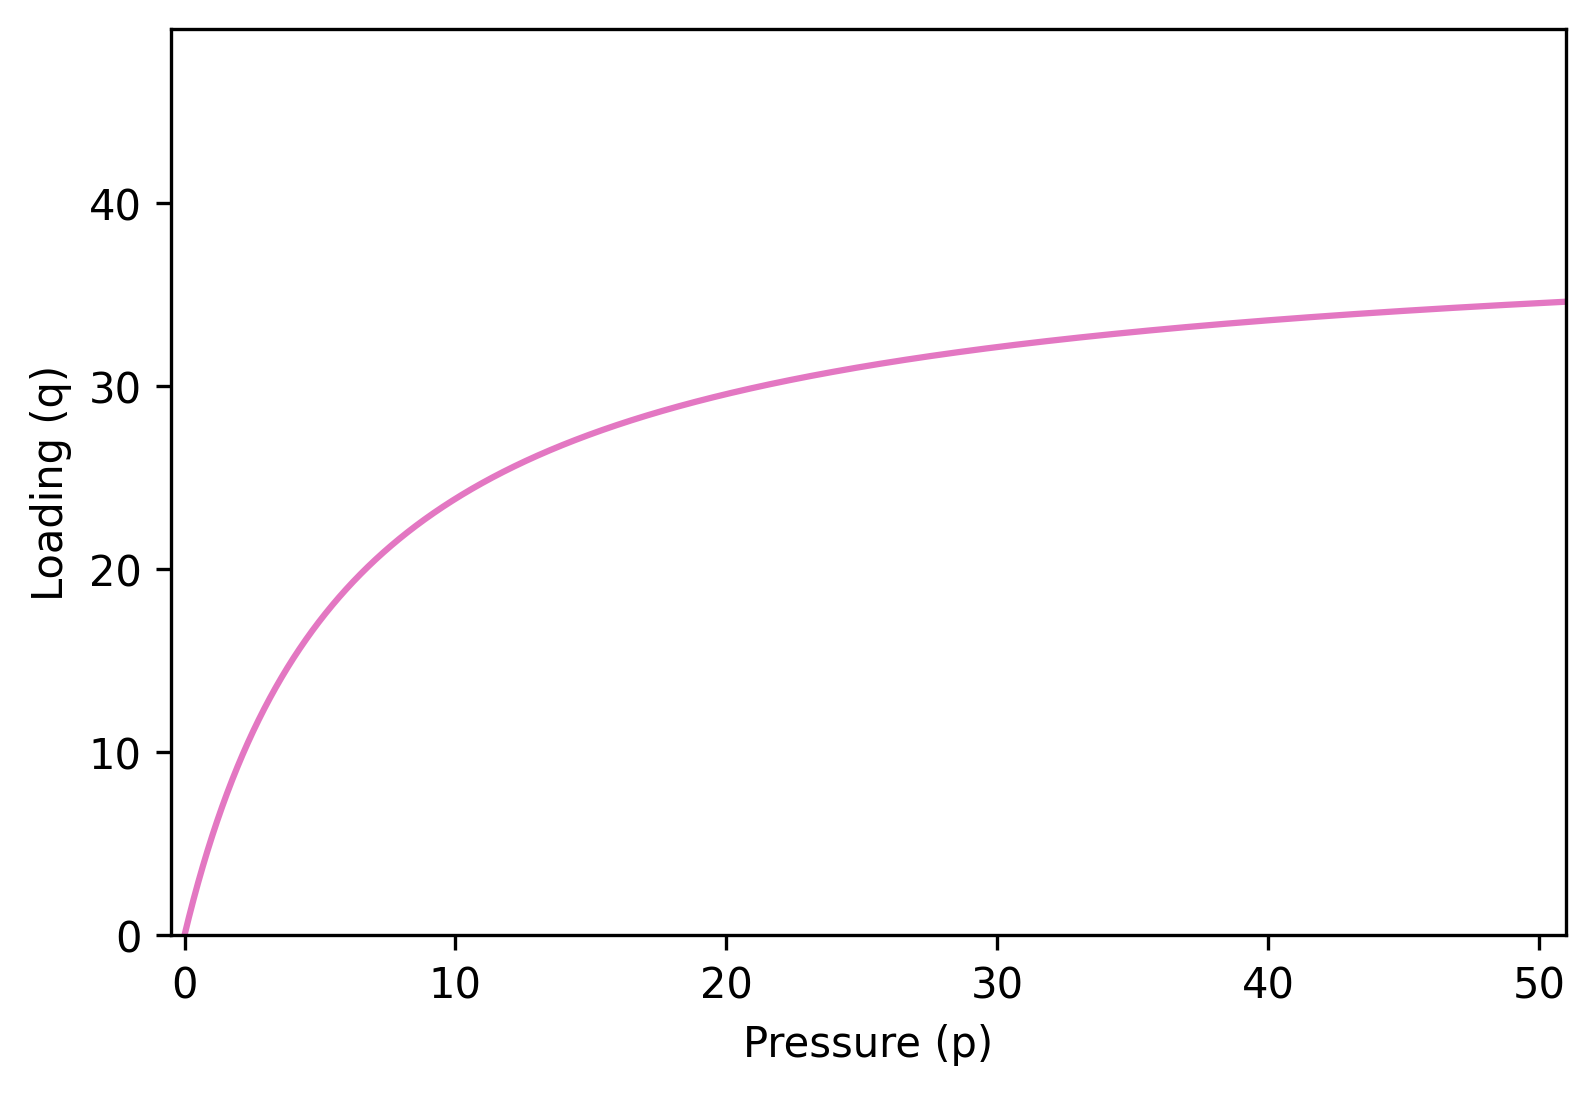

In [19]:
from matplotlib import cm, colors

# read in file
#f = open("adsorptionDatasets/Brunauer1938adsorptionUpdated.csv", "r")
#f = open("adsorptionDatasets/Langmuir1918methane.csv", "r")
f = open("adsorptionDatasets/Langmuir1918nitrogen.csv", "r")
#f = open("adsorptionDatasets/isobutaneFixed.csv", "r")
lines = f.readlines()
# take all rows of csv, remove first line, remove "\n", split into cols by ",", and cast to np array
data = np.array([line.strip().split(",") for line in lines[1:]]).astype(float)
#print(data)

p = data[:,0]
pExt = np.append(p, [0.7, 0.8, 0.9, 1.0])
#pRange = np.linspace(0, 10, num=100000, endpoint=False) 
pRange = np.linspace(1e-3, max(p)*2, 10000)
pRange = np.append(pRange, np.logspace(1, max(p)*1.5, num=100000, endpoint=True)) 
pRange.sort()
q = data[:,1]

# only needed for score not loss
#baseline = np.mean(q) / len(q)
#print(baseline)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

def plotGT(toPlot):
    plt.xlim(-0.5, max(p)*1.5)
    plt.ylim(0, max(q)*1.5)
    #plt.scatter(p, q)

    cmap = cm.turbo
    norm = colors.Normalize(vmin=0, vmax=19)

    if toPlot == "Methane":
        
        """
        1.3, 1.3, 1.3
        ['67.010315', 'c1', 1.0, 1364.0, 0.0, 0.0, 1.0]
        ['(p + 34.46)', 'c1 + p', 3.0, 972.8, 0.0, 1.0, 1.0]
        ['(89.866066 - (194.50156 / p))', '(c1 + c2*p)/p', 5.0, 230.9, 0.0, 0.0, 1.0]
        ['((p * 107.894295) / (p - -8.186922))', 'c1*p/(c2 + p)', 7.0, 14.66, 1.0, 1.0, 1.0]
        ['((((((p + 1.5942043) * 99.42469) - 0.7721129) + p) / (p - -12.703746)) / 0.89177084)', '(c1 + c2*p)/(c3 + p)', 9.0, 3.678, 0.0, 1.0, 0.0]
        """
        
        # other functions
        plt.plot(pRange, np.ones(len(pRange))*67.010315, c=cmap(norm(1)), label="$c_1$")
        comp3 = (pRange+34.46)
        plt.plot(pRange, comp3, c=cmap(norm(3)), label="$c_1 + p$")
        comp5 = (89.866066 - (194.50156 / pRange))
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$(c_1 + c_2*p)/p)$")
        comp7 = ((pRange * 107.894295) / (pRange - -8.186922))
        plt.plot(pRange, comp7, c=cmap(norm(7)), label="$c_1*p/(c_2 + p)$")
        comp9 = ((((((pRange + 1.5942043) * 99.42469) - 0.7721129) + pRange) / (pRange - -12.703746)) / 0.89177084)
        plot9 = plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1 + c_2*p)/(c_3 + p)$")
        

        """
        1.0, 1.0, 1.0
        ['67.00986', 'c1', 1.0, 621.0, 0.0, 0.0, 1.0]
        ['(p + 34.46)', 'c1 + p', 3.0, 442.8, 0.0, 1.0, 1.0]
        ['(89.8651 - (194.49515 / p))', '(c1 + c2*p)/p', 5.0, 105.1, 0.0, 0.0, 1.0]
        ['((-475.20224 / (p + 3.9934394)) + 98.085686)', '(c1*p + c2)/(c3 + p)', 7.0, 29.1, 0.0, 1.0, 1.0]
        ['((1.0442754 - (p / ((p - (-11.788375 + -0.9600125)) * -0.13576217))) * 13.398065)', '(c1 + c2*p)/(c3 + p)', 9.0, 1.674, 0.0, 1.0, 0.0]
        
        
        # other functions
        plt.plot(pRange, np.ones(len(pRange))*67.010315, c=cmap(norm(1)), label="$c_1$")
        comp3 = (pRange+34.46)
        plt.plot(pRange, comp3, c=cmap(norm(3)), label="$p + c_1$")
        comp5 = (89.8651 - (194.49515 / pRange))
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$(c_1 - (c_2/p)$")
        comp7 = ((-475.20224 / (pRange + 3.9934394)) + 98.085686)
        plt.plot(pRange, comp7, c=cmap(norm(7)), label="$(c_1*p + c_2)/(c_3 + p)$")
        comp9 = ((1.0442754 - (pRange / ((pRange - (-11.788375 + -0.9600125)) * -0.13576217))) * 13.398065)
        plot9 = plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1 + c_2*p)/(c_3 + p)$")
        """

        plt.xlim(left=0)

        #colors = cm.turbo(np.linspace(0,1,8))

        # ((p*107.894295)/(p--8.186922))
        #c1, c2 = [107.89315079,   8.1865738]
        c1, c2 = [107.894295, 8.186922]
        langFunc = (c1*p)/(c2+p)
        error = np.mean((langFunc - q) ** 2) #/ baseline
        langFunc = (c1*pRange)/(c2+pRange)
        #plt.plot(pRange, langFunc, c="tab:orange", 
        #    label="Langmuir: (c1*p)/(c2+p) \nc1 = 107.893 \nc2 = 8.186 \nError= " + "{:.5}".format(str(error)))
        #plt.plot(pRange, langFunc, c="tab:pink", label="Ground Truth with loss " + "{:.5}".format(str(error)))

        #plt.plot(pRange, langFunc, c="tab:pink", linestyle="--", label="Ground Truth: \n$\\frac{(c_1*p)}{(c_2+p)}$")
        plt.plot(pRange, langFunc, c="tab:pink", linestyle="--", label="Ground Truth")
        #plt.legend(bbox_to_anchor=(0.1,-0.15), loc="upper left")
        plt.legend(loc="lower right")

    if toPlot == "Nitrogen":

        """
        1.0, 1.0, 1.0
        ['21.772697', 'c1', 1.0, 46.17, 0.0, 0.0, 1.0]
        ['(p + 10.290909)', 'c1 + p', 3.0, 17.04, 0.0, 1.0, 1.0]
        ['((-63.080196 / p) - -31.588856)', '(c1*p + c2)/p', 5.0, 3.383, 0.0, 0.0, 1.0] 
        ['((-164.34094 / (p + 4.247996)) - -35.399704)', '(c1*p + c2)/(c3 + p)', 7.0, 0.6255, 0.0, 1.0, 1.0]
        ['((((183.18263 / p) - 130.52238) / p) + 35.67802)', '(c1 + c2*p + c3*p**2)/p**2', 9.0, 0.3268, 0.0, 0.0, 0.0]
        """
        """
        # other functions
        plt.plot(pRange, np.ones(len(pRange))*21.772697, c=cmap(norm(1)), label="$c_1$")
        comp3 = (pRange+10.290909)
        plt.plot(pRange, comp3, c=cmap(norm(3)), label="$p+c_1$")
        comp5 = ((-63.080196/pRange)+31.588856)
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$(c_1*p + c_2)/p$")
        comp7 = ((-164.34094 / (pRange + 4.247996)) - -35.399704)
        plt.plot(pRange, comp7, c=cmap(norm(7)), label="$(c_1*p + c_2)/(c_3 + p)$")
        comp9 = ((((183.18263 / pRange) - 130.52238) / pRange) + 35.67802)
        plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1 + c_2*p + c_3*p^2)/p^2$")
        """

        """
        1.3, 1.3, 1.3
        ['21.77266', 'c1', 1.0, 101.4, 0.0, 0.0, 1.0]
        ['(p + 10.290909)', 'c1 + p', 3.0, 37.43, 0.0, 1.0, 1.0]
        ['((-63.080196 / p) + 31.588856)', '(c1*p + c2)/p', 5.0, 7.432, 0.0, 0.0, 1.0]
        ['(p / (((((p + 0.716343) - -4.6582813) + 0.9330768) * 0.08110518) / 3.1534908))', 'c1*p/(c2 + p)', 7.0, 0.2694, 1.0, 1.0, 0.0]
        ['((p / ((((p + 6.101006) * 0.10792977) / 4.5070424) * 1.0668372)) + -0.42973024)', '(c1*p + c2)/(c3 + p)', 9.0, 0.2686, 0.0, 1.0, 1.0] 
        """
        """
        # other functions
        plt.plot(pRange, np.ones(len(pRange))*21.77266, c=cmap(norm(1)), label="$c_1$")
        comp3 = (pRange+10.290909)
        plt.plot(pRange, comp3, c=cmap(norm(3)), label="$p+c_1$")
        comp5 = ((-63.080196/pRange)+31.588856)
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$(c_1*p + c_2)/p$")
        comp7 = (pRange / (((((pRange + 0.716343) - -4.6582813) + 0.9330768) * 0.08110518) / 3.1534908))
        plt.plot(pRange, comp7, c=cmap(norm(7)), label="$c_1*p/(c_2 + p)$")
        comp9 = ((pRange / ((((pRange + 6.101006) * 0.10792977) / 4.5070424) * 1.0668372)) + -0.42973024)
        plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1*p + c_2)/(c_3 + p)$")
        """

        c1, c2 = [38.89357691,  6.31337534]
        langFunc = (c1*p)/(c2+p)
        error = np.mean((langFunc - q) ** 2) #/ baseline
        langFunc = (c1*pRange)/(c2+pRange)


        #plt.plot(pRange, langFunc, c="tab:orange", linestyle="dotted",
        #    label="Langmuir: (c1*p)/(c2+p) \nc1 = 38.893 \nc2 = 6.313 \nError= " + "{:.5}".format(str(error)))
        #plt.plot(pRange, langFunc, c="tab:pink", linestyle="--", label="Ground Truth: \n$\\frac{(c_1*p)}{(c_2+p)}$")
        #plt.plot(pRange, langFunc, c="tab:pink", linestyle="--", label="Ground Truth")
        plt.plot(pRange, langFunc, c="tab:pink")

        #plt.xlim(left=0)
        #plt.legend(loc="lower right")
        #plt.xticks([])
        #plt.yticks([])

    # BET
    if toPlot == "BET":
        """
        1.0, 1.0, 1.0
        ['169.9747', 'c1', 1.0, 4221.0, 0.0, 0.0, 1.0]
        ['(p * 535.9959)', 'c1*p', 3.0, 4088.0, 1.0, 1.0, 1.0]
        ['((p * 307.25095) - -96.05276)', 'c1 + c2*p', 5.0, 148.4, 0.0, 1.0, 1.0]
        ['((p * (307.25095 - p)) - -96.05276)', 'c1 + p*(c2 - p)', 7.0, 148.3, 0.0, 1.0, 0.0]
        ['((p * 279.0123) - (-108.42053 - (-0.12272537 / p)))', '(c1*p + c2 + c3*p**2)/p', 9.0, 21.29, 0.0, 0.0, 1.0]
        ['((((p * 285.67682) - (-106.73384 - ((-0.00030704399 / (p * p)) + p))) - 1.5639596) - p)', 'c1 + c2*p**c3 + c4*p', 11.0, 19.64, 0.0, 0.0, 1.0]
        ['((((p + 0.41215456) * (16.018183 + p)) / 0.06039906) - (0.12468025 / p))', '(c1*p + c2*p**2 + c3 + c4*p**3)/p', 13.0, 18.45, 0.0, 0.0, 1.0]
        ['(((p * (((p - -0.015705872) * 127.45212) + 194.45856)) - (0.14746547 / p)) - -116.529274)', '(c1*p**2 + c2*p + c3 + c4*p**3)/p', 15.0, 4.854, 0.0, 0.0, 1.0]
        
        
        plt.plot(pRange, np.ones(len(pRange))*169.9747, c=cmap(norm(1)), label="c1")
        comp3 = (pRange * 535.9959)
        plt.plot(pRange, comp3, c=cmap(norm(3)), label="$c_1*p$")
        comp5 = ((pRange * 307.25095) - -96.05276)
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$c_1 + c_2*p$")
        comp7 = ((pRange * (307.25095 - pRange)) + 96.05276)
        #plt.plot(pRange, comp7, c=cmap(norm(7)), label="$c_1 + p*(c_2 - p)$")
        comp9 = ((pRange * 279.0123) - (-108.42053 - (-0.12272537 / pRange))) 
        #plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1*p + c_2 + c_3*p^2)/p$")
        comp11 = ((((pRange * 285.67682) - (-106.73384 - ((-0.00030704399 / (pRange * pRange)) + pRange))) - 1.5639596) - pRange)
        #plt.plot(pRange, comp11, c=cmap(norm(11)), label="$c_1 + c_2*p^3 + c_3*p$")
        comp13 = ((((pRange + 0.41215456) * (16.018183 + pRange)) / 0.06039906) - (0.12468025 / pRange))
        plt.plot(pRange, comp13, c=cmap(norm(13)), label="$(c_1*p + c_2*p^2 + c_3 + c_4*p^3)/p$")
        comp15 = (((pRange * (((pRange - -0.015705872) * 127.45212) + 194.45856)) - (0.14746547 / pRange)) - -116.529274)
        #plt.plot(pRange, comp15, c=cmap(norm(15)), label="$(c_1*p^2 + c_2*p + c_3 + c_4*p^3)/p$")
        

        
        1.3, 1.3, 1.3
        ['169.97484', 'c1', 1.0, 9274.0, 0.0, 0.0, 1.0]
        ['(p - (p * -534.99817))', 'c1*p', 3.0, 8982.0, 1.0, 1.0, 1.0]  
        ['((p * 307.25095) - (0.058867164 - 96.05264))', 'c1*p + c2', 5.0, 326.1, 0.0, 1.0, 1.0]
        ['((p * (307.25095 - p)) + 96.05276)', 'c1 + p*(c2 - p)', 7.0, 325.8, 0.0, 1.0, 0.0]
        ['(((p * 279.01233) - (0.122725345 / p)) + 108.420525)', '(c1*p**2 + c2 + c3*p)/p', 9.0, 46.78, 0.0, 0.0, 1.0]
        ['(((p * 285.6767) - ((0.0003070427 / p) / p)) - -105.16986)', 'c1*p + c2*p**c3 + c4', 11.0, 43.16, 0.0, 0.0, 1.0]
        ['(((p * ((p * 126.497086) + 196.6921)) + 116.518394) - (0.1474349 / p))', '(c1*p**3 + c2*p + c3 + c4*p**2)/p', 13.0, 10.68, 0.0, 0.0, 1.0]
        """

        
        plt.plot(pRange, np.ones(len(pRange))*169.97484, c=cmap(norm(1)), label="$c_1$")
        comp3 = (pRange - (pRange * -534.99817))
        plt.plot(pRange, comp3, c=cmap(norm(3)), label="$c_1*p$")
        comp5 = ((pRange * 307.25095) - (0.058867164 - 96.05264))
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$c_1*p + c_2$")
        comp7 = ((pRange * (307.25095 - pRange)) + 96.05276)
        #plt.plot(pRange, comp7, c=cmap(norm(7)), label="$c_1 + p*(c_2 - p)$")
        comp9 = (((pRange * 279.01233) - (0.122725345 / pRange)) + 108.420525) 
        plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1*p^2 + c_2 + c_3*p)/p$")
        comp11 = (((pRange * 285.6767) - ((0.0003070427 / pRange) / pRange)) - -105.16986)
        #plt.plot(pRange, comp11, c=cmap(norm(11)), label="$c_1*p + c_2*p^3 + c_4$")
        comp13 = (((pRange * ((pRange * 126.497086) + 196.6921)) + 116.518394) - (0.1474349 / pRange))
        plt.plot(pRange, comp13, c=cmap(norm(13)), label="$(c_1*p^3 + c_2*p + c_3 + c_4*p^2)/p$")
        

        """
        1.3, 1.3, 1.0
        ['169.97498', 'c1', 1.0, 7134.0, 0.0, 0.0, 1.0]
        ['(p * 535.9959)', 'c1*p', 3.0, 6909.0, 1.0, 1.0, 1.0]
        ['((((((-1.7566684 - ((p + -0.36406073) + p)) - p) * -4.567499) + -1.7744505) + p) / 0.04779827)', 'c1*p + c2', 5.0, 250.9, 0.0, 1.0, 1.0]
        ['((p + 0.3115418) * (308.16837 - p))', '(c1 - p)*(c2 + p)', 7.0, 250.6, 0.0, 1.0, 0.0]
        ['(((p * 279.01233) - (0.12272541 / p)) + 108.42055)', '(c1*p**2 + c2 + c3*p)/p', 9.0, 35.98, 0.0, 0.0, 1.0]
        ['(((p * 285.67703) + 105.17007) + ((-0.00030704812 / p) / p))', 'c1*p + c2*p**c3 + c4', 11.0, 33.2, 0.0, 0.0, 1.0]
        ['(((p * ((p * 116.52975) + 196.459)) - (0.14746696 / p)) + 116.52975)', '(c1*p**3 + c2*p + c3*p**2 + c4)/p', 13.0, 13.69, 0.0, 0.0, 1.0]
        """
        
        """
        plt.plot(pRange, np.ones(len(pRange))*169.97498, c=cmap(norm(1)), label="$c_1$")
        comp3 = (pRange * 535.9959)
        plt.plot(pRange, comp3, c=cmap(norm(3)), label="$c_1*p$")
        comp5 = ((((((-1.7566684 - ((pRange + -0.36406073) + pRange)) - pRange) * -4.567499) + -1.7744505) + pRange) / 0.04779827)
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$c_1*p + c_2$")
        comp7 = ((pRange + 0.3115418) * (308.16837 - pRange))
        plt.plot(pRange, comp7, c=cmap(norm(7)), label="$(c_1 - p)*(c_2 + p)$")
        comp9 = (((pRange * 279.01233) - (0.12272541 / pRange)) + 108.42055)
        plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1*p^2 + c_2 + c_3*p)/p$")
        comp11 = (((pRange * 285.67703) + 105.17007) + ((-0.00030704812 / pRange) / pRange))
        plt.plot(pRange, comp11, c=cmap(norm(11)), label="$c_1*p + c_2*p^3 + c_4$")
        comp13 = (((pRange * ((pRange * 116.52975) + 196.459)) - (0.14746696 / pRange)) + 116.52975)
        plt.plot(pRange, comp13, c=cmap(norm(13)), label="$(c_1*p^3 + c_2*p + c_3*p^2 + c_4)/p$")
        """
        

        #c1, c2, c3 =[4.25731775e+04, 1.14842307e+00, 3.15500928e+02]
        
        # full GT fits too well
        #BETFunc = (c1*p/c2) / ((1-p/c2) * (1-p/c2 + c3*(p/c2)))
        # fails to fit
        #BETFunc = (c1*p/(c2 + c1*p + p**2))
        # different form fits well enough and goes to 
        
        # previous
        #c1, c2 = [119.97509499, 450.01805216]
        #BETFunc = (c1*c2*p/(1-p)/(1 - p + c2*p))       

        # p0 held constant
        c1, c3 = [53990.95892544,   450.01805526]
        c2 = 1
        BETFunc = ((c1*p/c2) / ((1-p/c2) * (1-p/c2 + c3*(p/c2))))

        plt.xlim(left=0, right=1)

        error = np.mean((BETFunc - q) ** 2)
        print("error:", error)
        BETFunc = (c1*pRange/c2) / ((1-pRange/c2) * (1-pRange/c2 + c3*(pRange/c2)))
        #BETFunc = (c1*pRange/(c2 + c1*pRange + pRange**2))
        #BETFunc = (c1*c2*pRange/(1-pRange)/(1 - pRange + c2*pRange))
        plt.plot(pRange, BETFunc, c="tab:pink", linestyle="--", label="Ground Truth")#, 
            #label="Ground Truth") # "BET: \nError= " + "{:.5}".format(str(error)))
        #plt.plot(pRange, BETFunc, c="tab:pink", linestyle="--", label="Ground Truth: \n$\\frac{(c_1*p/p_0)} {((1-p/p_0) * (1-p/p_0 + c_3*(p/p_0)))}$")
        plt.legend(loc="lower right")
        #plt.legend()
        #plt.xscale("symlog")

    if toPlot == "Isobutane":
        c1,c2,c3,c4 = [0.93638408, 8.88131119, 0.80450864, 0.01028873]
        isoFunc = ((c1*p)/(c2+p) + (c3*p)/(c4+p))
        #plt.plot(p, isoFunc)

        #((-7.240145 / (p + 7.484003)) + 1.7240608)', '(c1*p + c2)/(c3 + p)', 7.0, 0.002592, 0.0, 1.0, 1.0]
        #['((p / ((p / 0.96739817) + 7.7339783)) - -0.75661993)', '(c1*p + c2)/(c3 + p)', 9.0, 0.002592, 0.0, 1.0, 1.0]

        """
        1.0, 1.0, 1.0
        ['1.1547647', 'c1', 1.0, 0.1197, 0.0, 0.0, 1.0]
        ['((p * 0.010986225) + (1.0037444 / 1.0589656))', 'c1 + c2*p', 5.0, 0.03419, 0.0, 1.0, 1.0]
        ['((-7.2344437 / (p - -7.4787936)) - -1.7239301)', '(c1*p + c2)/(c3 + p)', 7.0, 0.00118, 0.0, 1.0, 1.0]
        ['(((p - -1.3888605) / ((p + 7.466158) / 1.1882207)) - -0.53544086)', '(c1 + c2*p)/(c3 + p)', 9.0, 0.00118, 0.0, 1.0, 0.0]
        ['(((-7.3059974 - (0.029853972 / p)) / (p + 7.6158576)) + 1.7255307)', '(c1*p**2 + c2*p + c3)/(c4*p + p**2)', 11.0, 0.0009415, 0.0, 0.0, 1.0]
        ['((((-8.361098 / (p + 8.915768)) + 0.6592366) + (-0.007428845 / p)) - -1.082547)', '(c1*p + c2 + c3*p**2)/(c4*p + p**2)', 13.0, 0.0007865, 0.0, 0.0, 1.0]
        ['(((p + 0.13217528) / (((-1.2132629 / (3.0709474 - p)) - -7.7781525) + p)) + 0.7406042)', '(c1*p**2 + c2 + c3*p)/(c4*p + c5 + p**2)', 15.0, 0.0007365, 0.0, 1.0, 0.0]
        
        
        # other functions
        plt.plot(pRange, np.ones(len(pRange))*1.1547647, c=cmap(norm(1)), label="$c_1$")
        comp5 = ((pRange * 0.010986225) + (1.0037444 / 1.0589656))
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$c_1+c_2*p$")
        comp7 = ((-7.2344437 / (pRange - -7.4787936)) - -1.7239301)
        plt.plot(pRange, comp7, c=cmap(norm(7)), label="$(c_1*p + c_2)/(c_3 + p)$")
        comp9 = (((pRange - -1.3888605) / ((pRange + 7.466158) / 1.1882207)) - -0.53544086)
        #plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1*p + c_2)/(c_3 + p)$")
        comp11 = (((-7.3059974 - (0.029853972 / pRange)) / (pRange + 7.6158576)) + 1.7255307)
        #plt.plot(pRange, comp11, c=cmap(norm(11)), label="$(c_1*p^2 + c_2*p + c_3)/(c_4*p + p^2)$") 
        comp13 = ((((-8.361098 / (pRange + 8.915768)) + 0.6592366) + (-0.007428845 / pRange)) - -1.082547)
        #plt.plot(pRange, comp13, c=cmap(norm(13)), label="$(c_1*p + c_2 + c_3*p^2)/(c_4*p + p^2)$") 
        comp15 =(((pRange + 0.13217528) / (((-1.2132629 / (3.0709474 - pRange)) - -7.7781525) + pRange)) + 0.7406042)
        plt.plot(pRange, comp15, c=cmap(norm(15)), label="$(c_1*p^2 + c_2 + c_3*p)/(c_4*p + c_5 + p^2)$")
        
        
        1.3, 1.3, 1.3
        ['1.1547647', 'c1', 1.0, 0.263, 0.0, 0.0, 1.0]
        ['(0.9456003 - (p * -0.01098571))', 'c1 + c2*p', 5.0, 0.07511, 0.0, 1.0, 1.0]
        ['((-7.240145 / (p + 7.484003)) + 1.7240608)', '(c1*p + c2)/(c3 + p)', 7.0, 0.002592, 0.0, 1.0, 1.0]
        ['((((p - -0.24368565) / ((p + 0.3979257) - -7.0875974)) + 0.6899385) - -0.03416266)', '(c1 + c2*p)/(c3 + p)', 9.0, 0.002592, 0.0, 1.0, 0.0]
        ['((p / ((-0.652148 / p) - (-8.149457 - p))) + 0.75102735)', '(c1*p + c2*p**2 + c3)/(c4*p + c5 + p**2)', 11.0, 0.002197, 0.0, 0.0, 1.0]
        ['((p / ((p / 0.9935113) + (8.265445 + (-0.65055764 / p)))) + 0.75176954)', '(c1*p**2 + c2 + c3*p)/(c4*p + c5 + p**2)', 13.0, 0.002158, 0.0, 0.0, 0.0]
        ['(1.7243158 - (7.1236196 / ((p + (1.7216936 / (7.1236196 + (p / -0.41244307)))) + 7.1236196)))', '(c1*p**2 + c2 + c3*p)/(c4 + c5*p + p**2)', 15.0, 0.001365, 0.0, 1.0, 0.0]
        """
        
        # other functions
        plt.plot(pRange, np.ones(len(pRange))*1.1547647, c=cmap(norm(1)), label="$c_1$")
        comp5 = (0.9456003 - (pRange * -0.01098571))
        plt.plot(pRange, comp5, c=cmap(norm(5)), label="$c_1+c_2*p$")
        comp7 = ((-7.240145 / (pRange + 7.484003)) + 1.7240608)
        plt.plot(pRange, comp7, c=cmap(norm(7)), label="$(c_1*p + c_2)/(c_3 + p)$")
        comp9 = ((((pRange - -0.24368565) / ((pRange + 0.3979257) - -7.0875974)) + 0.6899385) - -0.03416266)
        #plt.plot(pRange, comp9, c=cmap(norm(9)), label="$(c_1*p + c_2)/(c_3 + p)$")
        comp11 = ((pRange / ((-0.652148 / pRange) - (-8.149457 - pRange))) + 0.75102735)
        #plt.plot(pRange, comp11, c=cmap(norm(11)), label="$(c_1*p + c_2*p^2 + c_3)/(c_4*p + c_5 + p^2)$") 
        comp13 = ((pRange / ((pRange / 0.9935113) + (8.265445 + (-0.65055764 / pRange)))) + 0.75176954)
        #plt.plot(pRange, comp13, c=cmap(norm(13)), label="$(c_1*p^2 + c_2 + c_3*p)/(c_4*p + c_5 + p^2)$") 
        comp15 =(1.7243158 - (7.1236196 / ((pRange + (1.7216936 / (7.1236196 + (pRange / -0.41244307)))) + 7.1236196)))
        plt.plot(pRange, comp15, c=cmap(norm(15)), label="$(c_1*p^2 + c_2 + c_3*p)/(c_4 + c_5*p + p^2)$")
        

        error = np.mean((isoFunc - q) ** 2) #/ baseline
        print("error:", error)
        isoFunc = ((c1*pRange)/(c2+pRange) + (c3*pRange)/(c4+pRange))
        #plt.plot(pRange, isoFunc, c="tab:orange", 
        #    label="Dual-Site Langmuir: (c1*p)/(c2+p) + (c3*p)/(c4+p) \nc1=0.93638408 \nc2=8.88131119 \nc3=0.80450864 \nc4=0.0102887313 \nError= " + "{:e}".format(error))
        plt.plot(pRange, isoFunc, c="tab:pink", linestyle="--", label="Ground Truth")
        #plt.plot(pRange, isoFunc, c="tab:pink", linestyle="--", label="Ground Truth: \n$\\frac{c_1 * p} {(c_2 + p)} + \\frac{c_3 * p} {(c_4 + p)}$")
        #plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
        plt.legend()
        #plt.xscale("symlog")
        plt.xscale("log")
        plt.xlim(left=1e-2)
        #plt.xticks([1e-3, 1e-2, 1e-1, 1, 10, 100])

    plt.xlabel("Pressure (p)")
    plt.ylabel("Loading (q)")
    #plt.title(toPlot + " Ground Truth")
    #plt.title("Isobutane [1.3, 1.3, 1.3]")
    #plt.title("BET Ground Truth")

#plt.grid()
#plotGT("Methane")
plotGT("Nitrogen")
#plotGT("BET")
#plotGT("Isobutane")
plt.show()


In [30]:
# BMS stuff...
from os import listdir
import re

def parseBMS(file):
    bmsData = pd.read_csv(file)
    print(bmsData.columns)
    bmsData["loss"] = bmsData["SSE"]
    bmsData["complexity"] = bmsData["Total num ops"] * 2 + 1
    bmsData["equation"] = [expr.replace("_a0_", str(a0)).replace("_a1_", str(a1)).replace("_a2_", str(a2)) for expr, a0, a1, a2 in bmsData[["Canonical form", "_a0_", "_a1_", "_a2_"]].to_numpy()]
    bmsData = addCanonical(bmsData)
    bmsData = removeRepeats(bmsData)
    bmsData = addThermoVals(bmsData)
    print(bmsData.columns)
    return bmsData

dir = "BMSDataRaw"
files = listdir(dir)
for i, file in enumerate(files):
    if "All_Models" in str(file):
        print("loading", str(file))

        run = parseBMS(dir+"/"+str(file))
        print(run)
        run.to_csv(file+".csv")

loading All_ModelsBETTrue1.txt
Index(['Model', 'Canonical form', 'Total num ops', 'Description length', 'EB',
       'EP', 'SSE', 'TC Bool', 'Axiom', '_a0_', '_a1_', '_a2_'],
      dtype='object')
10000 -> 46
there are 46 expressions to check in this run
Oops! <class 'mpmath.libmp.libhyper.NoConvergence'> occurred for -p + 116.5009969848931*(0.9169541441044968*p + p/(p + 0.0009685215049414))**2
Oops! <class 'mpmath.libmp.libhyper.NoConvergence'> occurred for p + 119.6962570735207*(0.394856100961582*p + 1)**2*(0.394856100961582*p + p/(p + 0.00104195576041073))**2
Oops! <class 'mpmath.libmp.libhyper.NoConvergence'> occurred for p + 119.2447204701961*(0.8049129144203551*p + p/(p + 0.0008376518792016286/(p + 0.8049129144203551)))**2*(0.0915757364780836*p**2 + 1)**2
Oops! <class 'mpmath.libmp.libhyper.NoConvergence'> occurred for p + 122.326280768973*(0.3006907422372119*p + p/(p + 0.0011069156232367))**2*(0.1206563536720651*p*(p + 3.325676050282619) + 1)**2
Oops! <class 'mpmath.libmp.libhyp

In [1390]:
#print(result[result["canonEquation"] == "c1*p/(c2 + p)"])
print(result[result["canonComplexity"] == 17])

Empty DataFrame
Columns: [Model, Canonical form, Total num ops, Description length, EB, EP, SSE, TC Bool, Axiom, _a0_, _a1_, _a2_, loss, equation, canonEquation, parameters, canonComplexity, simplified]
Index: []


In [1367]:
# THIS IMPORTS A FOLDER OF DATAFRAMES

from os import listdir

# load all datasets / runs in a directory
#dir = "fullTestParsed/final"
#dir = "TCfinal"
dir = "CrossFinal"
files = listdir(dir)
experiment = {}
for i, file in enumerate(files):
    print("loading", str(file))
    # for TC methane check
    #params = str(file).split("methane")[1][:9]
    
    # for others
    params = str(file).split("-")[1:3]
    params[1] = params[1][:9]
    params = "-".join(params)
    print(params)
    thisData = pd.read_csv(dir+"/"+str(file), index_col=0)
    runs = []
    numRuns = int(max(thisData["run"]))+1
    for i in range(numRuns):
        thisRun = thisData.loc[thisData["run"] == i]
        runs.append(thisRun)
        print("run", i, "length =", len(thisRun))
    experiment[params] = runs

print(experiment.keys())

loading PySRDataRaw-Langmuir1918methane-cross0.05final.csv
Langmuir1918methane-cross0.05
run 0 length = 11
run 1 length = 15
run 2 length = 14
run 3 length = 24
run 4 length = 9
run 5 length = 20
run 6 length = 19
run 7 length = 16
loading PySRDataRaw-Langmuir1918methane-cross0.0final.csv
Langmuir1918methane-cross0.0f
run 0 length = 22
run 1 length = 13
run 2 length = 18
run 3 length = 19
run 4 length = 16
run 5 length = 20
run 6 length = 13
run 7 length = 14
loading PySRDataRaw-Langmuir1918methane-cross0.1final.csv
Langmuir1918methane-cross0.1f
run 0 length = 18
run 1 length = 21
run 2 length = 22
run 3 length = 19
run 4 length = 15
run 5 length = 18
run 6 length = 18
run 7 length = 15
loading PySRDataRaw-Langmuir1918methane-cross0.2final.csv
Langmuir1918methane-cross0.2f
run 0 length = 26
run 1 length = 24
run 2 length = 17
run 3 length = 16
run 4 length = 17
run 5 length = 14
run 6 length = 14
run 7 length = 17
loading PySRDataRaw-Langmuir1918methane-cross0.3final.csv
Langmuir1918me

In [1368]:
#print(len(experiment["Brunauer1938-1.01.01.0"]))

maxLoss = 0
minLoss = 1e12
for key, value in experiment.items():
    if "methane" in key:
        thisMax = max([max(value[i]["loss"]) for i in range(len(value))])
        if thisMax > maxLoss:
            maxLoss = thisMax
        thisMin = min([min(value[i]["loss"]) for i in range(len(value))])
        if thisMin < minLoss:
            minLoss = thisMin

print(maxLoss)
print(minLoss)

1630.0
0.6855


In [1369]:
def undoThermo(x, penalty):
    #print(x)
    loss, thermo = x
    #print(loss, thermo, penalty)
    if thermo:
        return loss * (1/float(penalty))
    else:
        return loss

def testFunc(x):
    print(x)

# calculate error before it was multiplied by thermo constraints
for key, value in experiment.items():
    print(key)
    split = key.split(".")
    paramsList = [split[0][-1]+"."+split[1][0], split[1][1]+"."+split[2][0], split[2][1]+"."+split[3][0]]
    #print(paramsList)

    for run in value:
        #run["error"] = run.apply(lambda x: testFunc(x))
        #print(run.columns)
        # t1
        run["error"] = run[["loss", "thermo1"]].apply(lambda x: undoThermo(x, paramsList[0]), axis=1)
        # t2
        run["error"] = run[["error", "thermo2"]].apply(lambda x: undoThermo(x, paramsList[1]), axis=1)
        # t3
        run["error"] = run[["error", "thermo3"]].apply(lambda x: undoThermo(x, paramsList[2]), axis=1)

Langmuir1918methane-cross0.05


IndexError: list index out of range

In [1370]:
# find all of a given canonical form in experiment

for key, value in experiment.items():
    print(key)
    found = pd.DataFrame([])
    for run in value:
        # langmuir
        found = found.append(run[run["canonEquation"] == "c1*p/(c2 + p)"])
        #found = found.append(run[run["canonEquation"] == "(c1*p + c2)/(c3 + p)"])
        # BET
        #found = found.append(run[run["canonEquation"] == "c1*p/(c2*p + c3 + p**2)"])
        #found = found.append(run[run["canonEquation"] == "c1*p + c2*p**c3 + c4"])
        # dual site
        #found = found.append(run[run["canonEquation"] == "(c1*p**2 + c2*p)/(c3*p + c4 + p**2)"])
        #found = found.append(run[run["canonEquation"] == "(c1*p/(c2 + p) + c3*p/(c4 + p)"]) # not what canonical form produces
    if not found.empty:
        print(found)
        print()

Langmuir1918methane-cross0.05
       run  progress  runtime  complexity   loss   score  \
22606  7.0     273.0    0.007        13.0  6.675  0.2753   

                                                                            equation  \
22606  ((96.32335 / ((((p + 7.795504) * 1.7271764) - -0.64742225) / p)) * 1.9335419)   

       canonEquation          parameters  canonComplexity  \
22606  c1*p/(c2 + p)  ['c0', 'c1', 'c2']              7.0   

                                          simplified  minComplexity  thermo1  \
22606  107.832201258288*p/(1.0*p + 8.17034831237018)            7.0     True   

       thermo2  thermo3  
22606     True     True  

Langmuir1918methane-cross0.0f
       run  progress  runtime  complexity   loss    score  \
568    0.0      78.0    0.008         7.0  6.675  1.37800   
6221   2.0      81.0    0.012        11.0  6.687  0.09173   
12567  4.0     182.0    0.008         9.0  6.675  1.36000   

                                                            

In [303]:
print(list(experiment.values())[5][0].head())

     run  progress  runtime  complexity      loss     score  \
0    0.0       2.0    0.098         1.0  0.263000 -0.787100   
141  0.0      31.0    0.824         9.0  0.002775  0.008431   
7    0.0       4.0    0.184        13.0  0.107700  0.217400   
8    0.0       4.0    0.184        15.0  0.095860  0.058080   
9    0.0       4.0    0.184        17.0  0.092840  0.016010   

                                              equation  \
0                                            1.1547647   
141  ((p / ((p / 0.9769688) + 7.0674496)) + 0.7480005)   
7    ((p * 1.3376335) / (((p / (p + p)) + p) - 0.34...   
8    ((p * 1.3280348) / ((((p - 0.011235976) / (p +...   
9    ((p * 1.3376335) / ((((p / ((p + 0.045351073) ...   

                           canonEquation                parameters  \
0                                     c1                    ['c0']   
141                 (c1*p + c2)/(c3 + p)        ['c0', 'c1', 'c2']   
7                          c1*p/(c2 + p)              ['c0', '

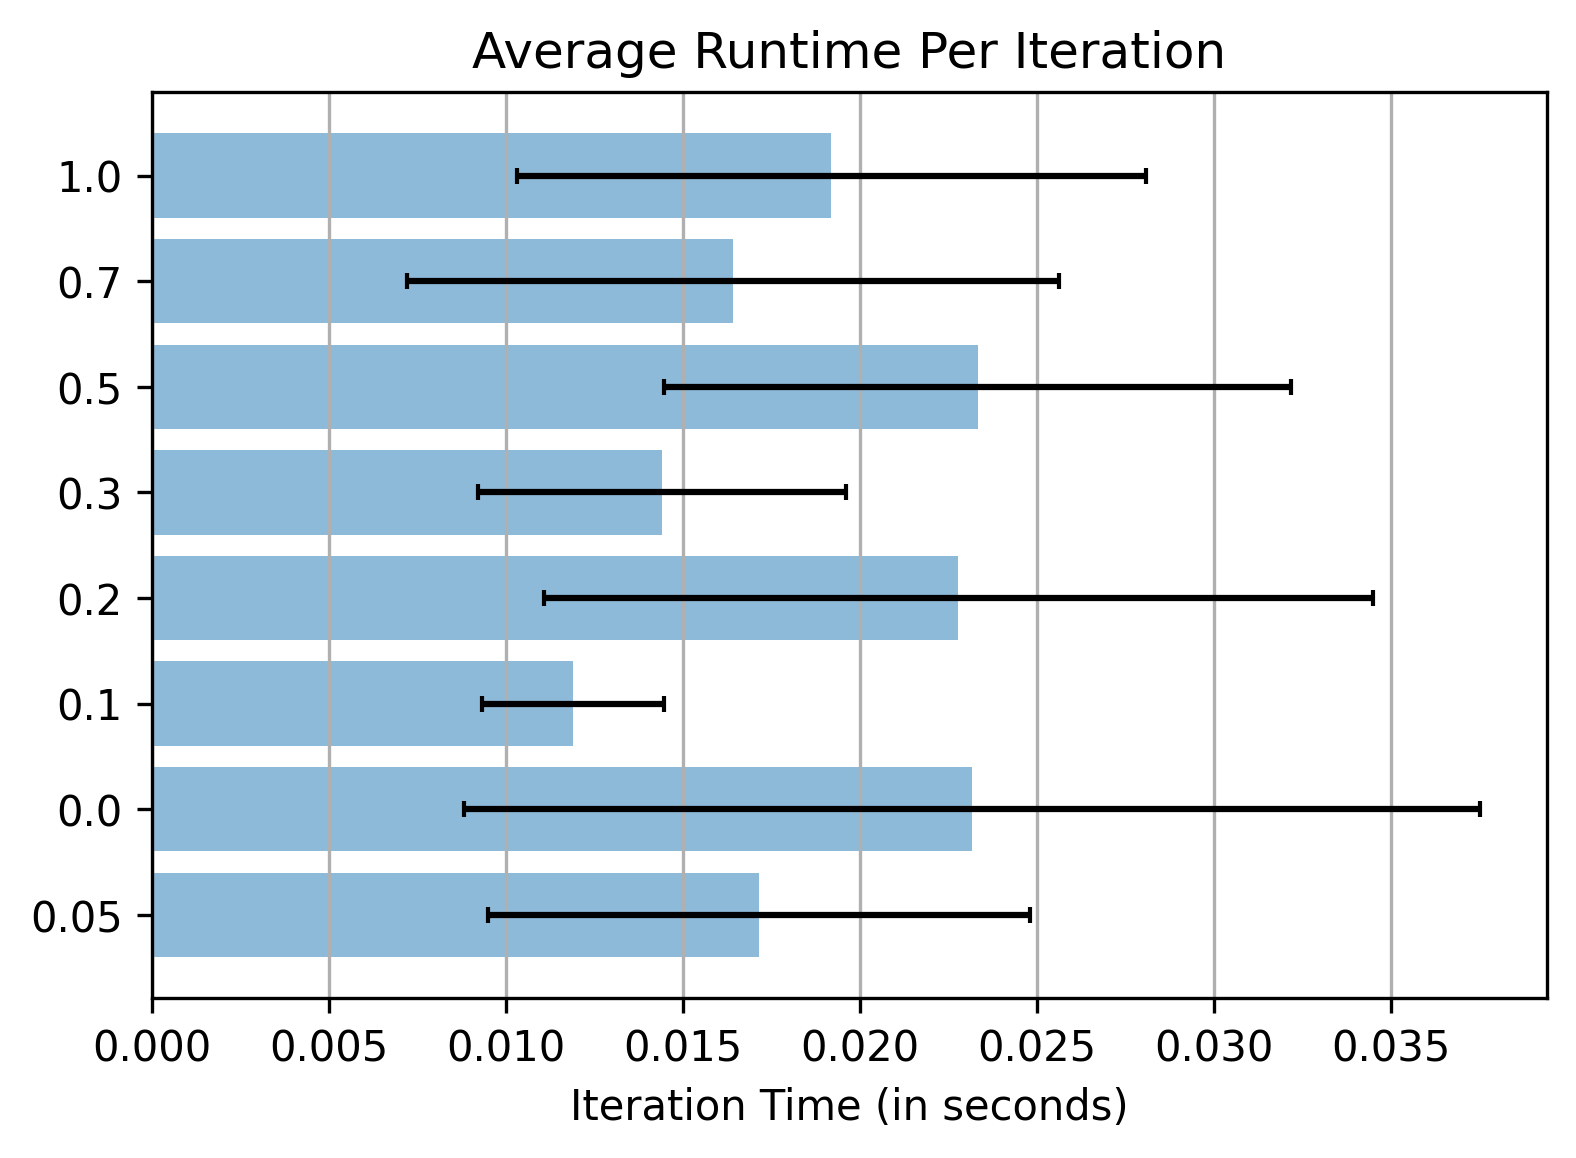

In [1374]:
avgRuntime = {}
for key, val in experiment.items():
    # runtime is in parsed (not final) form...
    #runtime = val["time"]
    runtimes = []
    for run in val:
        runtimes.append(run["runtime"].mean())
    avgRuntime[key] = runtimes

#print(avgRuntime)

#fig = plt.figure(figsize= (10,7))
#ax = fig.add_axes

data = [i for i in list(avgRuntime.values())]
#data.sort(key=lambda x: np.mean(x))
#for row in data:
#    print(np.mean(row))
avgs = [np.mean(d) for d in data]
stdivs = [np.std(d) for d in data]
xs = np.arange(len(data))
fig, ax = plt.subplots()
barList = ax.barh(xs, avgs, xerr=stdivs, capsize=2, alpha=0.5)

#barList[0].set_color("tab:orange")
#barList[4].set_color("tab:orange")
#barList[7].set_color("tab:orange")
#barList[10].set_color("tab:orange")

labels = list(avgRuntime.keys())
labels = [l.replace("Langmuir1918nitrogen", "Nitrogen") for l in labels]
labels = [l.replace("Langmuir1918methane", "Methane") for l in labels]
labels = [l.replace("isobutaneT277Fixed", "Isobutane") for l in labels]
labels = [l.replace("Brunauer1938", "BET") for l in labels]
labels = [l.replace("-1.31.31.3", " [1.3, 1.3, 1.3]") for l in labels]
labels = [l.replace("-1.11.11.3", " [1.1, 1.1, 1.3]") for l in labels]
labels = [l.replace("-1.01.01.0", " [1.0, 1.0, 1.0]") for l in labels]
labels = [l.replace("-1.31.31.0", " [1.3, 1.3, 1.0]") for l in labels]
labels = [l.replace("f", "") for l in labels]
labels = [l.replace("Methane-cross", "") for l in labels]

ax.set_yticks(xs)
ax.set_yticklabels(labels)
ax.xaxis.grid(True)

ax.set_xlabel("Iteration Time (in seconds)")
ax.set_ylabel("Crossover Probability")

#ax.get_yticklabels()[3].set_color("tab:orange")

#for key, val in avgRuntime.items():
#    #if ("1.01.01.0") not in key:
#    if True:
#        val.sort()
#        print(val)
#        plt.boxplot(val)
#    #plt.scatter(list(range(0, len(val))), val, label=key)
#plt.xscale("log")
#plt.legend(bbox_to_anchor=(1.65, 1))
#ax.set_xticklabels(list(avgRuntime.keys()), rotation = 90, size=10)
#ax.set_ylabel("Average Runtimes")
plt.title("Average Runtime Per Iteration")
#plt.grid()
plt.show()

In [25]:
# read in saved data
data = pd.read_csv("testDiparsed/t1final.csv", index_col=0)

print(data.columns)
print(len(data))

# count number of runs (+1 cause start from 0)
numRuns = int(data["run"].max() + 1)
# separate runs for ease of plotting
runs = []
for i in range(numRuns):
    thisRun = data.loc[data["run"] == i]
    runs.append(thisRun)
    print("run", i, "length =", len(thisRun))

#print(runs[0].isnull().sum().sum())
print(runs[0].head(3))

Index(['run', 'progress', 'runtime', 'complexity', 'loss', 'score', 'equation',
       'canonEquation', 'parameters', 'canonComplexity', 'simplified',
       'minComplexity', 'thermo1', 'thermo2', 'thermo3'],
      dtype='object')
19
run 0 length = 19
   run  progress  runtime  complexity    loss     score  \
0  0.0       2.0    0.015         1.0  5502.0 -2.182000   
5  0.0       2.0    0.015        15.0  1494.0  0.002346   
2  0.0       2.0    0.015         9.0  3860.0  0.006543   

                                                                                  equation  \
0                                                                                        p   
5  (p + (((2.6514785 - (((p / 0.11560241) / 0.032957662) / p)) * -0.1299776) + 0.6949974))   
2                                               (((p - -4.868186) / (p + -1.4641602)) * p)   

            canonEquation    parameters  canonComplexity  \
0                       p            []              1.0   
5             

In [14]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D
from matplotlib import *
import sympy as sp
from itertools import chain
from svgpath2mpl import parse_path
from svgpathtools import svg2paths
from math import pi

# complexity vs accuracy
# uses only 1 run
def plotParetoFront(run, thermo=True, stackLines=False, combineLines=False, canonical=False, canonicalPair=False, plotMinOnly=False, lossVar="loss"):

    #fig, ax = plt.subplots()

    bestLossPerComplexity = pd.DataFrame()
    compVar = "minComplexity" if canonical else "complexity"
    #print(compVar)
    
    # if min complexity col does not exist but needs to be used
    if compVar == "minComplexity" and "minComplexity" not in run:
        run["minComplexity"] = min(run["complexity"], run["canonComplexity"])

    x = run[compVar]
    y = run[lossVar]
    # to keep track of best loss so far
    yMin = max(run[lossVar])
    runNum = run["run"].iloc[0]
    labeled = False

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    # if making individual plots for each run, pick colors
    if not stackLines:
        lineColor = "grey" 
        pointGoodColor = "tab:blue"
        pointBadColor = "tab:orange"
    # otherwise pick color scheme and normalize based on number of runs
    else:
        if combineLines:
            lineColor = "grey"
        else:
            cmap = matplotlib.cm.get_cmap("hsv")
            norm = matplotlib.colors.Normalize(vmin=1, vmax=9)
            lineColor = cmap(norm(runNum+1))

    i = min(x)
    #print("starting i =", i)
    temp = i

    auc = 0

    while i < max(x):
        # find the best expression at this and the next complexity
        thisMin = run.loc[run[compVar] == i] 
        #print(thisMin)
        while thisMin.empty and i < max(x):
            i += 1
            thisMin = run.loc[run[compVar] == i] 
        # select instance with lowest loss 
        #print("This MIN:")
        #print(thisMin)
        #print("i =", i)
        thisMin = thisMin.loc[thisMin[lossVar] == thisMin[lossVar].min()].iloc[0]
        #print("this min loss =", thisMin["loss"])
        #bestLossPerComplexity = bestLossPerComplexity.append(run.loc[(run["minComplexity"] == i) & 
        #        (run["loss"] == thisMin["loss"])].drop_duplicates("equation"))
        bestLossPerComplexity = bestLossPerComplexity.append(thisMin)
        
        #print(bestLossPerComplexity)
    
        #print("temp before increase =", temp)
        temp = i + 1
        nextMin = run.loc[run[compVar] == temp] 
        #print(nextMin)
        #print("temp before loop =", temp)
        while nextMin.empty and temp < max(x):
            temp += 1
            #print("temp in loop =", temp)
            nextMin = run.loc[run[compVar] == temp] 

        # if could not find next min
        if nextMin.empty:
            nextMin = thisMin
        else:   
            nextMin = nextMin.loc[nextMin[lossVar] == nextMin[lossVar].min()].iloc[0]

        #print("next MIN:")
        #print(nextMin)
        #print("i =", i)
        #print("next min loss =", nextMin["loss"])
        #print(nextMin)

        # determine what to print out for this point
        if canonical:
            if thisMin["complexity"] < thisMin["canonComplexity"]:
                thisComp = thisMin["complexity"]
                thisEqu = thisMin["equation"]
            else:
                thisComp = thisMin["canonComplexity"]
                thisEqu = thisMin["simplified"]
            if nextMin["complexity"] < nextMin["canonComplexity"]:
                nextComp = nextMin["complexity"]
                nextEqu = nextMin["equation"]
            else:
                nextComp = nextMin["canonComplexity"]
                nextEqu = nextMin["simplified"]
        else:
            thisComp = thisMin["complexity"]
            thisEqu = thisMin["equation"]
            nextComp = nextMin["complexity"]
            nextEqu = nextMin["equation"]

        #print("iterators = ", i, "and", temp)
        #print("complexities =", thisComp, "and", nextComp)
        #print(i)
        if not stackLines:
            if i == min(x): print("Best expression at complexity {} is {} with loss {:e}".format(thisComp, thisEqu.replace(" ", ""), thisMin[lossVar]))
            print("Best expression at complexity {} is {} with loss {:e}".format(nextComp, nextEqu.replace(" ", ""), nextMin[lossVar]))

        # get coords needed for up/down and over lines
        x1 = i
        x2 = temp
        y1 = thisMin[lossVar]
        y2 = nextMin[lossVar]
        if y1 < yMin:
            yMin = y1

        # area under curve for this box is just length * width
        #auc += (x2 - x1) * y2
        # or the log scale version which makes more sense with the images
        auc += (x2 - x1) * np.log(y2)

        #print("x1, x2 =", x1, ",", x2)
        #print("y1, y2 =", y1, ",", y2)
        #print("yMin =", yMin)

        i = temp

        #if next complexity higher
        if yMin <= y2:
            # need to stay at this height
            #print("staying at same height")

            # format [x points], [y points].  draws line from first xy pair to second pair
            # make sure to only add label to one line segment
            if not labeled:
                # over line
                plt.plot([x1,x2], [yMin,yMin], c=lineColor) #, label="Run " + str(int(runNum + 1)))
                labeled = true
            else:
                plt.plot([x1,x2], [yMin,yMin], c=lineColor)
       
        #else same or lower
        else:
            #need to go over then down
            #print("drawing lower")
            if not labeled:
                plt.plot([x1,x2],[yMin,yMin], c=lineColor) #, label="Run " + str(int(runNum + 1)))
                labeled = True
            else:
                plt.plot([x1,x2],[yMin,yMin], c=lineColor)
            plt.plot([x2,x2],[yMin,y2], c=lineColor)
            
            yMin = y2

    a = 1

    if not stackLines:

        if thermo:
            thermoColors = [pointBadColor, pointGoodColor]
            getColor = lambda vals: [thermoColors[1] if i else thermoColors[0] for i in vals]

            # cmap is from 0-1 so 0 = fail thermo constraints
            #plt.scatter(failing["complexity"], failing["loss"], c=pointBadColor, zorder=10, alpha=a, marker=triangle)
            #plt.scatter(passing["complexity"], passing["loss"], c=pointGoodColor, zorder=10, alpha=a, marker=triangle)

            plt.scatter(run["complexity"], run[lossVar], c=getColor(run["thermo1"]), zorder=10, alpha=a, marker=(1,2,0), s=100)
            plt.scatter(run["complexity"], run[lossVar], c=getColor(run["thermo2"]), zorder=10, alpha=a, marker=(1,2,240), s=100)
            plt.scatter(run["complexity"], run[lossVar], c=getColor(run["thermo3"]), zorder=10, alpha=a, marker=(1,2,120), s=100)

            if canonical:
                thermoColors = ["tab:red", "tab:green"]

                # cmap is from 0-1 so 0 = fail thermo constraints
                #plt.scatter(failing["canonComplexity"], failing["loss"], c="tab:pink", zorder=10, alpha=a, marker=triangle)
                #plt.scatter(passing["canonComplexity"], passing["loss"], c="tab:green", zorder=10, alpha=a, marker=triangle)

                plt.scatter(run["canonComplexity"], run[lossVar], c=getColor(run["thermo1"]), zorder=10, alpha=a, marker=(1,2,0+60), s=100)
                plt.scatter(run["canonComplexity"], run[lossVar], c=getColor(run["thermo2"]), zorder=10, alpha=a, marker=(1,2,240+60), s=100)
                plt.scatter(run["canonComplexity"], run[lossVar], c=getColor(run["thermo3"]), zorder=10, alpha=a, marker=(1,2,120+60), s=100)

        else:
            if plotMinOnly:
                plt.scatter(run["minComplexity"], run[lossVar], c="tab:green", zorder=10, alpha=0.7, marker="+")

            else:
                plt.scatter(run["complexity"], run[lossVar], c=pointGoodColor, zorder=10, alpha=0.7, marker="x")
                #plt.scatter(run["complexity"], run["loss"], c=pointGoodColor, zorder=10, alpha=a, marker=(1,2,0), s=100)
                #plt.scatter(run["complexity"], run["loss"], c=pointBadColor, zorder=10, alpha=a, marker=(1,2,120), s=100)
                #plt.scatter(run["complexity"], run["loss"], c=pointGoodColor, zorder=10, alpha=a, marker=(1,2,240), s=100)

                if canonical:
                    plt.scatter(run["canonComplexity"], run[lossVar], c="tab:green", zorder=10, alpha=0.7, marker="+")
                    #plt.scatter(run["canonComplexity"], run["loss"], c="tab:green", zorder=10, alpha=a, marker=(1,2,0+60), s=100)
                    #plt.scatter(run["canonComplexity"], run["loss"], c="tab:green", zorder=10, alpha=a, marker=(1,2,120+60), s=100)
                    #plt.scatter(run["canonComplexity"], run["loss"], c="tab:red", zorder=10, alpha=a, marker=(1,2,240+60), s=100)

        # draw lines between original and canonical points
        if canonicalPair:
            startX = run["complexity"]
            startY = run[lossVar]
            endX = run["canonComplexity"]
            endY = startY
            dX = endX-startX
            dY = endY-startY
            cmap = matplotlib.cm.get_cmap("RdYlGn")
            norm = matplotlib.colors.Normalize(vmin=0, vmax=pi)
            color = np.arctan2(dY, dX)
            #print(min(color))
            #print(max(color))
            color = cmap(norm(color))

            plt.quiver(startX, startY, dX, dY, scale=1, angles="xy", scale_units="xy", 
                alpha=0.3, linewidth=0.5, headwidth=3, minlength=1, color=color)

    plt.xticks(range(1, 20, 2))
    plt.xlim(0, 21)
    #plt.xticks(np.arange(min(x), max(max(run["complexity"])+1, max(run["canonComplexity"])+1, 20), 1.0))
    plt.yscale("log")
    #plt.yticks([1e-5,1e-4,1e-3, 1e-2, 1e-1, 1])
    # nitrogen
    #plt.ylim(bottom=0.186/2, top=270.1)
    # methane
    plt.ylim(bottom=1.674/2, top=3582.0)
    # isobutane
    #plt.ylim(bottom=0.0003523/2, top=10)
    # BET
    #plt.ylim(bottom=4.811/2, top=55780.0)

    # Title!
    #plt.title("Methane Crossover=1.0")
    plt.xlabel("Complexity")
    #plt.ylabel("Loss" if lossVar == "loss" else "Error")
    plt.ylabel("Loss")

    print("AUC =", auc)

    #plot each plot if not stacking all pareto fronts
    if not stackLines:
        # custom legend to explain points
        if thermo:
            if canonical:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointGoodColor, label="Passing"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointBadColor, label="Failing"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:green", label="Passing (Canonical)"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:pink", label="Failing (Canonical)")]

                #t1 = ax.plot([0], [0], marker=(1,2,0), color="w", markersize=10,
                #markerfacecolor=pointGoodColor)
                #t2 = ax.plot([0], [0], marker=(1,2,240), markersize=10,
                #markerfacecolor=pointGoodColor)

                #legend_elements = [(t1, t2)]

            else:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointGoodColor, label="Passing"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointBadColor, label="Failing")]

            #plt.legend(legend_elements, ["test"], title="Thermo Constraints")
            
        elif canonical:
            if plotMinOnly:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:green", label="Min Complexity")]
                plt.legend(handles=legend_elements, loc="upper right")
            else:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointGoodColor, label="Original"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:green", label="Simplified")]
                plt.legend(handles=legend_elements, title="Original Vs Simplified Form")

        #else:
        #    legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
        #    markerfacecolor=pointGoodColor, label="Passing"),
        #        Line2D([0], [0], marker="o", color="w", markersize=10,
        #    markerfacecolor=pointBadColor, label="Failing")]
        
        plt.grid()
        plt.show()

    bestLossPerComplexity = bestLossPerComplexity.append(nextMin)
    #print("best loss per comp =", bestLossPerComplexity)
    return(bestLossPerComplexity, auc)


#############################
# CHANGE THINGS HERE
#############################

# Expects list of dataframes ("runs") each having cols ["equation", "loss", "complexity"]

# change this to change mode
thermo = True # Expects ["thermo1-3"]
stackLines = True
combineLines = True 
canonical = True # Expects ["simplified", "canonComplexity", "minComplexity"] and ["canonThermoVals"] if thermo also true
canonicalPair = True # Expects all cols needed for canonical
plotMinOnly = False
lossVar = "loss"

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

bestExpressions = pd.DataFrame()
i = 1
#for run in [runs[7]]:
#for run in [runs[0], runs[1]]:
#for run in runs:
name, expItem = list(experiment.items())[0]
aucAvg = 0
thermoPassing = pd.DataFrame()
for run in expItem:
    print(len(run))

    if not stackLines:
        print("\n" + "="*15, "\nRun", i, "\n" + "="*15)
    #print(run)

    best, auc = plotParetoFront(run, thermo, stackLines, combineLines, canonical, canonicalPair, plotMinOnly, lossVar)
    #print(best)
    bestExpressions = bestExpressions.append(best)
    aucAvg += auc
    #plt.savefig("run{}.png".format(i))
    i += 1
    thermoPassing = thermoPassing.append(run[ (run["thermo1"] == True) & (run["thermo2"] == True) & (run["thermo3"] == True) ] )

#print(thermoPassing)

print(aucAvg/8)
# need to plot after the fact if stacking lines
if stackLines:
    if combineLines:
        lineColor = "tab:orange"
        yMin = max(bestExpressions[lossVar])
        #print(bestExpressions)
       
        # for all complexities, plot new total pareto front
        i = min(bestExpressions["complexity"])
        temp = i
        while i < max(bestExpressions["complexity"]):
            # find the best expression at this and the next complexity
            thisMin = bestExpressions.loc[bestExpressions["minComplexity"] == i] 
            while thisMin.empty and i < max(bestExpressions["complexity"]):
                i += 1
                thisMin = bestExpressions.loc[bestExpressions["minComplexity"] == i] 
            # select instance with lowest loss 
            #print(thisMin)
            thisMin = thisMin.loc[thisMin[lossVar] == thisMin[lossVar].min()].iloc[0]
        
            temp = i + 1
            nextMin = bestExpressions.loc[bestExpressions["minComplexity"] == temp]
            while nextMin.empty and temp < max(bestExpressions["complexity"]):
                temp += 1
                nextMin = bestExpressions.loc[bestExpressions["minComplexity"] == temp] 

            # if could not find next min
            if nextMin.empty:
                nextMin = thisMin
            else:   
                nextMin = nextMin.loc[nextMin[lossVar] == nextMin[lossVar].min()].iloc[0]

            if thisMin["complexity"] < thisMin["canonComplexity"]:
                thisComp = thisMin["complexity"]
                thisEqu = thisMin["equation"]
            else:
                thisComp = thisMin["canonComplexity"]
                thisEqu = thisMin["canonEquation"]
            if nextMin["complexity"] < nextMin["canonComplexity"]:
                nextComp = nextMin["complexity"]
                nextEqu = nextMin["equation"]
            else:
                nextComp = nextMin["canonComplexity"]
                nextEqu = nextMin["canonEquation"]

            #print("iterators = ", i, "and", temp)
            #print("complexities =", thisComp, "and", nextComp)
            #thermoList = [thisMin["thermo1"], thisMin["thermo2"], thisMin["thermo3"]] 
            #if i == 1: print("Best at complexity {} is {} with loss {:e} and thermo {}"
            #        .format(thisComp, thisMin["equation"].replace(" ", ""), thisMin[lossVar], thermoList))
            #thermoList = [nextMin["thermo1"], nextMin["thermo2"], nextMin["thermo3"]]
            #print("Best at complexity {} is {} with loss {:e}".format(nextComp, nextMin["equation"].replace(" ", ""), nextMin["loss"]))
            #print("Best at complexity {} is {} or {} with loss {:e} and thermo {}"
            #        .format(nextComp, nextMin["equation"].replace(" ", ""), nextMin["canonEquation"].replace(" ", ""), nextMin[lossVar], thermoList))
            if i == 1:
                print(list(thisMin[["equation", "canonEquation", "minComplexity", "loss", "thermo1", "thermo2", "thermo3"]]))
            print(list(nextMin[["equation", "canonEquation", "minComplexity", "loss", "thermo1", "thermo2", "thermo3"]]))

            # get coords needed for up/down and over lines
            x1 = i
            x2 = temp
            y1 = thisMin[lossVar]
            y2 = nextMin[lossVar]
            if y1 < yMin:
                yMin = y1
            i = temp

            #if next complexity higher
            if yMin <= y2:
                plt.plot([x1,x2], [yMin,yMin], c=lineColor)
        
            #else same or lower
            else:
                #need to go over then down
                plt.plot([x1,x2],[yMin,yMin], c=lineColor)
                plt.plot([x2,x2],[yMin,y2], c=lineColor)
                yMin = y2

        # other combined pareto front stuff

        # binary stars
        #plt.scatter(7, 4.771, c="tab:blue", zorder=100)
        #plt.plot([7,20], [4.771, 4.771], c="tab:blue")
        #plt.annotate("sqrt(cube(d)/(m1+m2))", (7, 4.771), xytext=(0.5,0.7), c="tab:blue")

        # binary stars norm
        #plt.scatter(9, 35.80964194460454, c="tab:blue", zorder=100)
        #plt.plot([9,20],[35.80964194460454,35.80964194460454])
        #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (7, 4.771), xytext=(1,8), color="tab:blue")
        #plt.scatter(11, 2.46, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d)*((c1/m1)-(c2/m2)))", (11, 2.46), xytext=(1,0.5))

        # exoplanets
        #plt.scatter(5, 7.792000e-04, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d*-0.509011))", (5, 7.792000e-04), xytext=(5.5, 1.5e-3))
        #plt.scatter(7, 1.180000e-04, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d*0.509012)/m1)", (7, 1.180000e-04), xytext=(7.5, 3e-4))
        #plt.scatter(9, 4.027, c="tab:blue", zorder=100)
        #plt.plot([9,20], [4.027,4.027], c="tab:blue")
        #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (9, 4.027), xytext=(9, 15), color="tab:blue")

        # exoplanets norm


        # solar
        #plt.scatter(3, 6.608000e-02, c="tab:blue", zorder=100)
        #plt.annotate("c1*d (canonical form)", (3, 6.608000e-02), xytext=(5.5, 8e-2))
        #plt.scatter(5, 2.945000e-04, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d)*0.13188303)", (5, 2.945000e-04), xytext=(5.5, 5e-4))
        #plt.scatter(9, 10, c="tab:blue", zorder=100)
        #plt.plot([9,20], [10,10], c="tab:blue")
        #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (9, 10), xytext=(9, 15), color="tab:blue")

        # methane
        plt.scatter(7, 6.6747, c="tab:blue", zorder=100)
        props = dict(boxstyle="round", alpha=0.5, facecolor="tab:gray")
        plt.text(7-2.8, 6.6747*0.5, "$(c_1 * p)/(c_2+p)$\nLoss: 6.6747", bbox=props, ha="center", va="center")
        plt.vlines(7, 0, 6.6747, linestyle="dashed", alpha=0.5)
        plt.hlines(6.6747, 0, 7, linestyle="dashed", alpha=0.5)

        # nitrogen
        #plt.scatter(7, 0.122, c="tab:blue", zorder=100)
        #props = dict(boxstyle="round", alpha=0.5, facecolor="tab:gray")
        #plt.text(7-2.8, 0.122*2, "$(c_1 * p)/(c_2+p)$\nLoss: 0.122", bbox=props, ha="center", va="center")
        #plt.vlines(7, 0, 0.122, linestyle="dashed", alpha=0.5)
        #plt.hlines(0.122, 0, 7, linestyle="dashed", alpha=0.5)

        # isobutane
        #plt.scatter(15, 7.98e-4, c="tab:blue", zorder=100)
        #props = dict(boxstyle="round", alpha=0.5, facecolor="tab:gray")
        #plt.text(15, 7.98e-4*4, "$(c_1*p)/(c_2+p) + (c_3*p)/(c_4+p)$\nLoss: 7.98e-4", bbox=props, ha="center", va="center")
        #plt.vlines(15, 0, 7.98e-4, linestyle="dashed", alpha=0.5)
        #plt.hlines(7.98e-4, 0, 15, linestyle="dashed", alpha=0.5)

        # BET
        #plt.scatter(13, 24.06, c="tab:blue", zorder=100)
        #props = dict(boxstyle="round", alpha=0.5, facecolor="tab:gray")
        ##plt.text(13, 24.06*8, "$(c1*p/c2) / ((1-p/c2) * (1-p/c2 + c3*(p/c2)))$\nLoss: 24.06", bbox=props, ha="center", va="center")
        #plt.text(13+2, 24.06*3, "$c_1*p/(c_2*p + c_3 + p^2)$\nLoss: 24.06", bbox=props, ha="center", va="center")
        #plt.vlines(13, 0, 24.06, linestyle="dashed", alpha=0.5)
        #plt.hlines(24.06, 0, 13, linestyle="dashed", alpha=0.5)

        legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
            markerfacecolor="grey", label="Pareto Fronts"),
            Line2D([0], [0], marker="o", color="w", markersize=10,
            markerfacecolor="tab:orange", label="Best Total Front"),
            Line2D([0], [0], marker="o", color="w", markersize=10,
            markerfacecolor="tab:blue", label="Ground Truth")]
        plt.legend(handles=legend_elements)
        print(name)
        #plt.title("BET [1.0, 1.0, 1.0]")
        plt.title(name)
        plt.grid()

    else:
        #plt.title("IBM Solar Results")
        plt.grid()
        plt.legend()
        plt.show()

NameError: name 'experiment' is not defined

Brunauer1938-1.31.31.3


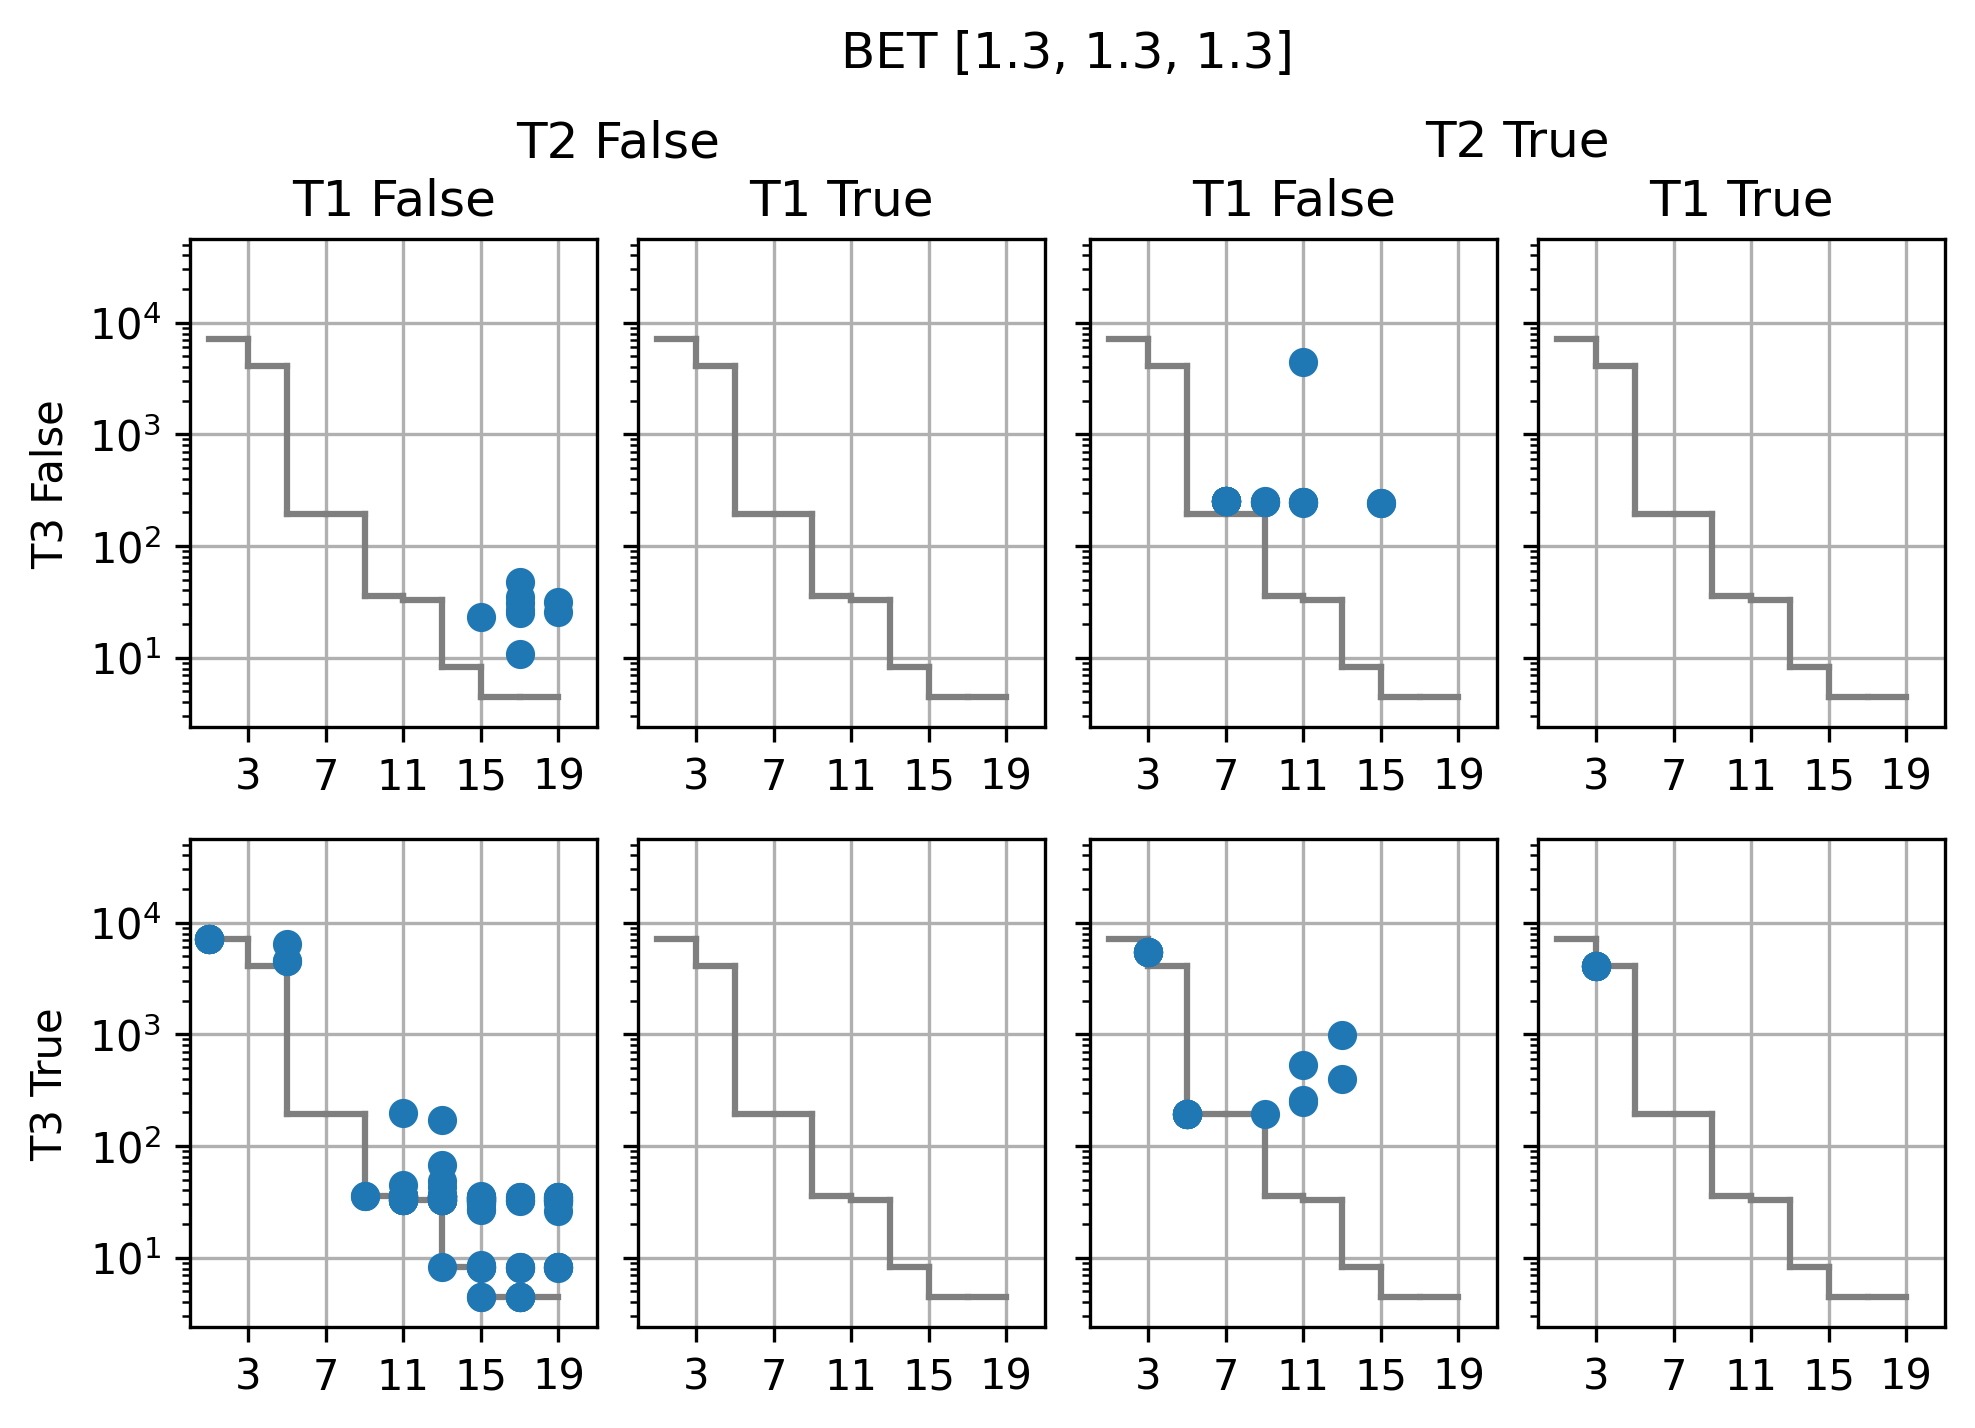

In [733]:
# small multiples plot for showing all thermo vals across a run or set of runs

canonical = False

key, runs = list(experiment.items())[3]
print(key)
#print(np.sum([len(r) for r in runs]))
for r in runs:
    #print(r.head(10))
    lookingFor = r[(r["thermo1"] == True) & (r["thermo2"] == True)]
    #print(lookingFor if not lookingFor.empty else "None :(")

# combine runs
combined = runs[0].append(runs[1])
for i in range(2, len(runs)):
    #print(len(data))
    combined = combined.append(runs[i])
#print(len(combined))

# expects min pareto front from above cell

#fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)
#print(shape(axes))
fig = plt.figure()
subfigs = fig.subfigures(2, 2)
plots = []
for i, subfig in enumerate(subfigs.flat):

    if i == 0:
        subfig.suptitle("T2 False", y=1.05)
    if i == 1:
        subfig.suptitle("T2 True", y=1.05)
    
    axes = subfig.subplots(1, 2, sharex=True, sharey=True, squeeze=True)
    
    # remove x ticks from first row
    #if i < 2:
    #    for ax in axes:
    #        ax.set_xticklabels([])
    
    plots.append(axes[0])
    plots.append(axes[1])



i = 0
for ax in plots:
    #print(i)
    noY = True if i % 4 == 3 else False
    combinedPareto(bestExpressions, ax, noY)
    ax.autoscale(False)
    ax.grid(which="major")

    # get only points with this specific combination of thermos (binary encoding) for this subplot
    points = combined.loc[
        sum([combined["thermo1"], 2*combined["thermo2"], 4*combined["thermo3"]]) == i]
    #ax.scatter(points["minComplexity"], points["loss"])
    #print(len(points))

    # cmap is from 0-1 so 0 = fail thermo constraints
    #plt.scatter(failing["complexity"], failing["loss"], c=pointBadColor, zorder=10, alpha=a, marker=triangle)
    ax.scatter(points["minComplexity"], points[lossVar], c="tab:blue", zorder=10, alpha=a)

    if canonical:
        thermoColors = ["tab:red", "tab:green"]

        # cmap is from 0-1 so 0 = fail thermo constraints
        #plt.scatter(failing["canonComplexity"], failing["loss"], c="tab:pink", zorder=10, alpha=a, marker=triangle)
        ax.scatter(points["minComplexity"], points[lossVar], c="tab:green", zorder=10, alpha=a)


    if i == 0: 
        ax.set_ylabel("T3 False")
    if i == 4:
        ax.set_ylabel("T3 True")
    if i < 4:
        if i % 2 == 0:
            ax.set_title("T1 False")
        else:
            ax.set_title("T1 True")

    i += 1


plt.tight_layout()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.suptitle("BET [1.3, 1.3, 1.3]", y=1.1)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.subplots_adjust(top=0.85)

Langmuir1918methane-cross0.05
AUC = 63.97600708404063
AUC = 65.75979030006826
AUC = 70.10869029222621
AUC = 62.014231399197335
AUC = 59.16032468414668
AUC = 65.90750638150224
AUC = 65.35875695860693
AUC = 45.78408226168833
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (p--34.46002) with loss 4.428000e+02
Best at complexity 5.0 is (89.864235-(194.48817/p)) with loss 1.051000e+02
Best at complexity 7.0 is ((96.32335/((((p+7.795504)*1.7271764)--0.64742225)/p))*1.9335419) with loss 6.675000e+00
Best at complexity 9.0 is ((95.17634/((((p+1.3126283)*0.8425693)+9.598944)/(p+1.6046352)))-0.34266627) with loss 1.674000e+00
Best at complexity 11.0 is ((98.58493/((p+6.4364586)/p))+(0.072211996*p)) with loss 5.333000e+00
Best at complexity 13.0 is (p+(((29.308634-(86.745895/p))-((p*0.0051795444)*p))+28.31386)) with loss 9.351000e+00
Best at complexity 15.0 is (((96.24795+(0.024035662/(0.17170584/((p+-1.1686089)-0.76153654))))/((p+6.0399027)/p))-1.2873346) with loss 

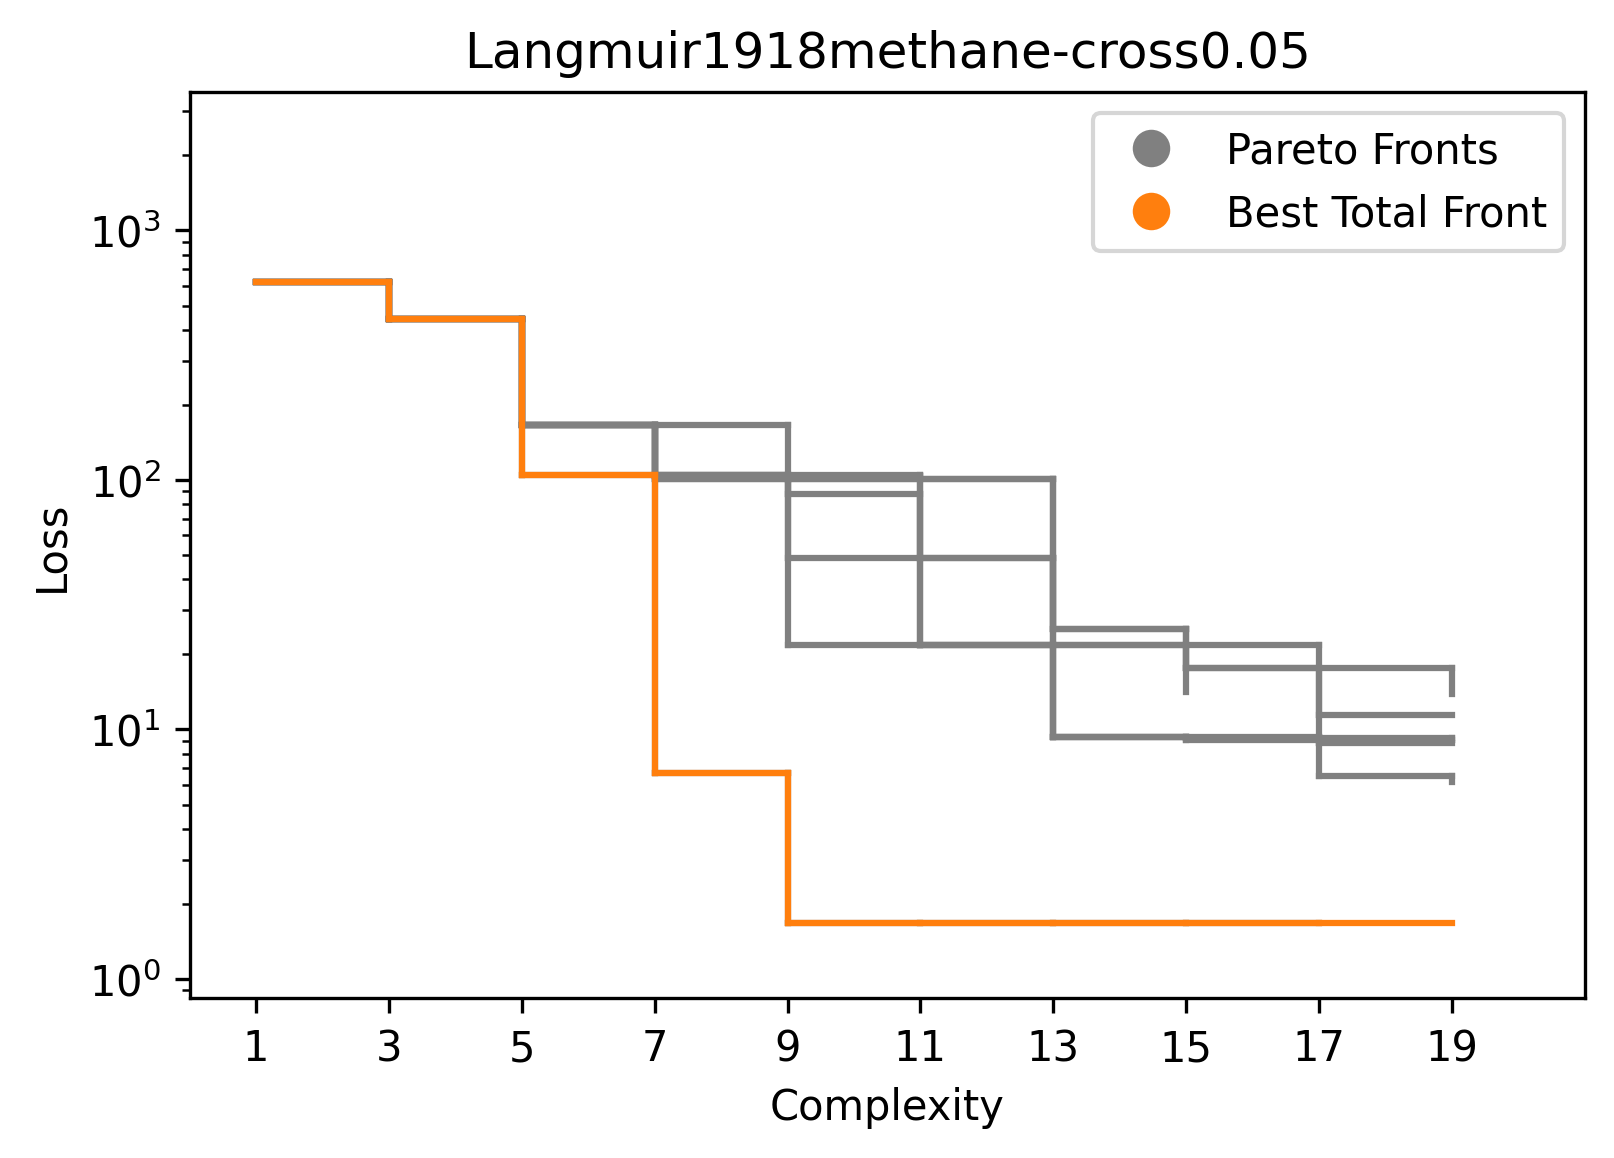

Langmuir1918methane-cross0.0f
AUC = 31.35913944783123
AUC = 56.37061971092767
AUC = 32.28568239607305
AUC = 62.281215614895856
AUC = 48.404410451625616
AUC = 66.35533246949743
AUC = 56.5416017703694
AUC = 70.88596382982537
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (p--34.46) with loss 4.428000e+02
Best at complexity 5.0 is ((-194.49057/p)+89.864655) with loss 1.051000e+02
Best at complexity 7.0 is (54.536587/((4.135872/p)--0.50549287)) with loss 6.675000e+00
Best at complexity 9.0 is (55.433193/((4.300677/((((p--0.75074136)+p)/2.5472207)+0.93676513))--0.49230668)) with loss 1.674000e+00
Best at complexity 11.0 is ((54.577824/((4.4475813/(((p+3.2242925)+p)/2.4073439))--0.4828765))+-0.42243025) with loss 1.674000e+00
Best at complexity 13.0 is ((30.175594/((2.9743507/(p+1.5647388))--0.2679077))-(0.3753824/p)) with loss 1.674000e+00
Best at complexity 15.0 is ((((p-(1.2919958/p))--2.3276913)*88.48237)/((p/1.2794621)--10.949248)) with loss 1.628000e+00
B

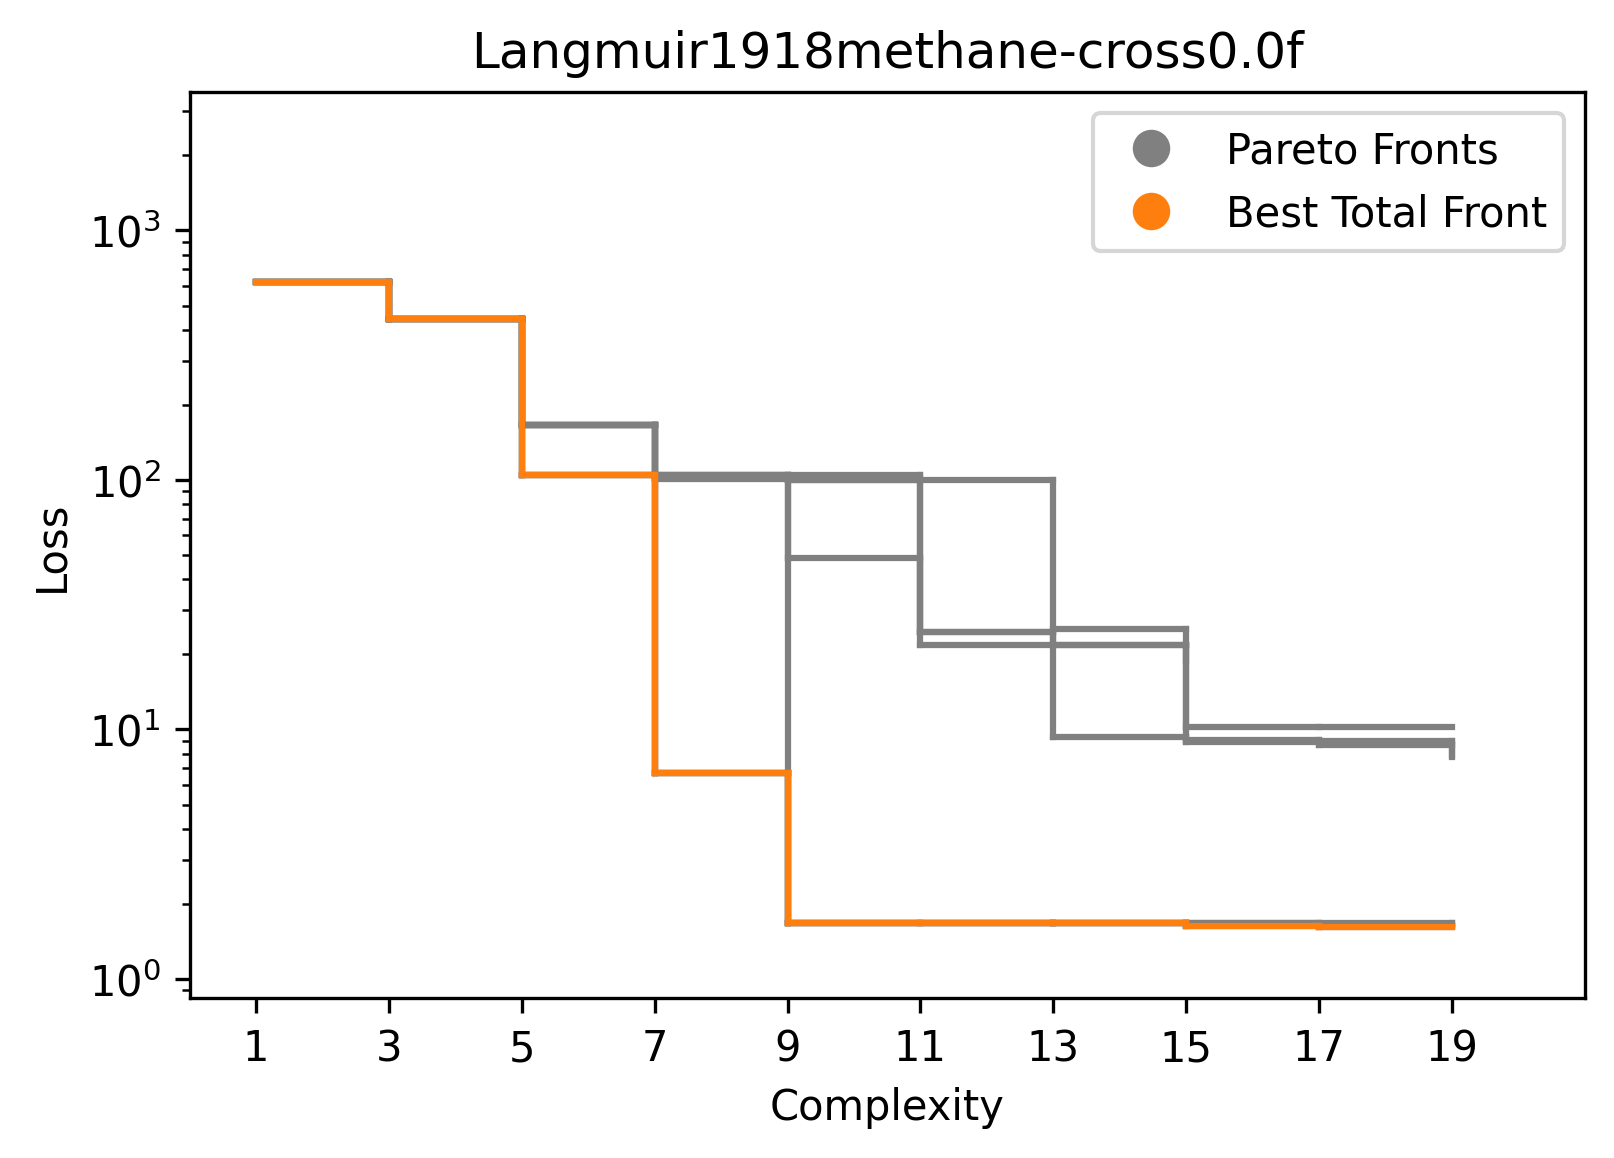

Langmuir1918methane-cross0.1f
AUC = 66.14637589602138
AUC = 64.6348152935275
AUC = 61.57785878088243
AUC = 62.767732647587536
AUC = 67.73117023868706
AUC = 61.12789592791731
AUC = 67.43307193272636
AUC = 53.81216253738335
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (((p+20.093178)-5.726406)+20.093178) with loss 4.428000e+02
Best at complexity 5.0 is (89.864655-(194.49057/p)) with loss 1.051000e+02
Best at complexity 7.0 is (92.07909-(284.8969/(p--1.4500115))) with loss 6.505000e+01
Best at complexity 9.0 is (67.04829-(((-22.96541/((p/1.91585)--6.6337833))*(p+-15.799668))+-1.5781071)) with loss 1.674000e+00
Best at complexity 11.0 is (((-474.66522-(p*-100.98063))-(-794.49805/p))/p) with loss 2.186000e+01
Best at complexity 13.0 is (((p+65.08196)-((86.745995/p)+((p*0.005179546)*p)))-7.4594536) with loss 9.351000e+00
Best at complexity 15.0 is (((((p*0.14627893)+0.9095284)+60.313293)+((-131.36928--1.1764295)/((p*0.27700934)--1.3008671)))+29.790295) with l

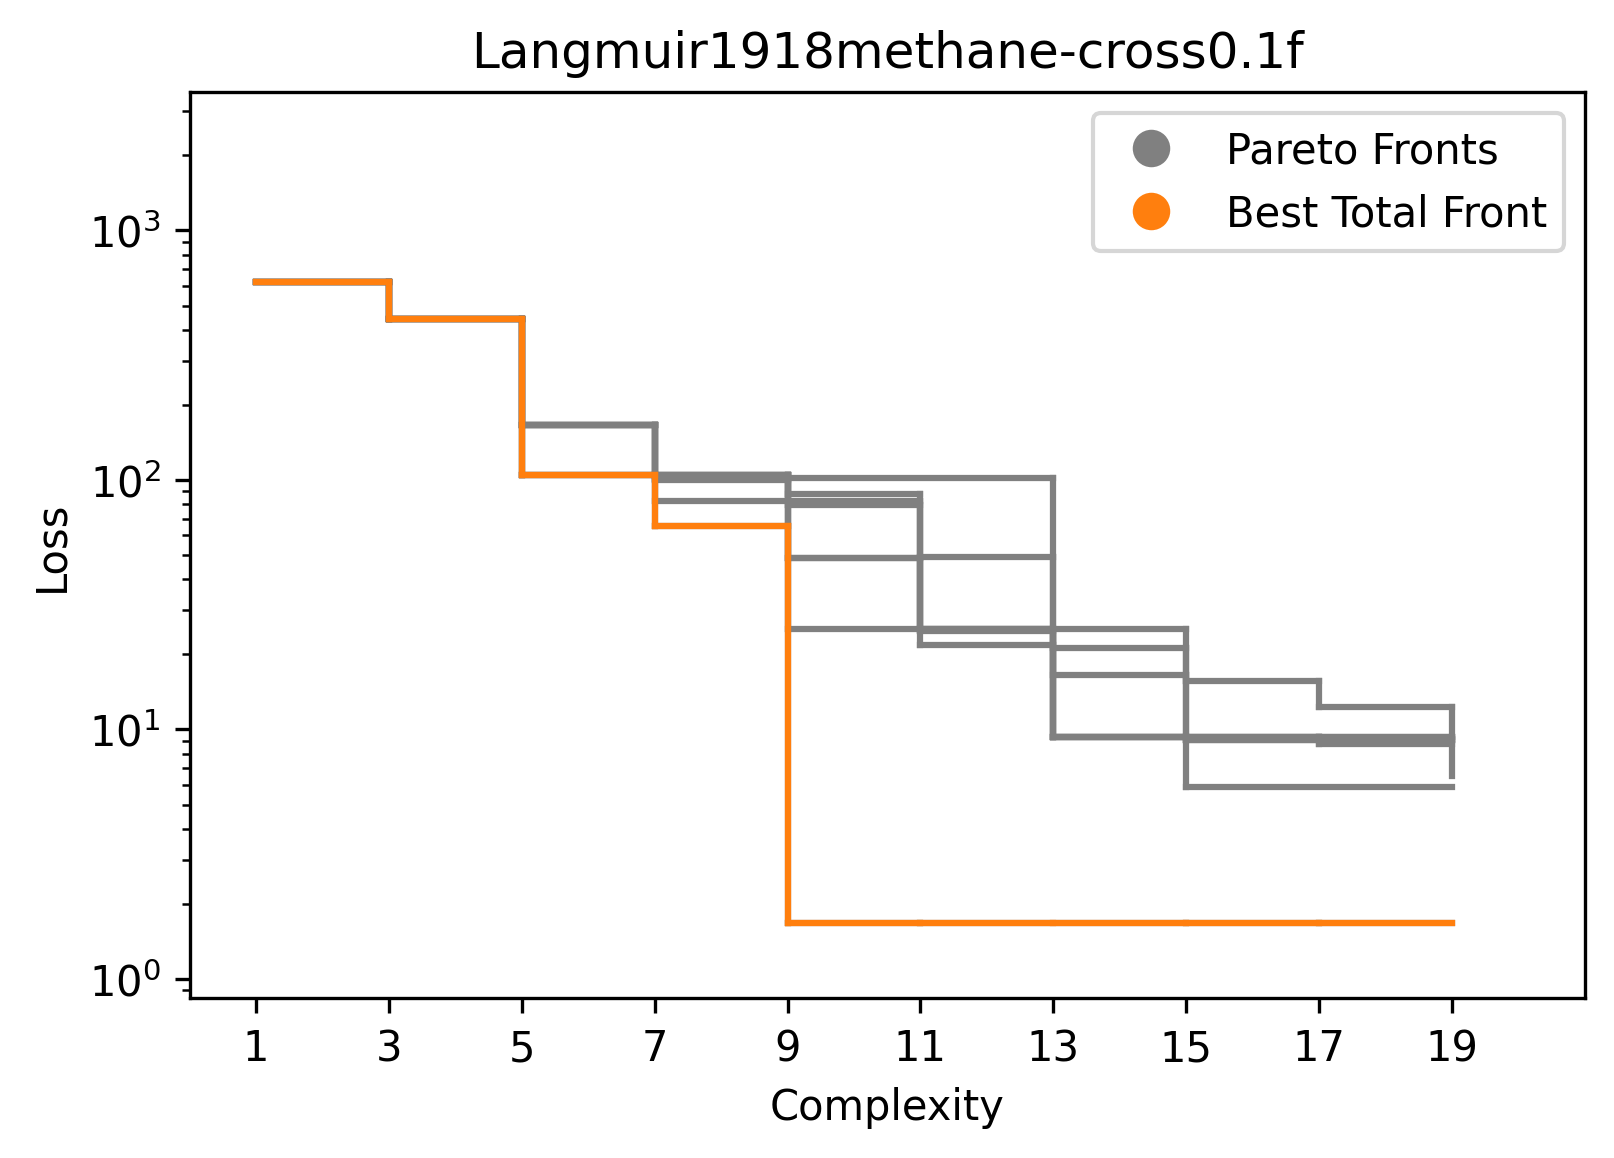

Langmuir1918methane-cross0.2f
AUC = 66.32214120007701
AUC = 63.127342823724504
AUC = 62.143620147984514
AUC = 45.43550340180913
AUC = 58.40306308413328
AUC = 48.76079905612673
AUC = 47.74615663371425
AUC = 64.58313017572097
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (p+34.45997) with loss 4.428000e+02
Best at complexity 5.0 is ((-194.49057/p)+89.864655) with loss 1.051000e+02
Best at complexity 7.0 is ((p/(p+8.11883))/0.00932481) with loss 6.773000e+00
Best at complexity 9.0 is ((((p*44.504757)+(-200.76622-(p+44.987972)))/((p/1.5705372)--8.091793))--44.29834) with loss 1.674000e+00
Best at complexity 11.0 is (((-473.6606-(-794.46436/(p+0.02713221)))/p)--100.98101) with loss 2.172000e+01
Best at complexity 13.0 is ((((p--61.096336)+((p*-0.0051795463)*p))+(-86.746/p))+-3.473824) with loss 9.351000e+00
Best at complexity 15.0 is (((((p+(p-3.9034348))/(p+(9.512008+1.2984856)))/0.024639795)+25.791275)+(p/25.791275)) with loss 1.797000e+00
Best at complexit

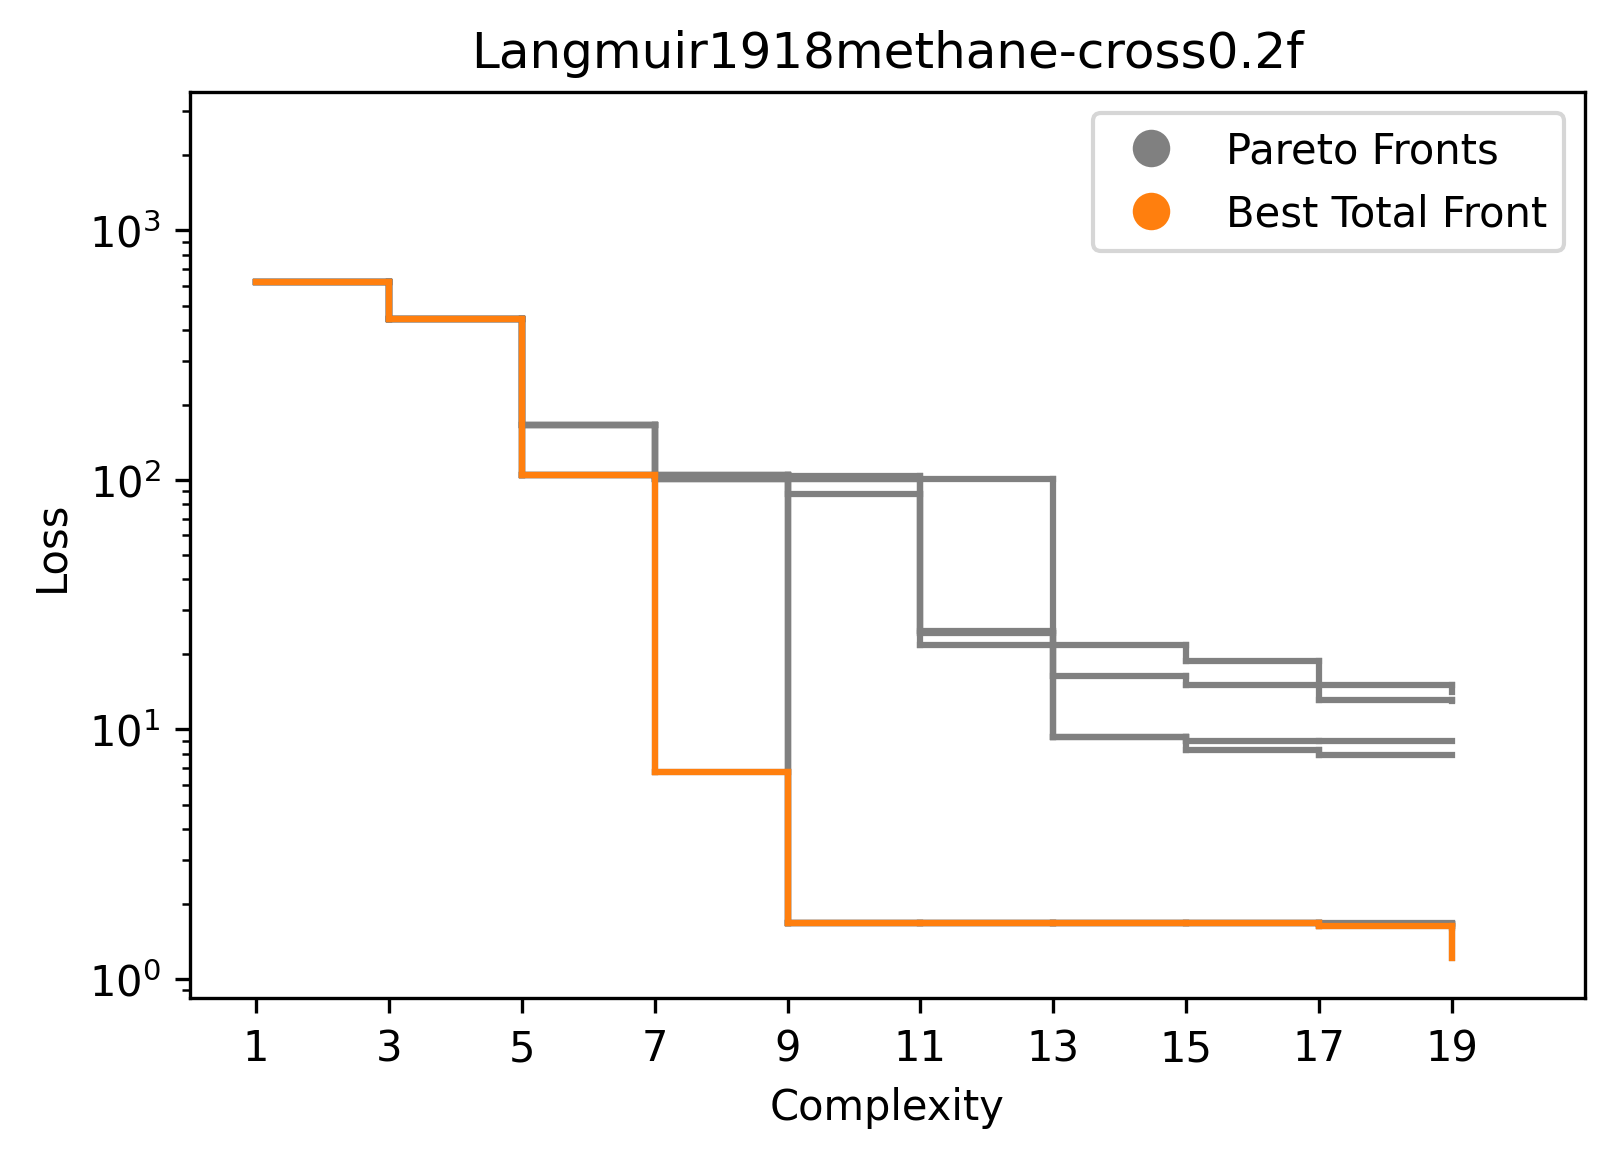

Langmuir1918methane-cross0.3f
AUC = 44.11787597559541
AUC = 52.045189002563745
AUC = 52.3889552952082
AUC = 41.972752997911996
AUC = 35.78234851492204
AUC = 40.49867755320036
AUC = 61.05357775752261
AUC = 32.473822190549456
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (p--34.460075) with loss 4.428000e+02
Best at complexity 5.0 is ((-194.49077/p)+89.86475) with loss 1.051000e+02
Best at complexity 7.0 is ((p*89.866714)/(((((p--4.837584)/1.0593152)--1.9685254)/1.133364)--1.0525208)) with loss 6.675000e+00
Best at complexity 9.0 is ((((p+-4.144333)*55.22316)/((p*0.74204946)+9.427614))+38.198746) with loss 1.674000e+00
Best at complexity 11.0 is (((p*107.89497)+(107.89497/p))/(p--8.186965)) with loss 4.869000e+00
Best at complexity 13.0 is ((((p--1.5715396)*112.62681)+(-1.3391902/p))/(p--12.709237)) with loss 1.673000e+00
Best at complexity 15.0 is (((p--1.5715396)*112.62681)/(p-(-12.709237-(((-0.46287233/p)/-1.5064585)/p)))) with loss 1.671000e+00
Best at

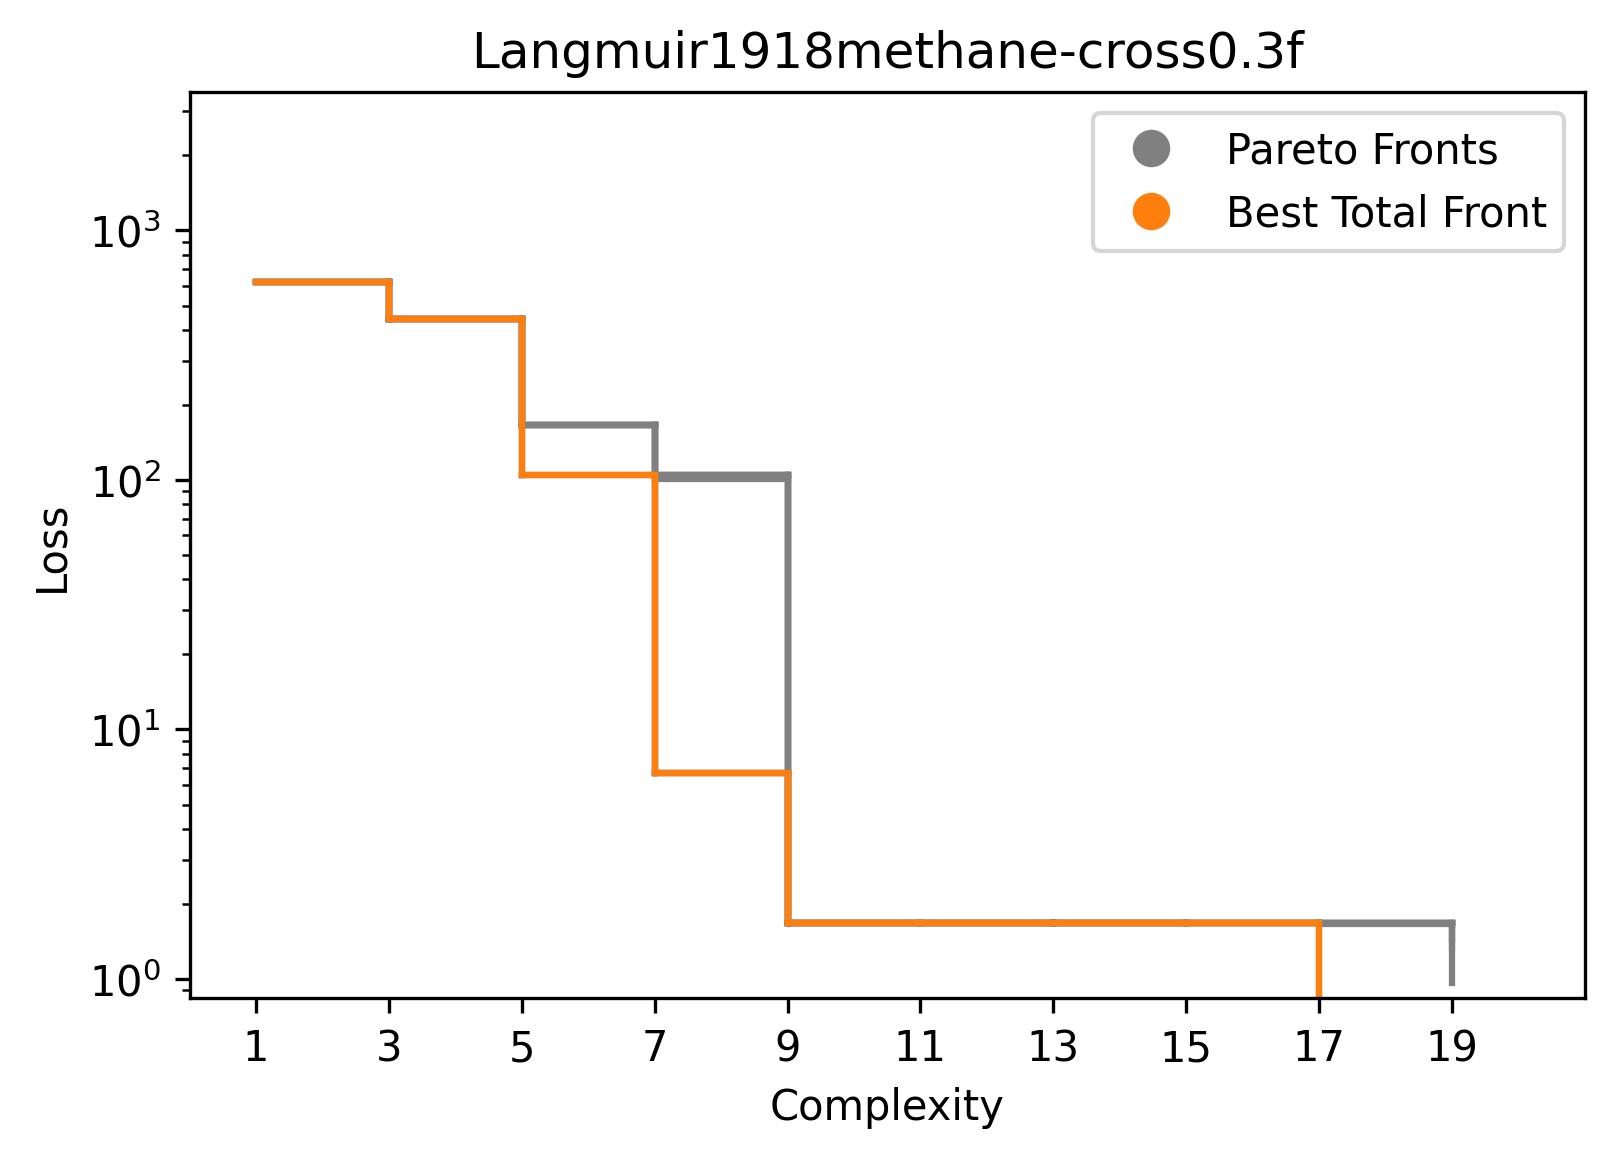

Langmuir1918methane-cross0.5f
AUC = 67.4678957360806
AUC = 62.93500827327854
AUC = 51.3216056657471
AUC = 59.12807443192329
AUC = 56.59878324451947
AUC = 66.01925942396917
AUC = 67.97224087774545
AUC = 45.00964949529964
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (((p--27.651682)--3.3421433)--3.3421433) with loss 4.428000e+02
Best at complexity 5.0 is ((-194.48215/p)+89.86359) with loss 1.051000e+02
Best at complexity 7.0 is (90.98244/((1.2403235-((-6.8999114/p)+-0.009097278))+-0.4060769)) with loss 6.675000e+00
Best at complexity 9.0 is ((((-92.62993/((p+12.708607)/13.54063))+65.18581)--17.807524)+29.630241) with loss 1.674000e+00
Best at complexity 11.0 is (100.96394-(((-794.4441/(p+0.028948992))+472.39413)/p)) with loss 2.168000e+01
Best at complexity 13.0 is ((((p+(p*(p*-0.0051795454)))--64.50558)-(173.49202/(p+p)))+-6.883068) with loss 9.351000e+00
Best at complexity 15.0 is ((-110.36682/((12.708628+(p+(0.30073985/(11.365069-p))))/11.365069))--112

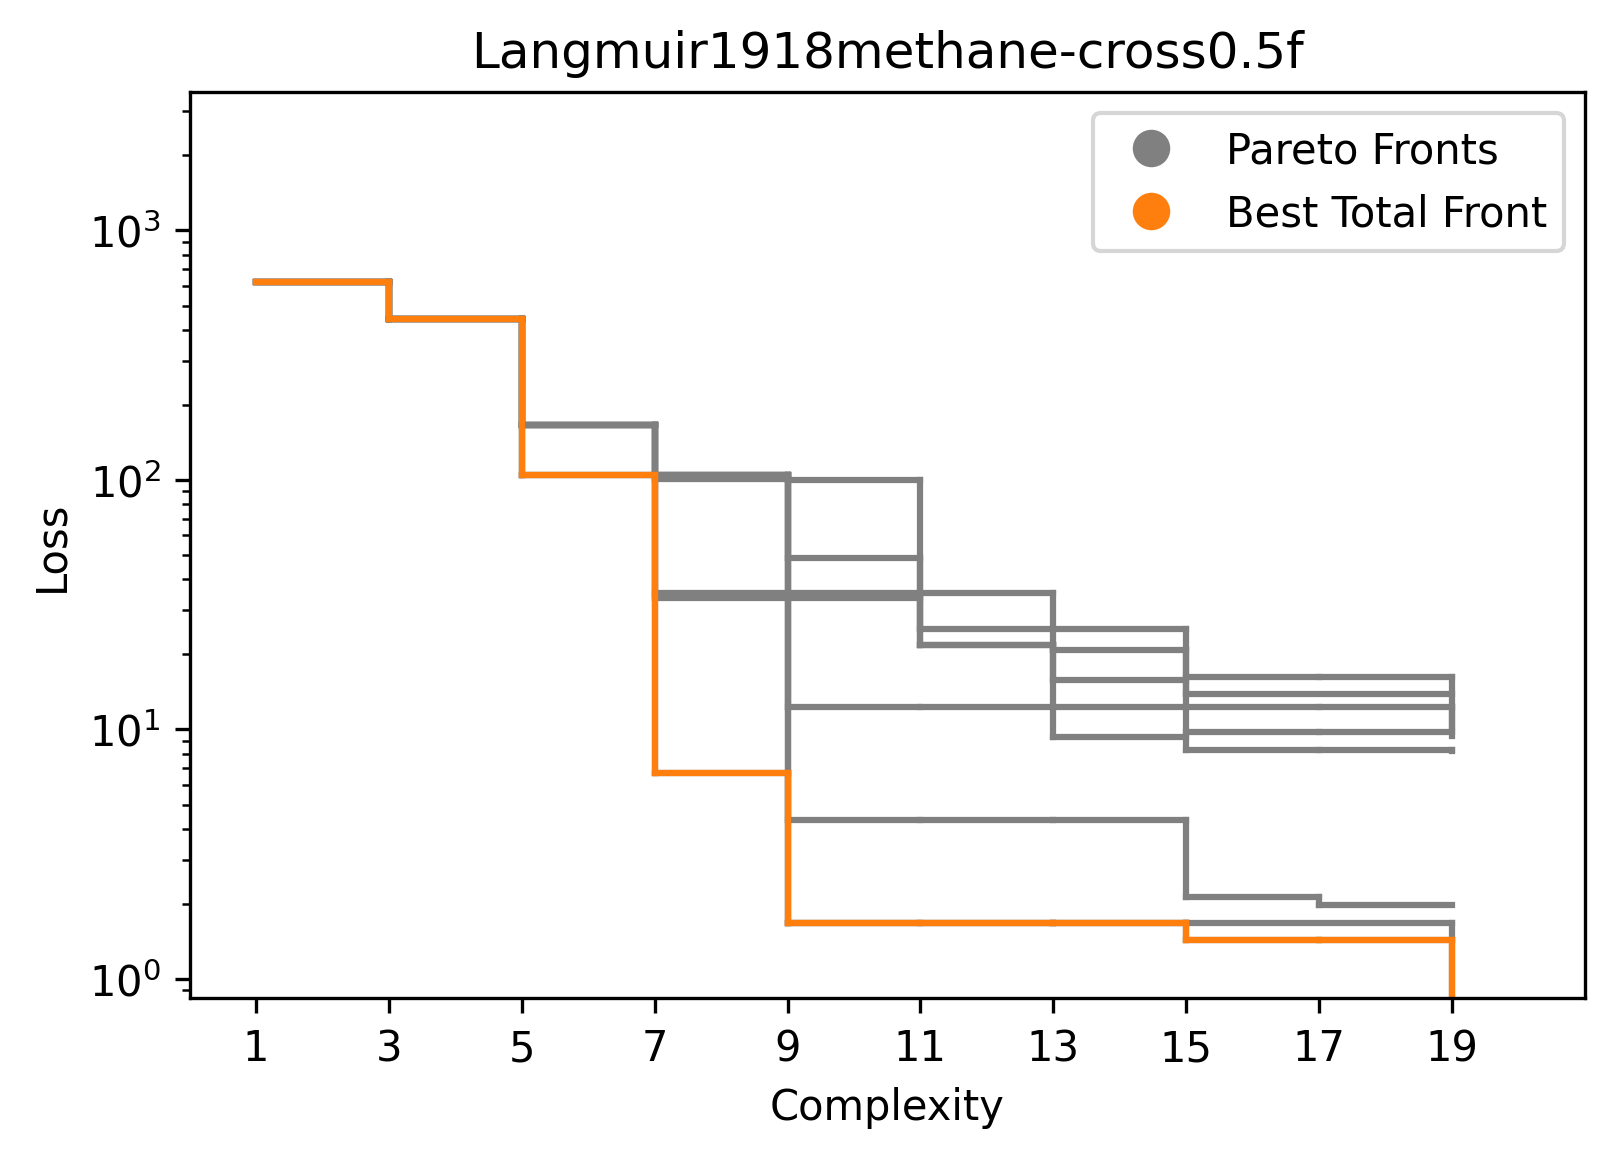

Langmuir1918methane-cross0.7f
AUC = 62.18771900439015
AUC = 55.93844215692523
AUC = 68.21205762316717
AUC = 52.05663705361973
AUC = 56.619436723461654
AUC = 59.61480222392067
AUC = 71.46586068026096
AUC = 63.273952905751806
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (p--34.459923) with loss 4.428000e+02
Best at complexity 5.0 is (89.86522-(194.49579/p)) with loss 1.051000e+02
Best at complexity 7.0 is (114.37195/((((2.2138581-(-2.6678843/p))+-1.1538017)-(-3.1697206/p))-(-2.848849/p))) with loss 6.675000e+00
Best at complexity 9.0 is ((113.58059/(1.0376737-(-11.890041/(p+1.2495133))))+3.1647456) with loss 1.674000e+00
Best at complexity 11.0 is (((p/3.7447674)-(194.49057/(p--1.2226756)))+76.05262) with loss 1.689000e+01
Best at complexity 13.0 is ((113.59659/(1.0200394-(-11.033706/(p+1.4967022))))+(p/113.56902)) with loss 1.660000e+00
Best at complexity 15.0 is ((((60.229122/(p--10.362411))*((p-2.8469756)-2.8469756))--43.63806)+(p/(2.8469756--10.362411

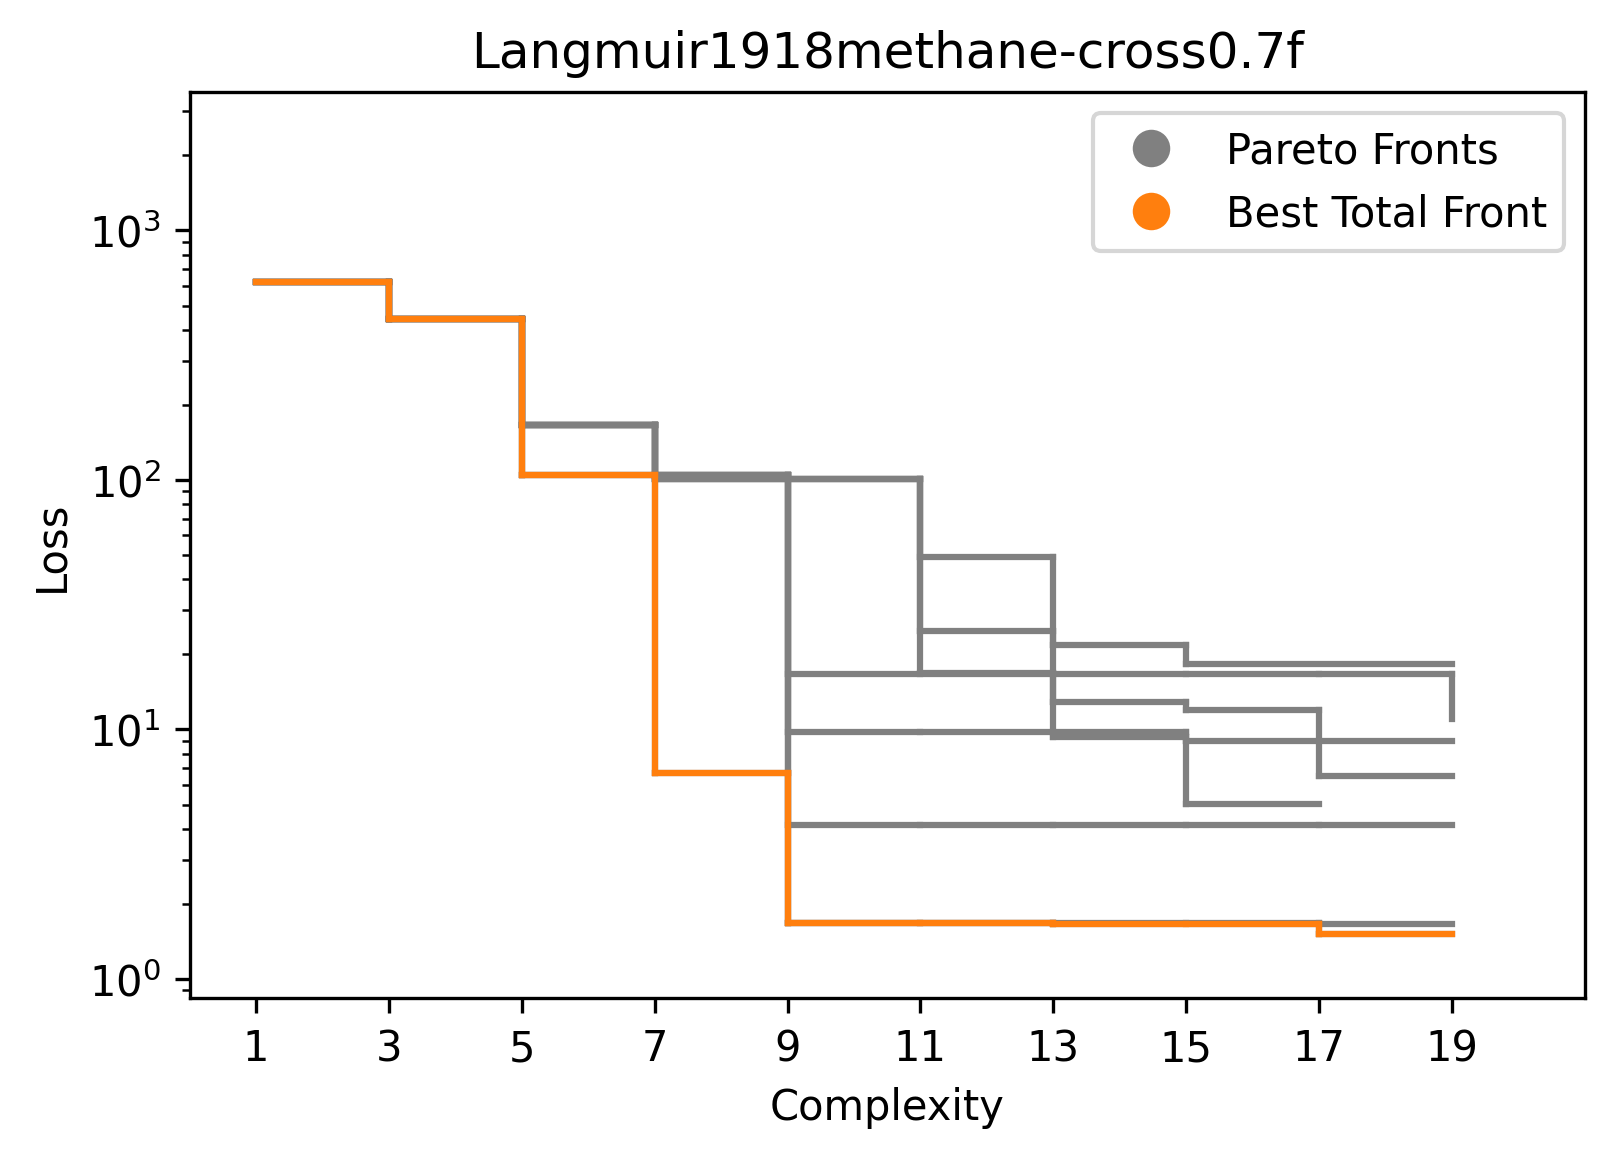

Langmuir1918methane-cross1.0f
AUC = 66.89778854357706
AUC = 74.26409061829278
AUC = 74.61893208062214
AUC = 47.65214080252264
AUC = 12.186236401668964
AUC = 55.831710400232424
AUC = 84.7247549322708
AUC = 66.1086782147853
Best at complexity 1.0 is c1 with loss 6.210000e+02
Best at complexity 3.0 is (p+34.460045) with loss 4.428000e+02
Best at complexity 5.0 is ((-194.49057/p)--89.864655) with loss 1.051000e+02
Best at complexity 7.0 is ((p/p)-(-87.864655-(((p/p)-(195.49057-p))/p))) with loss 1.051000e+02
Best at complexity 9.0 is (((-474.66055-(-794.46423/p))/p)--100.981026) with loss 2.186000e+01
Best at complexity 11.0 is (((794.4645/p)/p)-(-100.980995-(-474.66043/p))) with loss 2.186000e+01
Best at complexity 13.0 is (((-474.66058-((-949.32117-(-469.96008/p))/p))/p)--100.981026) with loss 1.954000e+01
Best at complexity 15.0 is ((((-476.79993-(-800.83936/p))-(p/(-100.981026/p)))/p)--100.981026) with loss 2.037000e+01
Best at complexity 17.0 is (((-477.7912-((((-473.66064-(-1268.1252

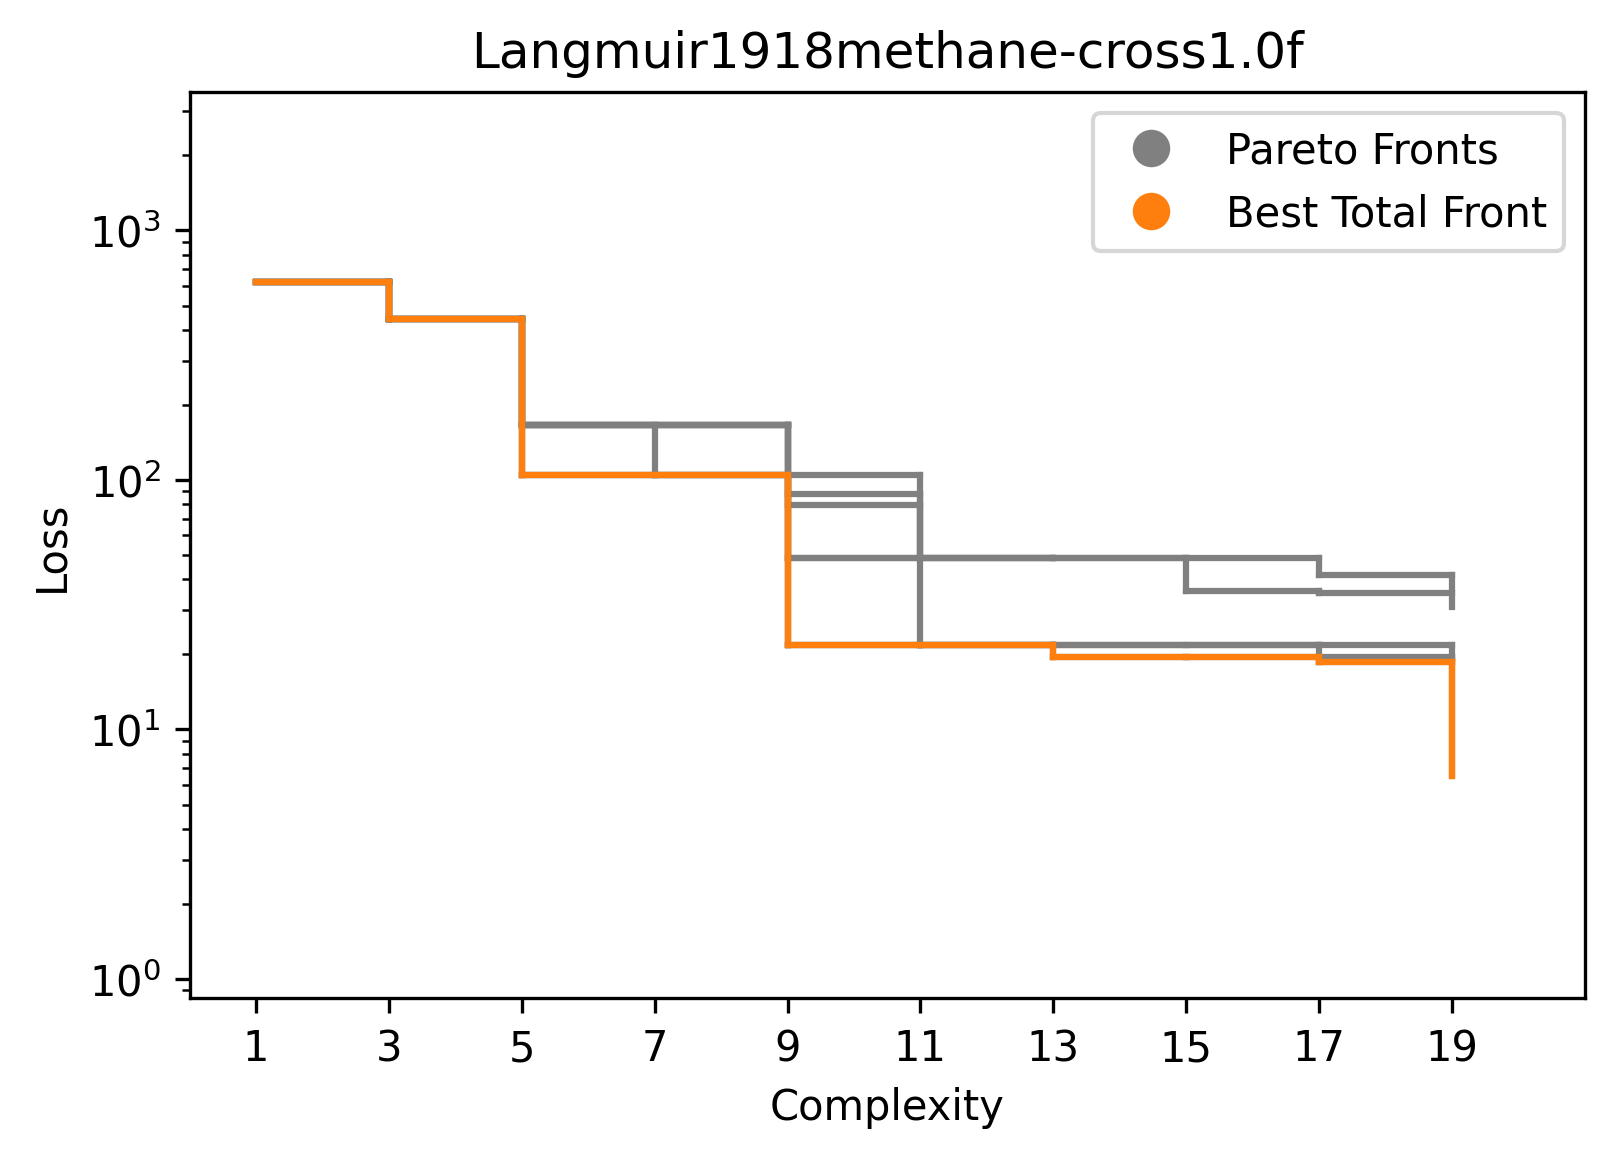

In [1380]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D
from matplotlib import *
import sympy as sp
from itertools import chain
from svgpath2mpl import parse_path
from svgpathtools import svg2paths

#############################
# CHANGE THINGS HERE
#############################

# Expects list of dataframes ("runs") each having cols ["equation", "loss", "complexity"]

# change this to change mode
thermo = True # Expects ["thermo1-3"]
stackLines = True
combineLines = True 
canonical = True # Expects ["simplified", "canonComplexity", "minComplexity"] and ["canonThermoVals"] if thermo also true
canonicalPair = True # Expects all cols needed for canonical
plotMinOnly = False
lossVar = "loss"


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

aucDict = {}
#specificTests = [["1.01.01.0", experiment["1.01.01.0"]], ["1.01.31.3", experiment["1.01.31.3"]]]

for params, runs in experiment.items():
    print(params)
    aucs = []

    #split = params.split(".")
    #paramsList = [split[0][-1]+"."+split[1][0], split[1][1]+"."+split[2][0], split[2][1]+"."+split[3][0]]
    #paramsList = [split[0][-1]+"."+split[1][0]]

    bestExpressions = pd.DataFrame()
    i = 1
    #for run in [runs[7]]:
    #for run in [runs[0], runs[1]]:
    for run in runs:

        if not stackLines:
            print("\n" + "="*15, "\nRun", i, "\n" + "="*15)
        #print(run)

        best, auc = plotParetoFront(run, thermo, stackLines, combineLines, canonical, canonicalPair, plotMinOnly, lossVar)
        #print("AUC =", auc)
        bestExpressions = bestExpressions.append(best)
        aucs.append(auc)

        #plt.savefig("run{}.png".format(i))
        i += 1

    aucDict[params] = paramsList, aucs

    # need to plot after the fact if stacking lines
    if stackLines:
        if combineLines:
            lineColor = "tab:orange"
            yMin = max(bestExpressions[lossVar])
            #print(bestExpressions)
        
            # for all complexities, plot new total pareto front
            i = min(bestExpressions["complexity"])
            temp = i
            # if min complexity col does not exist but needs to be used
            if "minComplexity" not in bestExpressions:
                bestExpressions["minComplexity"] = min(bestExpressions["complexity"], bestExpressions["canonComplexity"])
            while i < max(bestExpressions["complexity"]):
                # find the best expression at this and the next complexity
                thisMin = bestExpressions.loc[bestExpressions["minComplexity"] == i] 
                while thisMin.empty and i < max(bestExpressions["complexity"]):
                    i += 1
                    thisMin = bestExpressions.loc[bestExpressions["minComplexity"] == i] 
                # select instance with lowest loss 
                #print(thisMin)
                thisMin = thisMin.loc[thisMin[lossVar] == thisMin[lossVar].min()].iloc[0]
            
                temp = i + 1
                nextMin = bestExpressions.loc[bestExpressions["minComplexity"] == temp]
                while nextMin.empty and temp < max(bestExpressions["complexity"]):
                    temp += 1
                    nextMin = bestExpressions.loc[bestExpressions["minComplexity"] == temp] 

                # if could not find next min
                if nextMin.empty:
                    nextMin = thisMin
                else:   
                    nextMin = nextMin.loc[nextMin[lossVar] == nextMin[lossVar].min()].iloc[0]

                if thisMin["complexity"] < thisMin["canonComplexity"]:
                    thisComp = thisMin["complexity"]
                    thisEqu = thisMin["equation"]
                else:
                    thisComp = thisMin["canonComplexity"]
                    thisEqu = thisMin["canonEquation"]
                if nextMin["complexity"] < nextMin["canonComplexity"]:
                    nextComp = nextMin["complexity"]
                    nextEqu = nextMin["equation"]
                else:
                    nextComp = nextMin["canonComplexity"]
                    nextEqu = nextMin["canonEquation"]

                #print("iterators = ", i, "and", temp)
                #print("complexities =", thisComp, "and", nextComp)
                if i == 1: print("Best at complexity {} is {} with loss {:e}".format(thisComp, thisEqu.replace(" ", ""), thisMin[lossVar]))
                print("Best at complexity {} is {} with loss {:e}".format(nextComp, nextMin["equation"].replace(" ", ""), nextMin[lossVar]))
                #print("Best at complexity {} is {} or {} with loss {:e}".format(nextComp, nextMin["equation"].replace(" ", ""), nextMin["canonEquation"].replace(" ", ""), nextMin["loss"]))

                # get coords needed for up/down and over lines
                x1 = i
                x2 = temp
                y1 = thisMin[lossVar]
                y2 = nextMin[lossVar]
                if y1 < yMin:
                    yMin = y1
                i = temp

                #if next complexity higher
                if yMin <= y2:
                    plt.plot([x1,x2], [yMin,yMin], c=lineColor)
            
                #else same or lower
                else:
                    #need to go over then down
                    plt.plot([x1,x2],[yMin,yMin], c=lineColor)
                    plt.plot([x2,x2],[yMin,y2], c=lineColor)
                    yMin = y2

            # other combined pareto front stuff

            # binary stars
            #plt.scatter(7, 4.771, c="tab:blue", zorder=100)
            #plt.plot([7,20], [4.771, 4.771], c="tab:blue")
            #plt.annotate("sqrt(cube(d)/(m1+m2))", (7, 4.771), xytext=(0.5,0.7), c="tab:blue")

            # binary stars norm
            #plt.scatter(9, 35.80964194460454, c="tab:blue", zorder=100)
            #plt.plot([9,20],[35.80964194460454,35.80964194460454])
            #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (7, 4.771), xytext=(1,8), color="tab:blue")
            #plt.scatter(11, 2.46, c="tab:blue", zorder=100)
            #plt.annotate("sqrt(cube(d)*((c1/m1)-(c2/m2)))", (11, 2.46), xytext=(1,0.5))

            # exoplanets
            #plt.scatter(5, 7.792000e-04, c="tab:blue", zorder=100)
            #plt.annotate("sqrt(cube(d*-0.509011))", (5, 7.792000e-04), xytext=(5.5, 1.5e-3))
            #plt.scatter(7, 1.180000e-04, c="tab:blue", zorder=100)
            #plt.annotate("sqrt(cube(d*0.509012)/m1)", (7, 1.180000e-04), xytext=(7.5, 3e-4))
            #plt.scatter(9, 4.027, c="tab:blue", zorder=100)
            #plt.plot([9,20], [4.027,4.027], c="tab:blue")
            #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (9, 4.027), xytext=(9, 15), color="tab:blue")

            # exoplanets norm


            # solar
            #plt.scatter(3, 6.608000e-02, c="tab:blue", zorder=100)
            #plt.annotate("c1*d (canonical form)", (3, 6.608000e-02), xytext=(5.5, 8e-2))
            #plt.scatter(5, 2.945000e-04, c="tab:blue", zorder=100)
            #plt.annotate("sqrt(cube(d)*0.13188303)", (5, 2.945000e-04), xytext=(5.5, 5e-4))
            #plt.scatter(9, 10, c="tab:blue", zorder=100)
            #plt.plot([9,20], [10,10], c="tab:blue")
            #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (9, 10), xytext=(9, 15), color="tab:blue")

            legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="grey", label="Pareto Fronts"),
                Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:orange", label="Best Total Front")]#,
                #Line2D([0], [0], marker="o", color="w", markersize=10,
                #markerfacecolor="tab:blue", label="Ground Truth")]
            plt.legend(handles=legend_elements)
            #plt.title(", ".join(paramsList))
            plt.title(params)

        else:
            #plt.title("IBM Solar Results")
            plt.grid()
            plt.legend()
            plt.show()
    plt.show()

In [723]:

def combinedPareto(bestExpressions, ax, noY=False): 

    compVar = "minComplexity"
    auc = 0
    labeled = False
    lossVar = "error"

    ax.set_xticks([3,7,11,15,19])
    #for index, label in enumerate(ax.xaxis.get_ticklabels()):
    #    if index % 2 != 0:
    #        label.set_visible(False)
    ax.set_xlim(0, 21)
    #plt.xticks(np.arange(min(x), max(max(run["complexity"])+1, max(run["canonComplexity"])+1, 20), 1.0))
    ax.set_yscale("log")
    # nitrogen
    #ax.set_ylim(bottom=0.186/2, top=270.1)
    # methane
    #ax.set_ylim(bottom=1.674/2, top=3582.0)
    # isobutane
    #ax.set_ylim(bottom=0.0003523/2, top=10)
    # BET
    ax.set_ylim(bottom=4.811/2, top=55780.0)

    #plt.yticks([1e-5,1e-4,1e-3, 1e-2, 1e-1, 1])
    if noY:
        ax.set_yticklabels([])

    # Title!
    #ax.title("Methane Crossover=1.0")
    #ax.set_xlabel("Complexity")
    #ax.set_ylabel("Loss")

    lineColor = "tab:grey"
    yMin = max(bestExpressions[lossVar])
    #print(bestExpressions)
       
    # for all complexities, plot new total pareto front
    i = min(bestExpressions["complexity"])
    temp = i
    x = bestExpressions["complexity"]

    while i < max(bestExpressions["complexity"]):
        # find the best expression at this and the next complexity
        thisMin = bestExpressions.loc[bestExpressions[compVar] == i] 
        #print(thisMin)
        while thisMin.empty and i < max(x):
            i += 1
            thisMin = bestExpressions.loc[bestExpressions[compVar] == i] 
        # select instance with lowest loss 
        thisMin = thisMin.loc[thisMin[lossVar] == thisMin[lossVar].min()].iloc[0]

        temp = i + 1
        nextMin = bestExpressions.loc[bestExpressions[compVar] == temp] 

        while nextMin.empty and temp < max(x):
            temp += 1
            #print("temp in loop =", temp)
            nextMin = bestExpressions.loc[bestExpressions[compVar] == temp] 

        # if could not find next min
        if nextMin.empty:
            nextMin = thisMin
        else:   
            nextMin = nextMin.loc[nextMin[lossVar] == nextMin[lossVar].min()].iloc[0]

        # determine what to print out for this point
        if canonical:
            if thisMin["complexity"] < thisMin["canonComplexity"]:
                thisComp = thisMin["complexity"]
                thisEqu = thisMin["equation"]
            else:
                thisComp = thisMin["canonComplexity"]
                thisEqu = thisMin["simplified"]
            if nextMin["complexity"] < nextMin["canonComplexity"]:
                nextComp = nextMin["complexity"]
                nextEqu = nextMin["equation"]
            else:
                nextComp = nextMin["canonComplexity"]
                nextEqu = nextMin["simplified"]
        else:
            thisComp = thisMin["complexity"]
            thisEqu = thisMin["equation"]
            nextComp = nextMin["complexity"]
            nextEqu = nextMin["equation"]

        #if not stackLines:
        #    if i == min(x): print("Best expression at complexity {} is {} with loss {:e}".format(thisComp, thisEqu.replace(" ", ""), thisMin["loss"]))
        #    print("Best expression at complexity {} is {} with loss {:e}".format(nextComp, nextEqu.replace(" ", ""), nextMin["loss"]))

        # get coords needed for up/down and over lines
        x1 = i
        x2 = temp
        y1 = thisMin[lossVar]
        y2 = nextMin[lossVar]
        if y1 < yMin:
            yMin = y1

        # area under curve for this box is just length * width
        auc += (x2 - x1) * (y2)

        i = temp

        #if next complexity higher
        if yMin <= y2:
            # need to stay at this height
            #print("staying at same height")

            # format [x points], [y points].  draws line from first xy pair to second pair
            # make sure to only add label to one line segment
            if not labeled:
                # over line
                ax.plot([x1,x2], [yMin,yMin], c=lineColor) #, label="Run " + str(int(runNum + 1)))
                labeled = true
            else:
                ax.plot([x1,x2], [yMin,yMin], c=lineColor)
       
        #else same or lower
        else:
            #need to go over then down
            #print("drawing lower")
            if not labeled:
                ax.plot([x1,x2],[yMin,yMin], c=lineColor) #, label="Run " + str(int(runNum + 1)))
                labeled = True
            else:
                ax.plot([x1,x2],[yMin,yMin], c=lineColor)
            ax.plot([x2,x2],[yMin,y2], c=lineColor)
            
            yMin = y2


In [783]:
#print(aucDict)
paramsToAvgList = []
for key, (params, value) in aucDict.items():
    print(params)
    print(value)
    t1 = int(float(params[0])*10)
    t2 = int(float(params[1])*10)
    t3 = int(float(params[2])*10)
    avg = np.mean(value)
    std = np.std(value)
    var = np.var(value)
    #print(key, ":", avg)
    paramsToAvgList.append([t1,t2,t3,avg,std,var])

paramsToAvg = pd.DataFrame(paramsToAvgList, columns=["t1", "t2", "t3", "avg", "std", "var"])
print(paramsToAvg)

['1.0', '1.0', '1.0']
[54.85708871795202, 49.28456858131115, 37.698612441049534, 61.54417646644008, 70.71124983347507, 57.94249007958246, 47.02102576320861, 72.41286055761432]
['1.0', '1.0', '1.1']
[64.22246480475528, 65.56835500900442, 54.83714166859318, 72.16919293192196, 73.34540973683191, 52.253517735191295, 43.022683154543, 32.46451577891031]
['1.0', '1.0', '1.2']
[71.98871842638009, 66.19256685383661, 70.52411234505838, 49.85277911365822, 70.5706249824139, 49.82419648546707, 61.53084958384401, 43.44454918804486]
['1.0', '1.0', '1.3']
[65.65895700053805, 74.15909643282295, 71.48733855565789, 51.21738232740071, 73.26786472929459, 69.87785595361042, 41.0285617513291, 69.86867395290767]
['1.0', '1.1', '1.0']
[57.3537441675455, 72.98051189498233, 56.31676591371158, 67.79683218850546, 70.3173997164978, 62.7554400330459, 65.33174898290731, 65.27871748083126]
['1.0', '1.1', '1.1']
[59.20369186531123, 54.79397116053732, 61.2196339781576, 64.36828349173672, 68.76989803654588, 49.5026134786

In [346]:
print(paramsToAvg.columns)
print(paramsToAvg.min())

Index(['t1', 't2', 't3', 'avg'], dtype='object')
t1       10.00000
t2       10.00000
t3       10.00000
avg    1571.19075
dtype: float64


vmin: 51.22041182095987 vmax: 70.48063812864936
[[56.43400906 51.22041182 62.13079706 57.53525258]
 [64.76639505 62.30458658 65.18803446 70.08596383]
 [61.82102785 57.47483715 65.9885854  66.11091111]
 [64.05551517 66.04358753 66.06018652 64.66302219]]
[[56.43400906 64.76639505 61.82102785 64.05551517]
 [57.2354101  61.43466095 62.46913205 61.6305211 ]
 [60.49104962 62.43359613 63.82744664 56.96685927]
 [64.57071634 64.7789807  66.48107868 61.64316286]]
[[56.43400906 57.2354101  60.49104962 64.57071634]
 [51.22041182 61.0245117  59.88851348 61.81496006]
 [62.13079706 62.99257874 63.88886572 68.39823477]
 [57.53525258 70.48063813 65.94488391 63.50596076]]


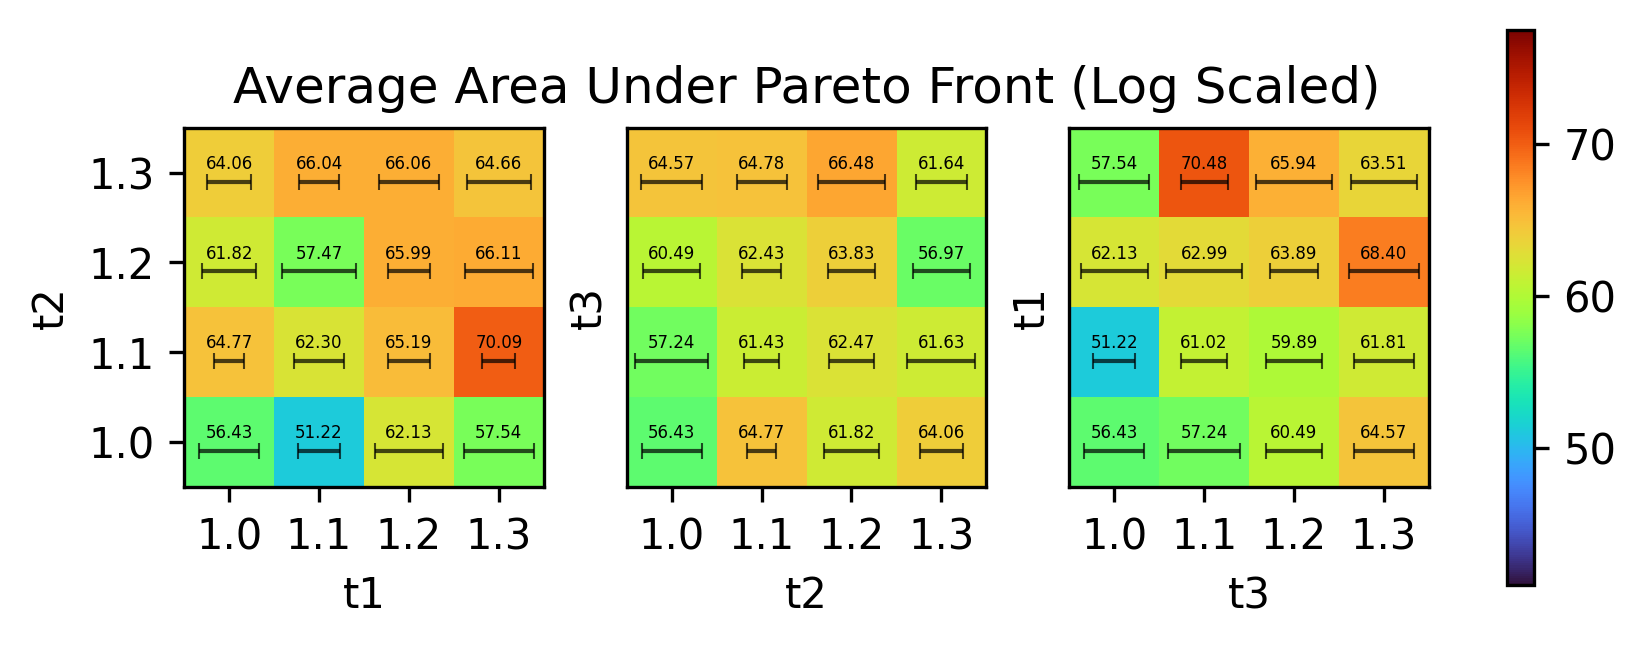

In [853]:
import matplotlib

fig, ax = plt.subplots(ncols=3)
#plt.scatter(paramsToAvg["t1"], paramsToAvg["t2"], c=paramsToAvg["avg"])
#ax.hist2d(paramsToAvg["t1"], paramsToAvg["t2"], bins=[4,4], cmap="RdYlGn_r", c=paramsToAvg["avg"])
#ax.imshow(paramsToAvg[["t1","t2"]].to_numpy())

def makeGrid(data, x, y, z):
    result = np.empty([4,4])
    resultFull = np.empty([4,4], dtype=list)
    for index, item in data.iterrows():
        #print(item[x], item[y], item[z], item[val])
        
        # min
        #if result[int(item[x])-10][int(item[y])-10] > float(item[z]) or result[int(item[x])-10][int(item[y])-10] == 0:
        #    result[int(item[x])-10][int(item[y])-10] = float(item[z])

        # take only where unused axis = 0
        if float(item[z])-10 == 0:
            result[int(item[x])-10][int(item[y])-10] = float(item["avg"])
            resultFull[int(item[x])-10][int(item[y])-10] = [float(item["avg"]), float(item["std"]), float(item["var"])]

    # average
    #    result[int(item[x])-10][int(item[y])-10] += float(item[z])
    # average
    #for item in result:
    #    item /= 4

    return result, resultFull

t1t2, t1t2Full = makeGrid(paramsToAvg, "t1", "t2", "t3")
t2t3, t2t3Full = makeGrid(paramsToAvg, "t2", "t3", "t1")
t3t1, t3t1Full = makeGrid(paramsToAvg, "t3", "t1", "t2")
grids = [t1t2, t2t3, t3t1]
gridNames = ["t1t2", "t2t3", "t3t1"]
gridsFull = [t1t2Full, t2t3Full, t3t1Full]
plots = [0,0,0]

minAUC = np.min([t1t2, t2t3, t3t1])
maxAUC = np.max([t1t2, t2t3, t3t1])

print("vmin:", minAUC, "vmax:", maxAUC)
cmap = cm.turbo
norm = colors.Normalize(vmin=minAUC*0.8, vmax=maxAUC*1.1)

for i, axi in enumerate(ax):
    print(np.array(grids[i]).T)
    plots[i] = axi.imshow(np.array(grids[i]).T, cmap=cmap, norm=norm)
    xLab = gridNames[i][:2]
    yLab = gridNames[i][2:]
    for x in range(4):
        for y in range(4):
            # just avg 
            #text = axi.text(x, y, int(grids[i][x][y]), ha="center", va="center", color="black", fontsize=5)
            # all stats data
            #stats = "m: {:2.2f}\ns: {:2.2f}\nv: {:2.2f}".format(*gridsFull[i][x][y])
            #text = axi.text(x, y, stats, ha="center", va="center", color="black", fontsize=4)
            stats = "{:2.2f}".format(grids[i][x][y])
            text = axi.text(x, y+0.1, stats, ha="center", va="center", color="black", fontsize=4)
            # error bars for std deviation
            errorBars = axi.errorbar(x,y-0.1, xerr=gridsFull[i][x][y][1]*0.03, 
                    alpha=0.7, elinewidth=1, capsize=2, capthick=0.5, ecolor="black", barsabove=False)

    axi.set_xticks(np.arange(4))
    axi.set_xticklabels([1.0, 1.1, 1.2, 1.3])
    axi.set_xlabel(xLab)
    axi.set_ylabel(yLab)
    if i == 0:
        axi.set_yticks(np.arange(4))
        axi.set_yticklabels([1.0, 1.1, 1.2, 1.3])
    else:
        axi.set_yticks([])
    axi.invert_yaxis()
ax[1].set_title("Average Area Under Pareto Front (Log Scaled)")
fig.tight_layout()

plt.colorbar(ax=ax, shrink=0.5, mappable=cm.ScalarMappable(cmap=cmap, norm=norm))
plt.show()


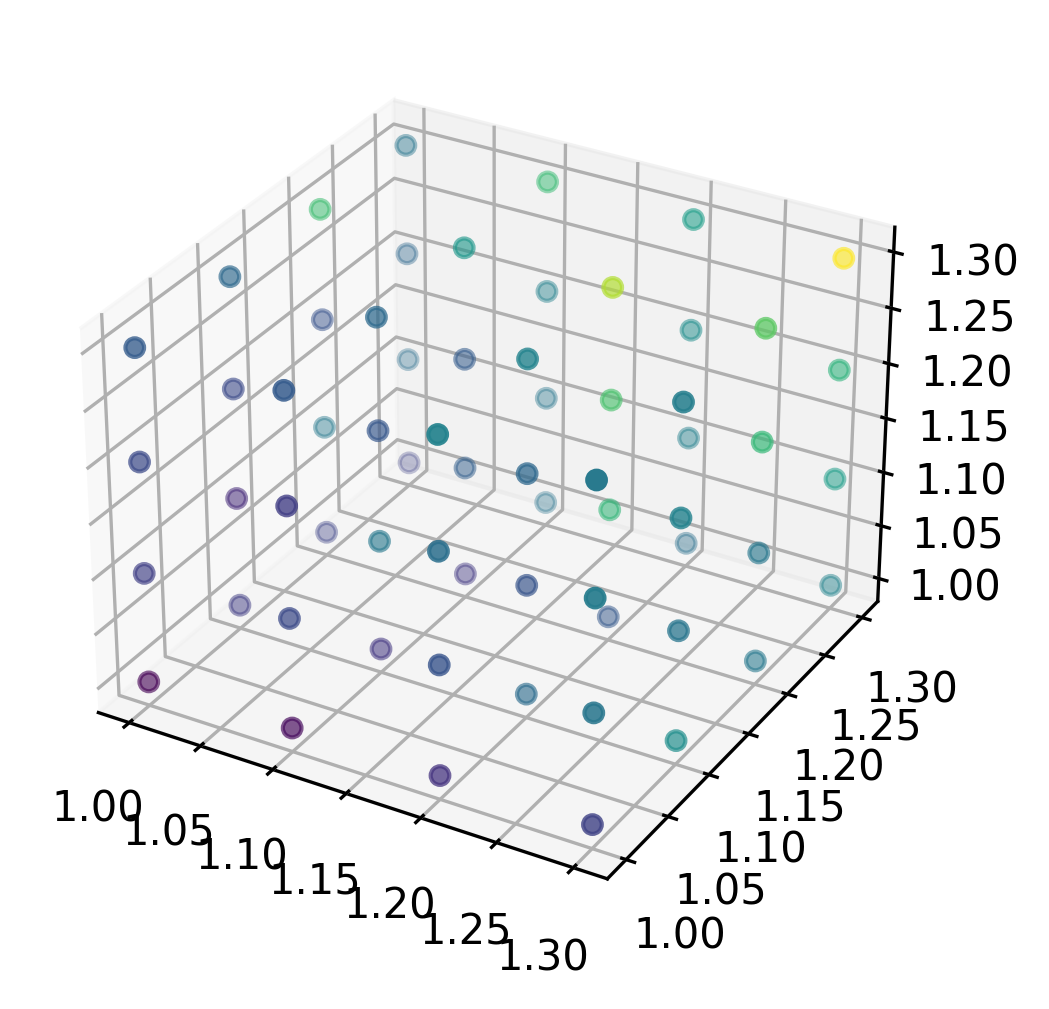

In [239]:
from mpl_toolkits import mplot3d

ax = plt.axes(projection="3d")
ax.scatter(paramsToAvg["t1"]/10, paramsToAvg["t2"]/10, paramsToAvg["t3"]/10, c=paramsToAvg["avg"])

Brunauer1938-1.01.01.0
minComplexity
AUC = 8998.2
minComplexity
AUC = 9173.294
minComplexity
AUC = 8986.080000000002
minComplexity
AUC = 9974.42
minComplexity
AUC = 9224.418000000001
minComplexity
AUC = 9191.56
minComplexity
AUC = 10067.64
minComplexity
AUC = 8993.48
Best at complexity 1.0 is c1 with loss 4.221000e+03
Best at complexity 3.0 is (p*535.9959) with loss 4.088000e+03
Best at complexity 5.0 is ((p*307.25095)--96.05276) with loss 1.484000e+02
Best at complexity 7.0 is ((p*(307.25095-p))--96.05276) with loss 1.483000e+02
Best at complexity 9.0 is ((p*279.0123)-(-108.42053-(-0.12272537/p))) with loss 2.129000e+01
Best at complexity 11.0 is ((((p*285.67682)-(-106.73384-((-0.00030704399/(p*p))+p)))-1.5639596)-p) with loss 1.964000e+01
Best at complexity 13.0 is ((((p+0.41215456)*(16.018183+p))/0.06039906)-(0.12468025/p)) with loss 1.845000e+01
Best at complexity 15.0 is (((p*(((p--0.015705872)*127.45212)+194.45856))-(0.14746547/p))--116.529274) with loss 4.854000e+00
Best at comp

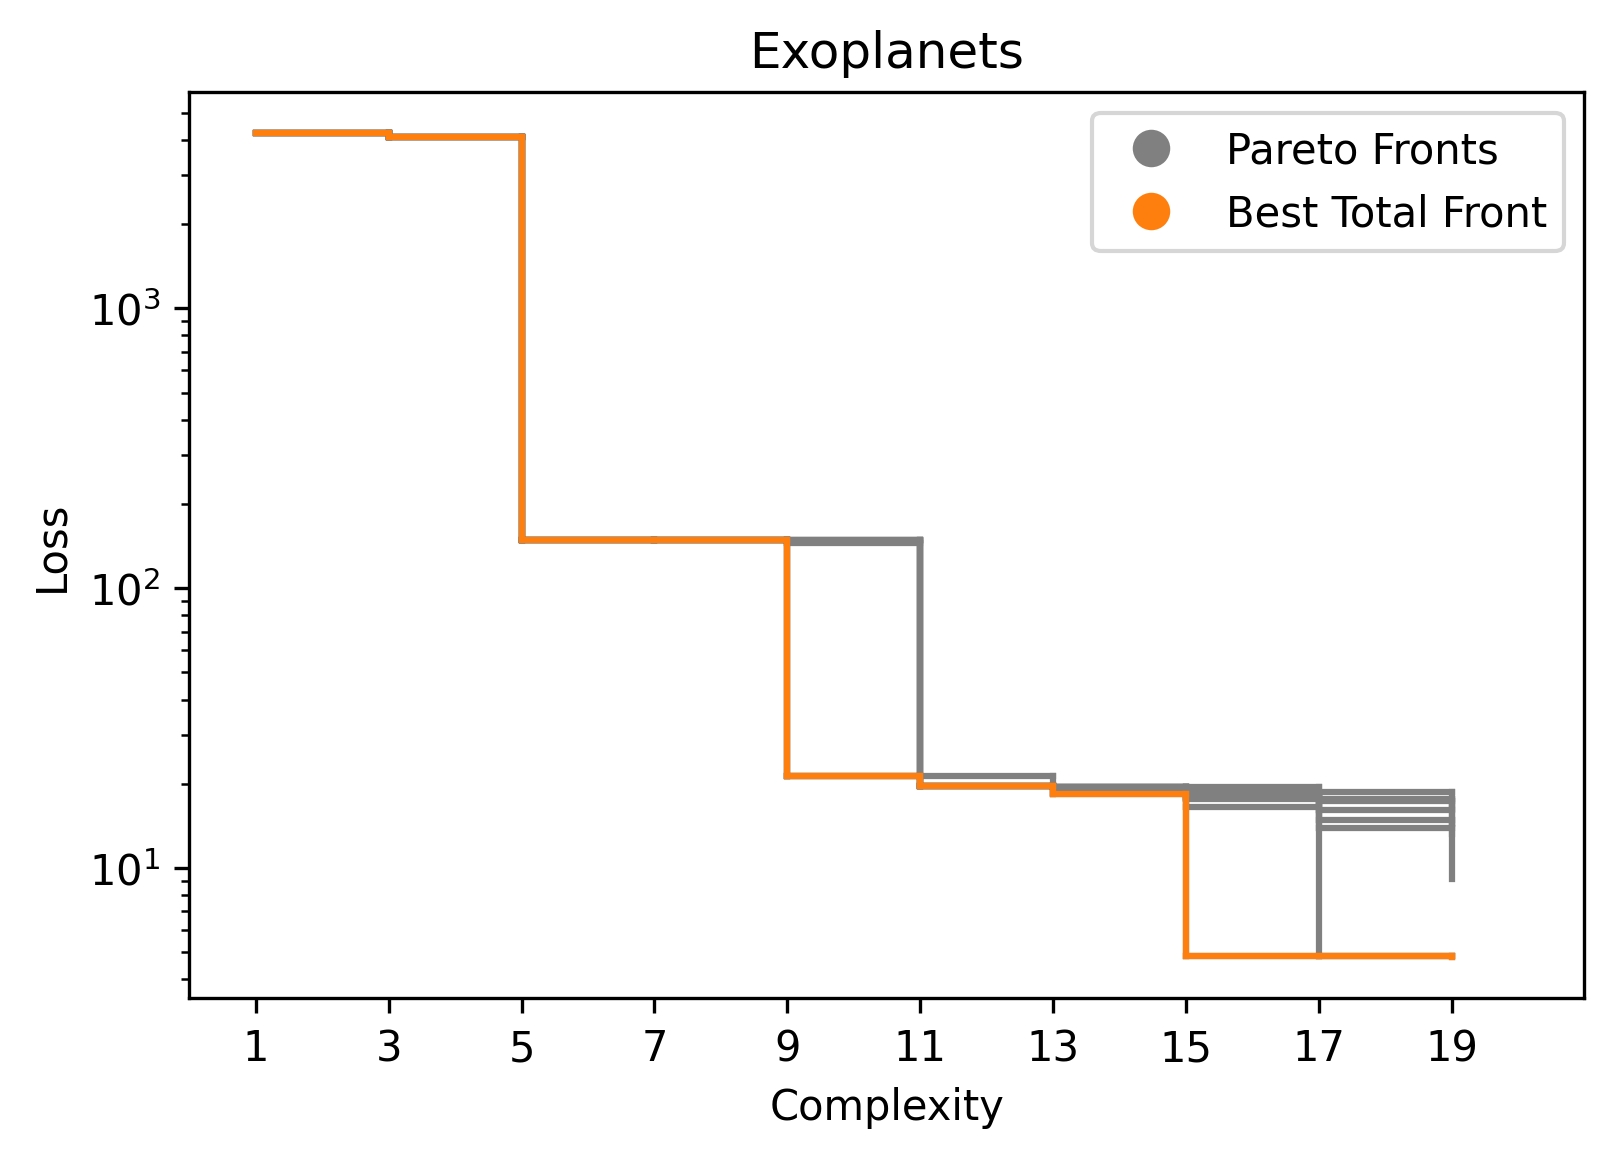

In [14]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.transforms import Affine2D
from matplotlib import *
import sympy as sp
from itertools import chain
from svgpath2mpl import parse_path
from svgpathtools import svg2paths

# complexity vs accuracy
# uses only 1 run
def plotParetoFront(run, thermo=True, stackLines=False, combineLines=False, canonical=False, canonicalPair=False, plotMinOnly=False):

    #fig, ax = plt.subplots()

    bestLossPerComplexity = pd.DataFrame()
    compVar = "minComplexity" if canonical else "complexity"
    print(compVar)
    # if min complexity col does not exist but needs to be used
    if compVar == "minComplexity" and "minComplexity" not in run:
        run["minComplexity"] = min(run["complexity"], run["canonComplexity"])

    x = run[compVar]
    y = run["loss"]
    # to keep track of best loss so far
    yMin = max(run["loss"])
    runNum = run["run"].iloc[0]
    labeled = False

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300

    # if making individual plots for each run, pick colors
    if not stackLines:
        lineColor = "grey" 
        pointGoodColor = "tab:blue"
        pointBadColor = "tab:orange"
    # otherwise pick color scheme and normalize based on number of runs
    else:
        if combineLines:
            lineColor = "grey"
        else:
            cmap = matplotlib.cm.get_cmap("hsv")
            norm = matplotlib.colors.Normalize(vmin=1, vmax=9)
            lineColor = cmap(norm(runNum+1))

    i = min(x)
    #print("starting i =", i)
    temp = i

    auc = 0

    while i < max(x):
        # find the best expression at this and the next complexity
        thisMin = run.loc[run[compVar] == i] 
        #print(thisMin)
        while thisMin.empty and i < max(x):
            i += 1
            thisMin = run.loc[run[compVar] == i] 
        # select instance with lowest loss 
        #print("This MIN:")
        #print(thisMin)
        #print("i =", i)
        thisMin = thisMin.loc[thisMin["loss"] == thisMin["loss"].min()].iloc[0]
        #print("this min loss =", thisMin["loss"])
        #bestLossPerComplexity = bestLossPerComplexity.append(run.loc[(run["minComplexity"] == i) & 
        #        (run["loss"] == thisMin["loss"])].drop_duplicates("equation"))
        bestLossPerComplexity = bestLossPerComplexity.append(thisMin)
        
        #print(bestLossPerComplexity)
    
        #print("temp before increase =", temp)
        temp = i + 1
        nextMin = run.loc[run[compVar] == temp] 
        #print(nextMin)
        #print("temp before loop =", temp)
        while nextMin.empty and temp < max(x):
            temp += 1
            #print("temp in loop =", temp)
            nextMin = run.loc[run[compVar] == temp] 

        # if could not find next min
        if nextMin.empty:
            nextMin = thisMin
        else:   
            nextMin = nextMin.loc[nextMin["loss"] == nextMin["loss"].min()].iloc[0]

        #print("next MIN:")
        #print(nextMin)
        #print("i =", i)
        #print("next min loss =", nextMin["loss"])
        #print(nextMin)

        # determine what to print out for this point
        if canonical:
            if thisMin["complexity"] < thisMin["canonComplexity"]:
                thisComp = thisMin["complexity"]
                thisEqu = thisMin["equation"]
            else:
                thisComp = thisMin["canonComplexity"]
                thisEqu = thisMin["simplified"]
            if nextMin["complexity"] < nextMin["canonComplexity"]:
                nextComp = nextMin["complexity"]
                nextEqu = nextMin["equation"]
            else:
                nextComp = nextMin["canonComplexity"]
                nextEqu = nextMin["simplified"]
        else:
            thisComp = thisMin["complexity"]
            thisEqu = thisMin["equation"]
            nextComp = nextMin["complexity"]
            nextEqu = nextMin["equation"]

        #print("iterators = ", i, "and", temp)
        #print("complexities =", thisComp, "and", nextComp)
        #print(i)
        if not stackLines:
            if i == min(x): print("Best expression at complexity {} is {} with loss {:e}".format(thisComp, thisEqu.replace(" ", ""), thisMin["loss"]))
            print("Best expression at complexity {} is {} with loss {:e}".format(nextComp, nextEqu.replace(" ", ""), nextMin["loss"]))

        # get coords needed for up/down and over lines
        x1 = i
        x2 = temp
        y1 = thisMin["loss"]
        y2 = nextMin["loss"]
        if y1 < yMin:
            yMin = y1

        # area under curve for this box is just length * width
        auc += (x2 - x1) * (y2)

        #print("x1, x2 =", x1, ",", x2)
        #print("y1, y2 =", y1, ",", y2)
        #print("yMin =", yMin)

        i = temp

        #if next complexity higher
        if yMin <= y2:
            # need to stay at this height
            #print("staying at same height")

            # format [x points], [y points].  draws line from first xy pair to second pair
            # make sure to only add label to one line segment
            if not labeled:
                # over line
                plt.plot([x1,x2], [yMin,yMin], c=lineColor) #, label="Run " + str(int(runNum + 1)))
                labeled = true
            else:
                plt.plot([x1,x2], [yMin,yMin], c=lineColor)
       
        #else same or lower
        else:
            #need to go over then down
            #print("drawing lower")
            if not labeled:
                plt.plot([x1,x2],[yMin,yMin], c=lineColor) #, label="Run " + str(int(runNum + 1)))
                labeled = True
            else:
                plt.plot([x1,x2],[yMin,yMin], c=lineColor)
            plt.plot([x2,x2],[yMin,y2], c=lineColor)
            
            yMin = y2

    #triangle = parse_path("""m 378.5,498.25 -28.8657,0.66562 -28.86571,0.66562 13.85641,-25.33124 13.85641,-25.33124 15.00929,24.66562 z""")
    #triangle.vertices -= triangle.vertices.mean(axis=0)

    triangle_path, attributes = svg2paths("svgs/triangleTest2.svg")
    #print(attributes)
    triangle = parse_path(attributes[0]['d'])
    triangle.vertices -= triangle.vertices.mean(axis=0)
    triangle = triangle.transformed(Affine2D().rotate_deg(180).scale(-1,1).translate(7,0))

    a = 1

    if not stackLines:

        if thermo:
            thermoColors = [pointBadColor, pointGoodColor]
            getColor = lambda vals: [thermoColors[1] if i else thermoColors[0] for i in vals]

            # cmap is from 0-1 so 0 = fail thermo constraints
            #plt.scatter(failing["complexity"], failing["loss"], c=pointBadColor, zorder=10, alpha=a, marker=triangle)
            #plt.scatter(passing["complexity"], passing["loss"], c=pointGoodColor, zorder=10, alpha=a, marker=triangle)

            plt.scatter(run["complexity"], run["loss"], c=getColor(run["thermo1"]), zorder=10, alpha=a, marker=(1,2,0), s=100)
            plt.scatter(run["complexity"], run["loss"], c=getColor(run["thermo2"]), zorder=10, alpha=a, marker=(1,2,240), s=100)
            plt.scatter(run["complexity"], run["loss"], c=getColor(run["thermo3"]), zorder=10, alpha=a, marker=(1,2,120), s=100)

            if canonical:
                thermoColors = ["tab:red", "tab:green"]

                # cmap is from 0-1 so 0 = fail thermo constraints
                #plt.scatter(failing["canonComplexity"], failing["loss"], c="tab:pink", zorder=10, alpha=a, marker=triangle)
                #plt.scatter(passing["canonComplexity"], passing["loss"], c="tab:green", zorder=10, alpha=a, marker=triangle)

                plt.scatter(run["canonComplexity"], run["loss"], c=getColor(run["thermo1"]), zorder=10, alpha=a, marker=(1,2,0+60), s=100)
                plt.scatter(run["canonComplexity"], run["loss"], c=getColor(run["thermo2"]), zorder=10, alpha=a, marker=(1,2,240+60), s=100)
                plt.scatter(run["canonComplexity"], run["loss"], c=getColor(run["thermo3"]), zorder=10, alpha=a, marker=(1,2,120+60), s=100)

        else:
            if plotMinOnly:
                plt.scatter(run["minComplexity"], run["loss"], c="tab:green", zorder=10, alpha=0.7, marker="+")

            else:
                plt.scatter(run["complexity"], run["loss"], c=pointGoodColor, zorder=10, alpha=0.7, marker="x")
                #plt.scatter(run["complexity"], run["loss"], c=pointGoodColor, zorder=10, alpha=a, marker=(1,2,0), s=100)
                #plt.scatter(run["complexity"], run["loss"], c=pointBadColor, zorder=10, alpha=a, marker=(1,2,120), s=100)
                #plt.scatter(run["complexity"], run["loss"], c=pointGoodColor, zorder=10, alpha=a, marker=(1,2,240), s=100)

                if canonical:
                    plt.scatter(run["canonComplexity"], run["loss"], c="tab:green", zorder=10, alpha=0.7, marker="+")
                    #plt.scatter(run["canonComplexity"], run["loss"], c="tab:green", zorder=10, alpha=a, marker=(1,2,0+60), s=100)
                    #plt.scatter(run["canonComplexity"], run["loss"], c="tab:green", zorder=10, alpha=a, marker=(1,2,120+60), s=100)
                    #plt.scatter(run["canonComplexity"], run["loss"], c="tab:red", zorder=10, alpha=a, marker=(1,2,240+60), s=100)

        # draw lines between original and canonical points
        if canonicalPair:
            startX = run["complexity"]
            startY = run["loss"]
            endX = run["canonComplexity"]
            endY = startY
            dX = endX-startX
            dY = endY-startY
            cmap = matplotlib.cm.get_cmap("RdYlGn")
            norm = matplotlib.colors.Normalize(vmin=0, vmax=pi)
            color = np.arctan2(dY, dX)
            #print(min(color))
            #print(max(color))
            color = cmap(norm(color))

            plt.quiver(startX, startY, dX, dY, scale=1, angles="xy", scale_units="xy", 
                alpha=0.3, linewidth=0.5, headwidth=3, minlength=1, color=color)

    plt.xticks(range(1, 20, 2))
    plt.xlim(0, 21)
    #plt.xticks(np.arange(min(x), max(max(run["complexity"])+1, max(run["canonComplexity"])+1, 20), 1.0))
    plt.yscale("log")
    #plt.yticks([1e-5,1e-4,1e-3, 1e-2, 1e-1, 1])

    # Title!
    plt.title("Methane Crossover=1.0")
    plt.xlabel("Complexity")
    plt.ylabel("Loss")

    print("AUC =", auc)

    #plot each plot if not stacking all pareto fronts
    if not stackLines:
        # custom legend to explain points
        if thermo:
            if canonical:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointGoodColor, label="Passing"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointBadColor, label="Failing"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:green", label="Passing (Canonical)"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:pink", label="Failing (Canonical)")]

                #t1 = ax.plot([0], [0], marker=(1,2,0), color="w", markersize=10,
                #markerfacecolor=pointGoodColor)
                #t2 = ax.plot([0], [0], marker=(1,2,240), markersize=10,
                #markerfacecolor=pointGoodColor)

                #legend_elements = [(t1, t2)]

            else:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointGoodColor, label="Passing"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointBadColor, label="Failing")]

            #plt.legend(legend_elements, ["test"], title="Thermo Constraints")
            
        elif canonical:
            if plotMinOnly:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:green", label="Min Complexity")]
                plt.legend(handles=legend_elements, loc="upper right")
            else:
                legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor=pointGoodColor, label="Original"),
                    Line2D([0], [0], marker="o", color="w", markersize=10,
                markerfacecolor="tab:green", label="Simplified")]
                plt.legend(handles=legend_elements, title="Original Vs Simplified Form")

        #else:
        #    legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
        #    markerfacecolor=pointGoodColor, label="Passing"),
        #        Line2D([0], [0], marker="o", color="w", markersize=10,
        #    markerfacecolor=pointBadColor, label="Failing")]
        
        plt.grid()
        #plt.show()

    bestLossPerComplexity = bestLossPerComplexity.append(nextMin)
    #print("best loss per comp =", bestLossPerComplexity)
    return(bestLossPerComplexity, auc)


#############################
# CHANGE THINGS HERE
#############################

# Expects list of dataframes ("runs") each having cols ["equation", "loss", "complexity"]

# change this to change mode
thermo = True # Expects ["thermo1-3"]
stackLines = True
combineLines = True
canonical = True # Expects ["simplified", "canonComplexity", "minComplexity"] and ["canonThermoVals"] if thermo also true
canonicalPair = True # Expects all cols needed for canonical
plotMinOnly = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

bestExpressions = pd.DataFrame()
i = 1
#for run in [runs[7]]:
#for run in [runs[0], runs[1]]:
#for run in runs:
name, expItem = list(experiment.items())[0]
print(name)
aucAvg = 0
for run in expItem:

    if not stackLines:
        print("\n" + "="*15, "\nRun", i, "\n" + "="*15)
    #print(run)

    best, auc = plotParetoFront(run, thermo, stackLines, combineLines, canonical, canonicalPair, plotMinOnly)
    #print(best)
    bestExpressions = bestExpressions.append(best)

    #plt.savefig("run{}.png".format(i))
    i += 1

# need to plot after the fact if stacking lines
if stackLines:
    if combineLines:
        lineColor = "tab:orange"
        yMin = max(bestExpressions["loss"])
        #print(bestExpressions)
       
        # for all complexities, plot new total pareto front
        i = min(bestExpressions["complexity"])
        temp = i
        while i < max(bestExpressions["complexity"]):
            # find the best expression at this and the next complexity
            thisMin = bestExpressions.loc[bestExpressions["minComplexity"] == i] 
            while thisMin.empty and i < max(bestExpressions["complexity"]):
                i += 1
                thisMin = bestExpressions.loc[bestExpressions["minComplexity"] == i] 
            # select instance with lowest loss 
            #print(thisMin)
            thisMin = thisMin.loc[thisMin["loss"] == thisMin["loss"].min()].iloc[0]
        
            temp = i + 1
            nextMin = bestExpressions.loc[bestExpressions["minComplexity"] == temp]
            while nextMin.empty and temp < max(bestExpressions["complexity"]):
                temp += 1
                nextMin = bestExpressions.loc[bestExpressions["minComplexity"] == temp] 

            # if could not find next min
            if nextMin.empty:
                nextMin = thisMin
            else:   
                nextMin = nextMin.loc[nextMin["loss"] == nextMin["loss"].min()].iloc[0]

            if thisMin["complexity"] < thisMin["canonComplexity"]:
                thisComp = thisMin["complexity"]
                thisEqu = thisMin["equation"]
            else:
                thisComp = thisMin["canonComplexity"]
                thisEqu = thisMin["canonEquation"]
            if nextMin["complexity"] < nextMin["canonComplexity"]:
                nextComp = nextMin["complexity"]
                nextEqu = nextMin["equation"]
            else:
                nextComp = nextMin["canonComplexity"]
                nextEqu = nextMin["canonEquation"]

            #print("iterators = ", i, "and", temp)
            #print("complexities =", thisComp, "and", nextComp)
            if i == 1: print("Best at complexity {} is {} with loss {:e}".format(thisComp, thisEqu.replace(" ", ""), thisMin["loss"]))
            print("Best at complexity {} is {} with loss {:e}".format(nextComp, nextMin["equation"].replace(" ", ""), nextMin["loss"]))
            #print("Best at complexity {} is {} or {} with loss {:e}".format(nextComp, nextMin["equation"].replace(" ", ""), nextMin["canonEquation"].replace(" ", ""), nextMin["loss"]))

            # get coords needed for up/down and over lines
            x1 = i
            x2 = temp
            y1 = thisMin["loss"]
            y2 = nextMin["loss"]
            if y1 < yMin:
                yMin = y1
            i = temp

            #if next complexity higher
            if yMin <= y2:
                plt.plot([x1,x2], [yMin,yMin], c=lineColor)
        
            #else same or lower
            else:
                #need to go over then down
                plt.plot([x1,x2],[yMin,yMin], c=lineColor)
                plt.plot([x2,x2],[yMin,y2], c=lineColor)
                yMin = y2

        # other combined pareto front stuff

        # binary stars
        #plt.scatter(7, 4.771, c="tab:blue", zorder=100)
        #plt.plot([7,20], [4.771, 4.771], c="tab:blue")
        #plt.annotate("sqrt(cube(d)/(m1+m2))", (7, 4.771), xytext=(0.5,0.7), c="tab:blue")

        # binary stars norm
        #plt.scatter(9, 35.80964194460454, c="tab:blue", zorder=100)
        #plt.plot([9,20],[35.80964194460454,35.80964194460454])
        #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (7, 4.771), xytext=(1,8), color="tab:blue")
        #plt.scatter(11, 2.46, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d)*((c1/m1)-(c2/m2)))", (11, 2.46), xytext=(1,0.5))

        # exoplanets
        #plt.scatter(5, 7.792000e-04, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d*-0.509011))", (5, 7.792000e-04), xytext=(5.5, 1.5e-3))
        #plt.scatter(7, 1.180000e-04, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d*0.509012)/m1)", (7, 1.180000e-04), xytext=(7.5, 3e-4))
        #plt.scatter(9, 4.027, c="tab:blue", zorder=100)
        #plt.plot([9,20], [4.027,4.027], c="tab:blue")
        #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (9, 4.027), xytext=(9, 15), color="tab:blue")

        # exoplanets norm


        # solar
        #plt.scatter(3, 6.608000e-02, c="tab:blue", zorder=100)
        #plt.annotate("c1*d (canonical form)", (3, 6.608000e-02), xytext=(5.5, 8e-2))
        #plt.scatter(5, 2.945000e-04, c="tab:blue", zorder=100)
        #plt.annotate("sqrt(cube(d)*0.13188303)", (5, 2.945000e-04), xytext=(5.5, 5e-4))
        #plt.scatter(9, 10, c="tab:blue", zorder=100)
        #plt.plot([9,20], [10,10], c="tab:blue")
        #plt.annotate("c1*sqrt(cube(d)/(m1+m2))", (9, 10), xytext=(9, 15), color="tab:blue")

        legend_elements = [Line2D([0], [0], marker="o", color="w", markersize=10,
            markerfacecolor="grey", label="Pareto Fronts"),
            Line2D([0], [0], marker="o", color="w", markersize=10,
            markerfacecolor="tab:orange", label="Best Total Front")]#,
            #Line2D([0], [0], marker="o", color="w", markersize=10,
            #markerfacecolor="tab:blue", label="Ground Truth")]
        plt.legend(handles=legend_elements)
        plt.title("Exoplanets")

    else:
        #plt.title("IBM Solar Results")
        plt.grid()
        plt.legend()
        #plt.show()

50
0
8
3
36
1
39
11


C:\Users\ipunc\AppData\Local\Temp/ipykernel_27840/392100541.py:88: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


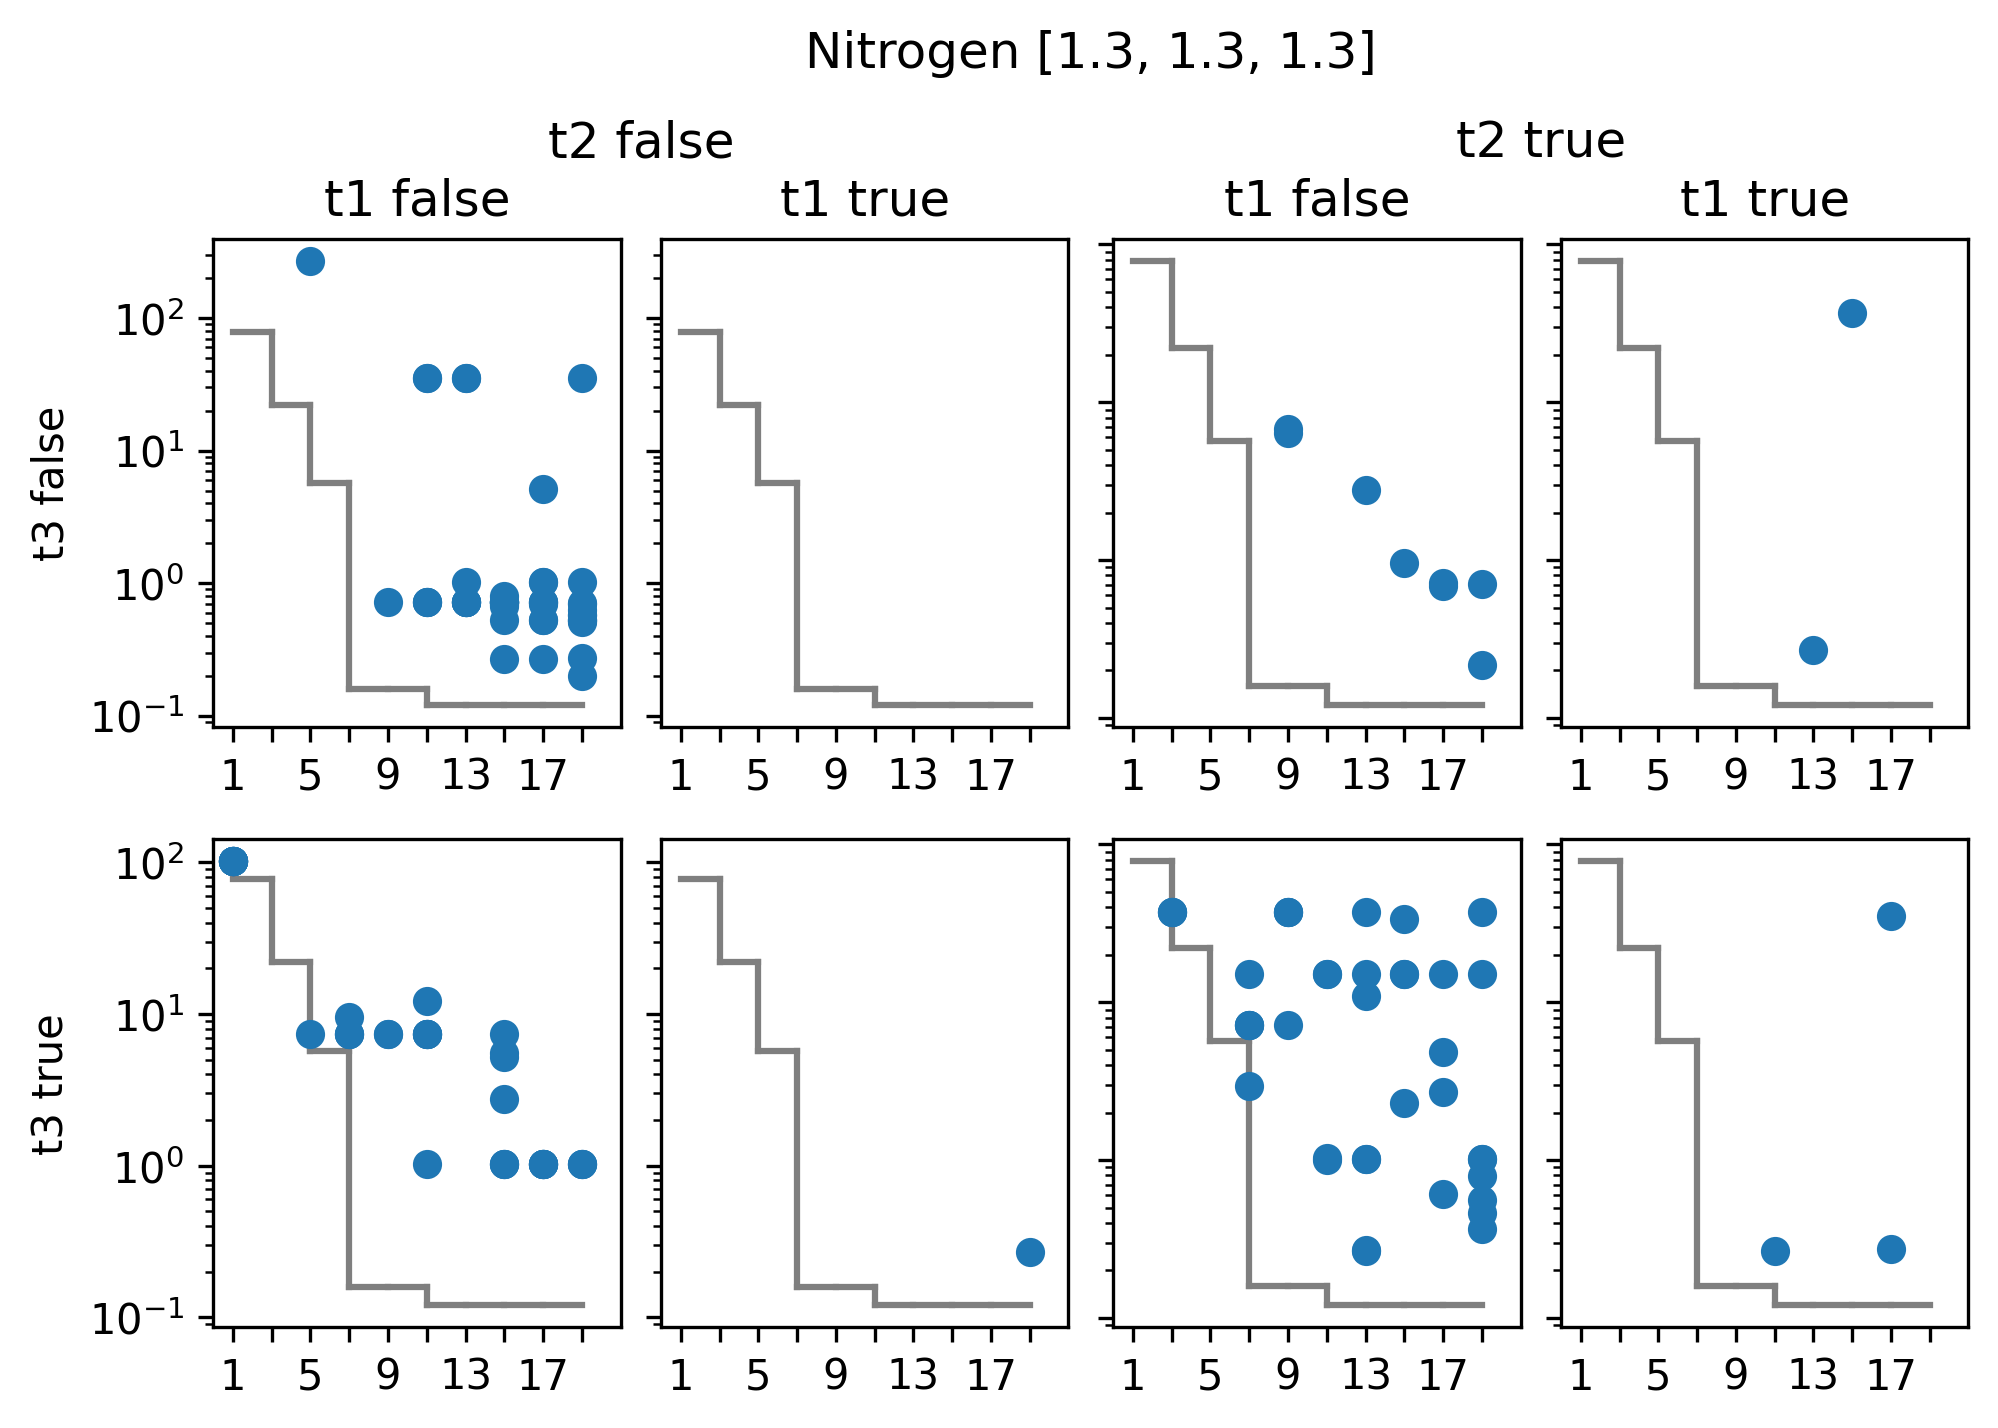

In [597]:
# small multiples plot for showing all thermo vals across a run or set of runs

canonical = False

runs = list(experiment.values())[12]

# combine runs
combined = runs[0].append(runs[1])
for i in range(2, len(runs)):
    #print(len(data))
    combined = combined.append(runs[i])

# expects min pareto front from above cell

#fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)
#print(shape(axes))
fig = plt.figure(constrained_layout=True)
subfigs = fig.subfigures(2, 2)
plots = []
for i, subfig in enumerate(subfigs.flat):

    if i == 0:
        subfig.suptitle("t2 false", y=1.05)
    if i == 1:
        subfig.suptitle("t2 true", y=1.05)
    
    axes = subfig.subplots(1, 2, sharex=True, sharey=True, squeeze=True)
    
    # remove x ticks from first row
    #if i < 2:
    #    for ax in axes:
    #        ax.set_xticklabels([])
    
    plots.append(axes[0])
    plots.append(axes[1])



i = 0
for ax in plots:
    #print(i)
    noY = True if i % 4 == 3 else False
    combinedPareto(bestExpressions, ax, noY)
    ax.autoscale(False)

    points = combined.loc[
        sum([combined["thermo1"], 2*combined["thermo2"], 4*combined["thermo3"]]) == i]
    #ax.scatter(points["minComplexity"], points["loss"])
    print(len(points))

    thermoColors = ["tab:orange", "tab:blue"]
    a = 1
    getColor = lambda vals: [thermoColors[1] if i else thermoColors[0] for i in vals]

    # cmap is from 0-1 so 0 = fail thermo constraints
    #plt.scatter(failing["complexity"], failing["loss"], c=pointBadColor, zorder=10, alpha=a, marker=triangle)
    ax.scatter(points["complexity"], points["loss"], c="tab:blue", zorder=10, alpha=a)

    #ax.scatter(points["complexity"], points["loss"], c=getColor(points["thermo1"]), zorder=10, alpha=a, marker=(1,2,0), s=100)
    #ax.scatter(points["complexity"], points["loss"], c=getColor(points["thermo2"]), zorder=10, alpha=a, marker=(1,2,240), s=100)
    #ax.scatter(points["complexity"], points["loss"], c=getColor(points["thermo3"]), zorder=10, alpha=a, marker=(1,2,120), s=100)

    if canonical:
        thermoColors = ["tab:red", "tab:green"]

        # cmap is from 0-1 so 0 = fail thermo constraints
        #plt.scatter(failing["canonComplexity"], failing["loss"], c="tab:pink", zorder=10, alpha=a, marker=triangle)
        ax.scatter(points["canonComplexity"], points["loss"], c="tab:green", zorder=10, alpha=a)
        
        #ax.scatter(points["canonComplexity"], points["loss"], c=getColor(points["thermo1"]), zorder=10, alpha=a, marker=(1,2,0+60), s=100)
        #ax.scatter(points["canonComplexity"], points["loss"], c=getColor(points["thermo2"]), zorder=10, alpha=a, marker=(1,2,240+60), s=100)
        #ax.scatter(points["canonComplexity"], points["loss"], c=getColor(points["thermo3"]), zorder=10, alpha=a, marker=(1,2,120+60), s=100)


    if i == 0: 
        ax.set_ylabel("t3 false")
    if i == 4:
        ax.set_ylabel("t3 true")
    if i < 4:
        if i % 2 == 0:
            ax.set_title("t1 false")
        else:
            ax.set_title("t1 true")

    i += 1


plt.tight_layout()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.suptitle("Nitrogen [1.3, 1.3, 1.3]", y=1.1)
fig.subplots_adjust(wspace=0.1, hspace=0)
fig.subplots_adjust(top=0.85)

In [27]:
print(points.head(10))

    run  progress  runtime  complexity      loss         score  \
0   0.0       2.0    0.071         1.0  1630.000 -9.651000e-01   
2   0.0      32.0    0.321         7.0     6.675  1.378000e+00   
3   0.0       2.0    0.071        19.0    31.340  1.244000e-01   
17  1.0     319.0    0.075         1.0  1630.000 -9.651000e-01   
21  1.0       2.0    1.177        11.0     3.690  8.328000e-01   
22  1.0       2.0    1.177        13.0     3.690  1.861000e-07   
41  2.0     319.0    0.333         1.0  1630.000 -9.651000e-01   
53  3.0     319.0    0.049         1.0  1630.000 -9.651000e-01   
77  4.0     319.0    1.043         1.0  1630.000 -9.651000e-01   
83  4.0       4.0    0.206        19.0     3.690  1.488000e+00   

                                                                                                equation  \
0                                                                                                      p   
2                                                        

In [358]:
#f = open("otherDatasets/binaryStarsNormalized.csv", "r")
#f = open("otherDatasets/binaryStars.csv", "r")
#f = open("otherDatasets/exoplanets.csv", "r")
f = open("otherDatasets/solar.csv", "r")
lines = f.readlines()
# take all rows of csv, remove first line, remove "\n", split into cols by ",", and cast to np array
dataset = np.array([line.strip().split(",") for line in lines[1:]])
#print(data)
m1=[float(i) for i in dataset[:,0]]
m2=[float(i) for i in dataset[:,1]]
d=[float(i) for i in dataset[:,2]]
t=[float(i) for i in dataset[:,3]]
#print(t)

#loss = sum((  ((d)**3/(m1 + m2))**0.5   - t   )**2) / len(t)
loss = 0
for i in range(len(t)):
    #print((((1/0.365)*((d[i])**3/(m1[i] + m2[i]))**0.5)    -  t[i])**2)
    #loss += (  ((1/0.365)*((d[i])**3/(m1[i] + m2[i]))**0.5)    -  t[i]  )**2
    #print(((d[i])**3/(m1[i] + m2[i]))**0.5    -  t[i])
    loss += (  (((d[i])**3/(m1[i] + m2[i]))**0.5)    -  t[i]  )**2
loss /= len(t)
print("Loss:")
print(loss)
print(loss*(0.365**2))

Loss:
75.85065957976086
10.105204122513639


In [92]:
for run in runs:
    test = run.loc[(run["loss"] == 0)]
    if not test.empty:
        print(test)

        run  progress  complexity  loss  score  \
20851  11.0      37.0        17.0   0.0  4.605   

                                                                                             equation  \
20851  ((((( d - (cube( m2) * 5.974137)) - 12.245475) - (-10.827757 / square( m2))) * 7.1389675) + d)   

                                 canonEquation        parameters  \
20851  c1 + c2*d + c3/square(m2) + c4*cube(m2)  [c0, c1, c2, c3]   

       canonComplexity  minComplexity  
20851             15.0           15.0  


In [29]:
run = runs[7]
rows = run.loc[(run["canonComplexity"]==20)][["equation", "complexity", "canonEquation", "canonComplexity"]].to_string()
print(len(rows))
print(rows)
#print(run.loc[(run["canonComplexity"]>=20)][["equation", "complexity", "canonEquation", "canonComplexity"]].to_string())

24575
                                                                                                      equation  complexity                                       canonEquation  canonComplexity
40794                                    (73.53277 + ((0.30476272 * p) + (-160.76059 / (p + (2.563466 / p)))))          13         (c1 + c2*p**2 + c3*p**3 + c4*p)/(c5 + p**2)               23
40795                   (73.75957 + ((0.30476272 * p) + (-160.76059 / (-0.16286984 + (p + (2.6813898 / p))))))          15  (c1 + c2*p**2 + c3*p + c4*p**3)/(c5 + c6*p + p**2)               27
40806                                    (73.53277 + ((0.30476272 * p) + (-160.76059 / (p + (2.563466 / p)))))          13         (c1 + c2*p**2 + c3*p**3 + c4*p)/(c5 + p**2)               23
40807                   (73.75957 + ((0.30476272 * p) + (-160.76059 / (-0.16286984 + (p + (2.6813898 / p))))))          15  (c1 + c2*p**2 + c3*p + c4*p**3)/(c5 + c6*p + p**2)               27
40814                   (73.75957 

In [107]:
run = runs[4]
print(run.loc[(run["complexity"]==13) & (run["thermoVals"]==1)][["equation", "loss", "thermoVals"]].to_string())

                                                                      equation    loss  thermoVals
18440  ((0.025954898 * p) + ((6.8469653 * p) / (1.098212 + (0.18129864 * p))))  0.1186           1
18547  ((0.025954898 * p) + ((6.8469653 * p) / (1.098212 + (0.18129864 * p))))  0.1186           1
18553  ((0.025954898 * p) + ((6.8469653 * p) / (1.098212 + (0.18129864 * p))))  0.1186           1
18559  ((0.025954898 * p) + ((6.8469653 * p) / (1.098212 + (0.18129864 * p))))  0.1186           1
18565   ((0.02597903 * p) + ((14.020684 * p) / (2.248723 + (0.37126374 * p))))  0.1186           1
18571  ((0.025918387 * p) + ((23.249525 * p) / (3.7290874 + (0.6155927 * p))))  0.1186           1
18577  ((0.025954898 * p) + ((6.8469653 * p) / (1.098212 + (0.18129864 * p))))  0.1186           1
18583  ((0.025984868 * p) + ((18.67909 * p) / (2.9959326 + (0.49462014 * p))))  0.1186           1
18589  ((0.025984868 * p) + ((18.67909 * p) / (2.9959326 + (0.49462014 * p))))  0.1186           1
18595  ((0

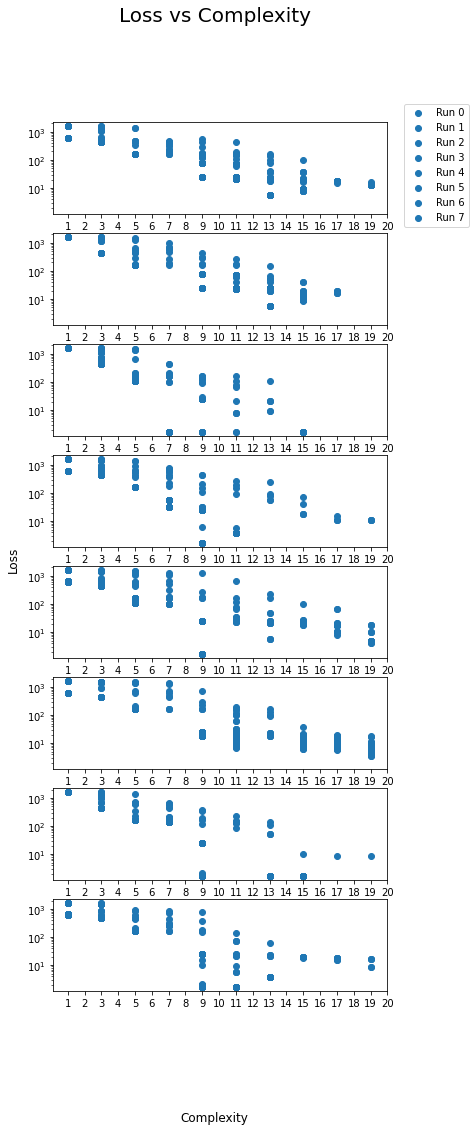

In [45]:
if numRuns > 1:
    fig, axs = plt.subplots(numRuns ,sharex=True, sharey=True, figsize=(6,2*numRuns))
    colors = ["red", "blue", "green", "yellow"]

    for i in range(numRuns):
        axs[i].scatter(runs[i]["complexity"], runs[i]["loss"], label="Run " + str(i))
        axs[i].set_yscale("log")
        axs[i].tick_params(axis="x", labelbottom=True)

    plt.xticks(range(1,21))
    fig.supylabel("Loss")
    fig.supxlabel("Complexity")
    fig.suptitle("Loss vs Complexity", fontsize=20)
    fig.legend(loc="upper right", bbox_to_anchor=(1.1, 0.9))
else:
    i = 0
    plt.scatter(runs[i]["complexity"], runs[i]["loss"], label="Run " + str(i))
    plt.yscale("log")
    plt.xticks(range(1,21))


2


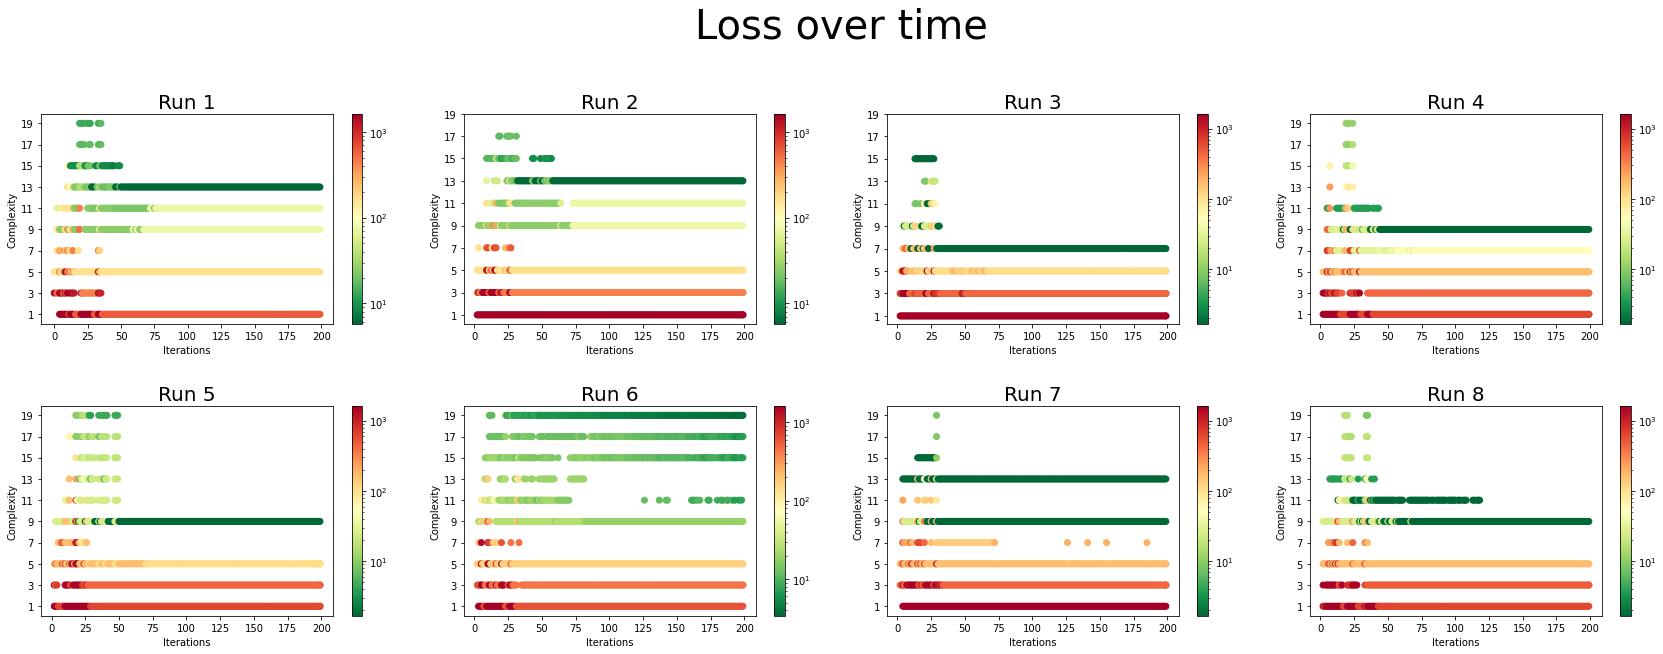

In [46]:
# only works properly for more than 4 runs

print(math.ceil(numRuns/4))
fig = plt.figure(figsize=(24, math.ceil(numRuns/4)*4+1.5))
fig.suptitle("Loss over time", size=40)

for i in range(numRuns):
    run = runs[i]
    ax = fig.add_subplot(math.ceil(numRuns/4), 4, i+1)
    scatter = ax.scatter(run["progress"], run["complexity"], c=run["loss"], norm=matplotlib.colors.LogNorm(), cmap="RdYlGn_r")
    fig.colorbar(scatter, ax=ax)
    ax.set_yticks(range(1,21, 2))
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Complexity")
    ax.set_title("Run " + str(i+1), size=20)

fig.tight_layout(pad=3.0)
plt.show()

2


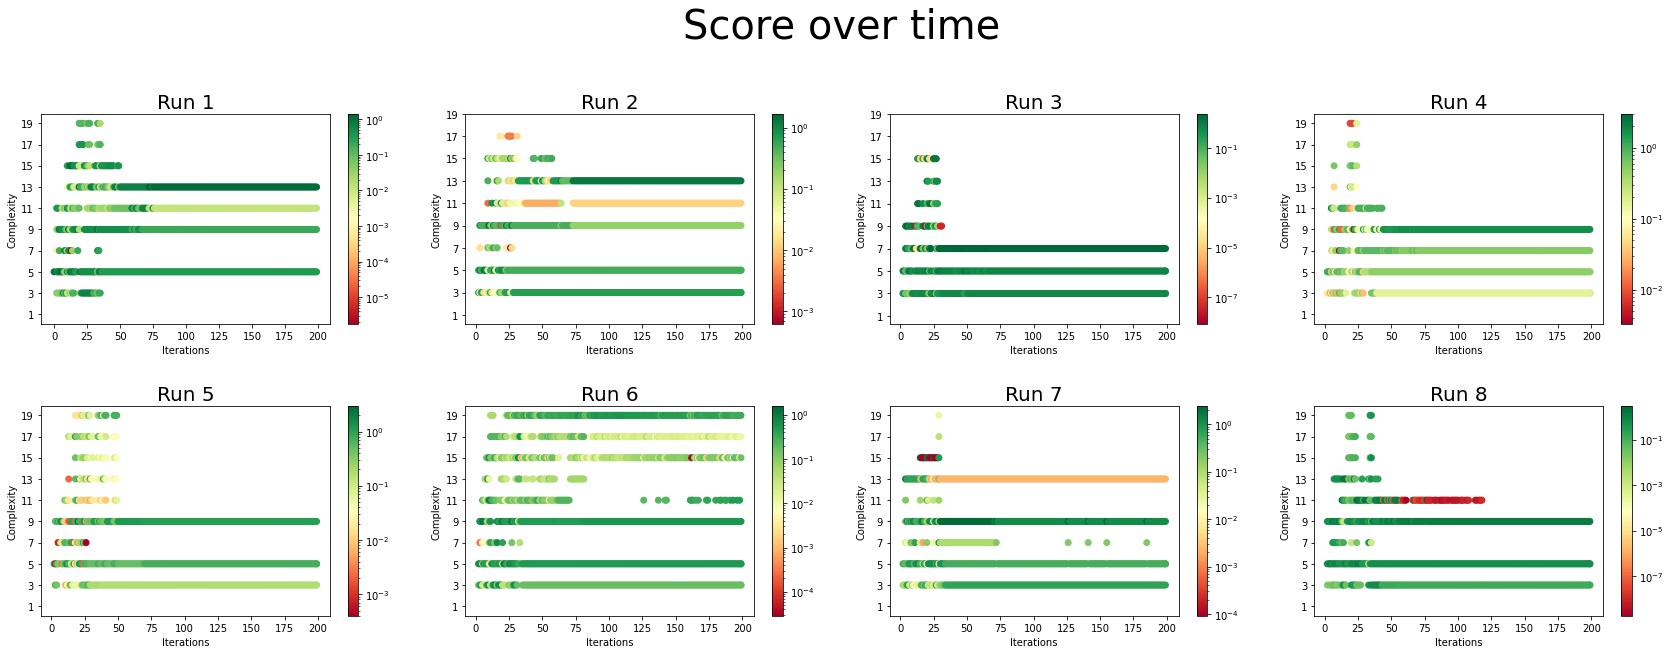

In [47]:
# only works properly for more than 4 runs

print(math.ceil(numRuns/4))
fig = plt.figure(figsize=(24, math.ceil(numRuns/4)*4+1.5))
fig.suptitle("Score over time", size=40)

for i in range(numRuns):
    run = runs[i]
    ax = fig.add_subplot(math.ceil(numRuns/4), 4, i+1)
    scatter = ax.scatter(run["progress"], run["complexity"], c=run["score"], norm=matplotlib.colors.LogNorm(), cmap="RdYlGn")
    fig.colorbar(scatter, ax=ax)
    ax.set_yticks(range(1,21, 2))
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Complexity")
    ax.set_title("Run " + str(i+1), size=20)

fig.tight_layout(pad=3.0)
plt.show()

Text(0.5, 1.0, 'Loss over time')

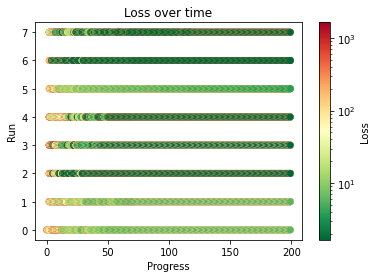

In [48]:
scatter = plt.scatter(data["progress"], data["run"], c=data["loss"], norm=matplotlib.colors.LogNorm(), cmap="RdYlGn_r")
colorbar = plt.colorbar()
colorbar.set_label("Loss")
plt.ylabel("Run")
plt.xlabel("Progress")
plt.title("Loss over time")

Text(0.5, 1.0, 'Score over time')

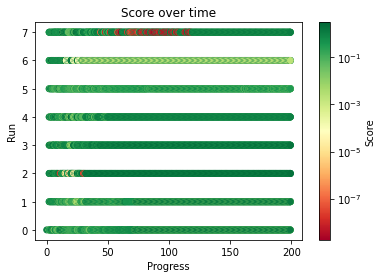

In [49]:
scatter = plt.scatter(data["progress"], data["run"], c=data["score"], norm=matplotlib.colors.LogNorm(), cmap="RdYlGn")
colorbar = plt.colorbar()
colorbar.set_label("Score")
plt.ylabel("Run")
plt.xlabel("Progress")
plt.title("Score over time")

In [22]:
numCols = 12
fixedLines = []
buffer = []
with open("adsorptionDatasets/All_Models056324.txt", "r") as fp:
    lines = fp.readlines()
    for index, line in enumerate(lines):
        thisLine = line.strip().split(",")
        #print(thisLine)
        buffer.extend(thisLine)
        #print(buffer)
        if (len(buffer) >= numCols):
            fixedLines.append(",".join(buffer[0:numCols]))
            buffer = buffer[numCols+1:]


print(fixedLines[:20])

with open("adsorptionDatasets/All_Models056324TEST.csv", "w") as fp:
    for line in fixedLines:
        fp.write(line + "\n")

['Model,Canonical form,Total num ops,Description length,EB,EP,SSE,TC Bool,Axiom,_a0_,_a1_,_a2_', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615', '((p * _a2_) / (_a3_ + p)),((p*_a2_)/(_a3_+p)),0,5.15619,5.15619,0.0,1.34894,True,0,1.0,1.0,38.893620468843615',

In [74]:
# RUN THIS CELL TO IMPORT BMS DATA
# turn BMS data to proper format

run = pd.read_csv("adsorptionDatasets/BMSIsoT8.csv", float_precision=None)

#print(run["Total num ops"])

run["complexity"] = [2*int(n) + 1 for n in run["Total num ops"]]

#print(run[["Total num ops","complexity"]][1100:1150])
run["equation"] = run["Model"]
#print(run["equation"])
run["loss"] = [float(n)/17 for n in run["SSE"]]
#print(min(run["SSE"]/17))
#print(min(run["loss"]))
run["run"] = 0

run = run[run["complexity"] <= 19]

runs = [run]


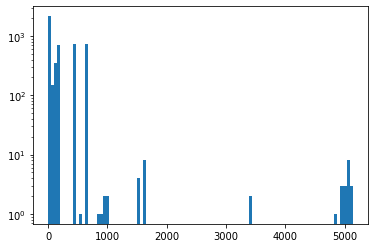

In [18]:
plt.hist(data["loss"], bins=100)
plt.yscale('log')


In [308]:
run = runs[1].loc[runs[1]["complexity"] == 9].sort_values(["loss"]).drop_duplicates("equation")
run.to_csv("run1.csv")

#for i in run.iterrows():
    #print(i)

#print(thermo("((((p + 6.013593) / 1.5807436) - (1.6875033 / (p + -2.5150871))) + 11.592429)", "p"))

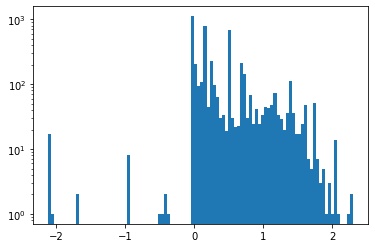

In [19]:
plt.hist(data["score"], bins=100)
plt.yscale('log')

In [54]:
import numpy as np
import sympy
from mpl_toolkits import mplot3d
# Dataset
f = open("adsorptionDatasets/Langmuir1918methane.csv", "r")
lines = f.readlines()
# take all rows of csv, remove first line, remove "\n", split into cols by ",", and cast to np array
lang = np.array([line.strip().split(",") for line in lines[1:]])
#print(data)
t=[float(i) for i in lang[:,0]]
p=[float(i) for i in lang[:,1]]
q=[float(i) for i in lang[:,2]]



plt.figure()
ax = plt.axes(projection="3d")
ax.scatter3D(t, p, q)
ax.set_xlabel("T")
ax.set_ylabel("p")
ax.set_zlabel("q")
plt.title("isobutane dataset with (((((x2 + 381.8139) / x1) + -0.3317595) / 0.46124312) + -1.277317)")



#p = np.linspace(0,120)
#q = 109.49531310787*p/(p + 8.5314045)
#ax.plot(p,q,"g")

x1range = np.linspace(275,425,100)
x2range = np.linspace(0,125,100)

x1, x2 = np.meshgrid(x1range,x2range)
# (0.50227493 + (p / T))
#z = (0.50227493 + (x2 / x1))
# (((((p + 381.8139) / T) + -0.3317595) / 0.46124312) + -1.277317)
#z = (((((x2 + 381.8139) / x1) + -0.3317595) / 0.46124312) + -1.277317)
# (((T / ((T - 1.1048504) - p)) - 0.31004283) * 0.8606838)
z = (((x1 / ((x1 - 1.1048504) - x2)) - 0.31004283) * 0.8606838)

#print(x1)
#print(x2)
#print(z)

ax.contour3D(x1, x2, z)

plt.show()
#(p+c)/(p*c)

IndexError: index 2 is out of bounds for axis 1 with size 2

In [93]:
bestExpressions = [
    # METHANE
    #["((p * 96.60663) / (p + 6.492238))", "PySR, t:T, cx:7"],
    #["(((p / 9.3991) + 97.30487) / ((p - -6.5954676) / p))", "PySR, t:F, cx:11"]
    
    # NITROGEN
    #["((p / ((p * 0.77635926) - (p + 1.41192))) / -0.11496651)", "PySR, t:F, cx:11"],
    #[" (p / ((p / 38.89353) + 0.16232336))", "PySR, t:T, cx:7"]
    #["(112.62212 + (-1254.1503 / (12.707094 + p)))", "PySR, t:T, cx:7"]

    #["(24.668386 + ((0.30265284 * p) + (-40.939415 / p)))", "PySR, t:F, cx:9"]

    # ISOBUTANE
    #["((p / (p - -5.8552856)) + 0.6757802)", "PySR, t:F, cx:7"],
    #["((0.5793241 - (p - (p / (p + 2.19605)))) + p)", "PySR, t:T, cx:11"]

    #["(0.75175273 + (p / (8.05637 + p)))", "PySR, t:F, cx:7"],
    #["(0.72398984 + ((0.24411264 + p) / (7.481124 + p)))", "PySR, t:F, cx:9"]

    #["((((p + 0.9007795) + (p * 0.06023597)) / ((p / 1.0314271) + 5.653899)) + 0.5756432)", "PySR, t:0.4, cx:15"],
    #["(0.61812943 + (p / ((0.904257 * p) + ((2.1053333 * p) / (0.33327952 + (0.35576582 * p))))))", "PySR, t:0.4, cx:17"]

    #["((((( d - (cube( m2) * 5.974137)) - 12.245475) - (-10.827757 / square( m2))) * 7.1389675) + d)"]
    ["((((( d - (m2**3 * 5.974137)) - 12.245475) - (-10.827757 / m2**2)) * 7.1389675) + d)", "PySR, cx:15"]

]

[['0.54' ' 0.50' ' 107.207' ' 1089.0']
 ['1.33' ' 1.41' ' 38.235' ' 143.1']
 ['0.88' ' 0.82' ' 113.769' ' 930.0']
 ['3.06' ' 1.97' ' 131.352' ' 675.5']]


TypeError: can't convert expression to float

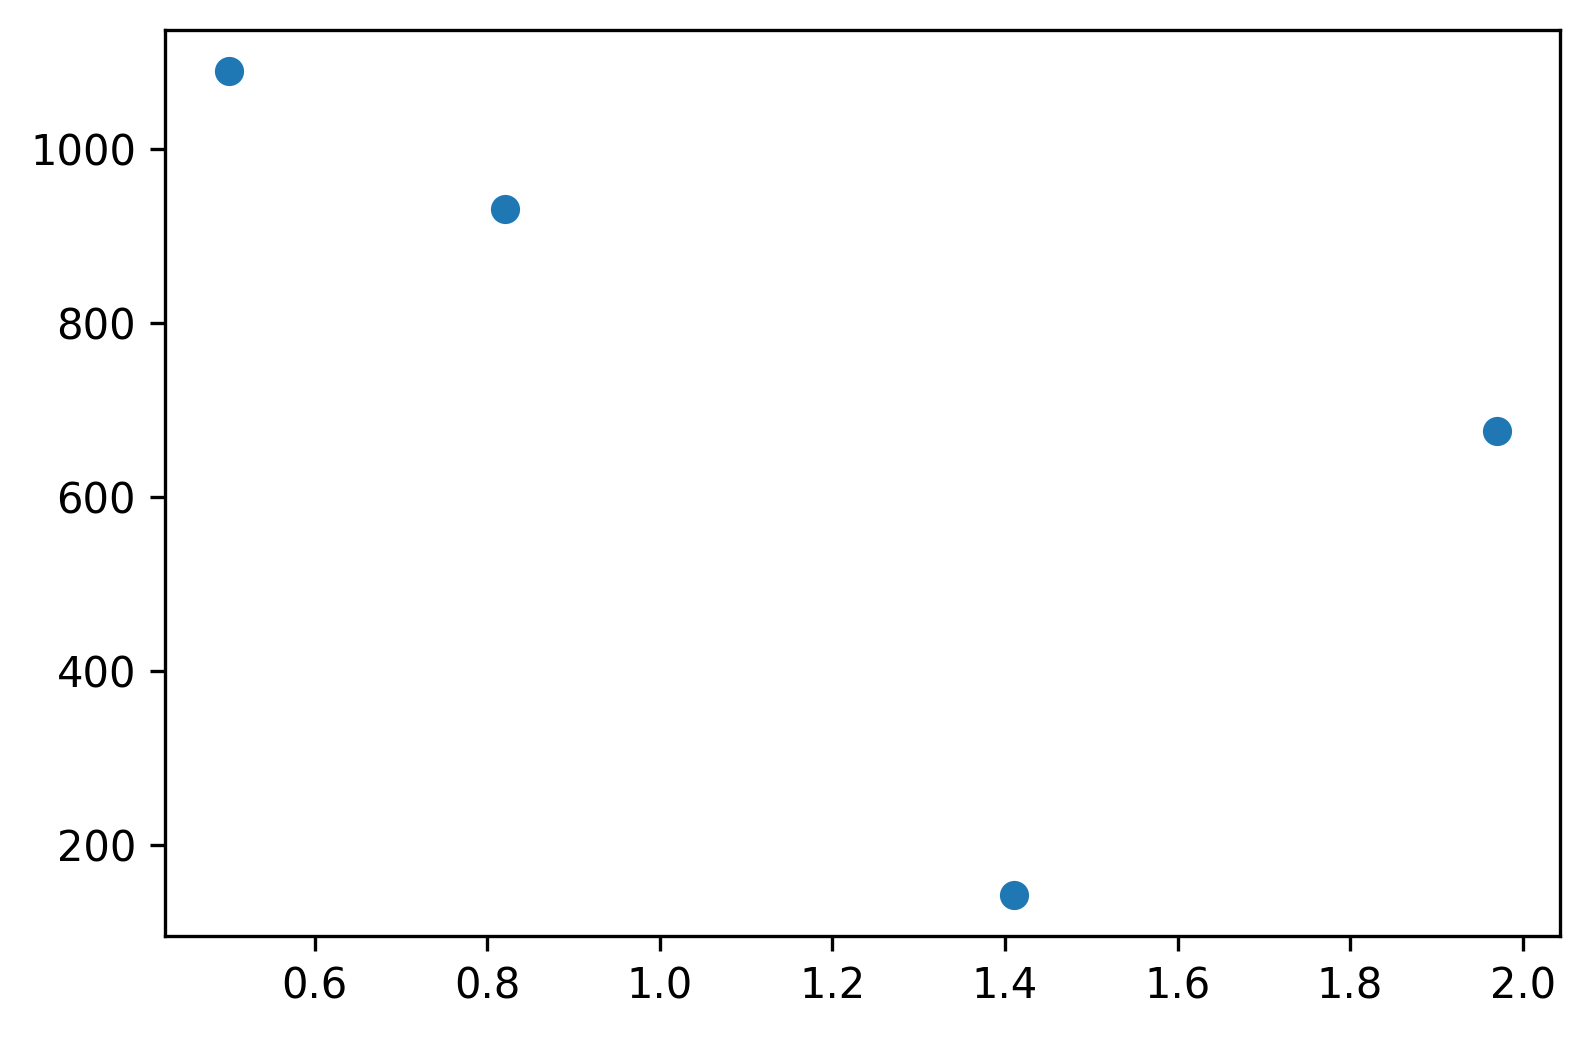

In [96]:
# Dataset
#f = open("adsorptionDatasets/isobutaneT277.csv", "r")
#f = open("adsorptionDatasets/Langmuir1918methane.csv", "r")
#f = open("adsorptionDatasets/Langmuir1918nitrogen.csv", "r")
f = open("otherDatasets/binaryStars.csv", "r")
iso = False
lines = f.readlines()
# take all rows of csv, remove first line, remove "\n", split into cols by ",", and cast to np array
data = np.array([line.strip().split(",") for line in lines[1:]])
print(data)
#if iso:
#    p=[float(i) for i in data[:,1]]
#    q=[float(i) for i in data[:,2]]
#else:
#    p=[float(i) for i in data[:,0]]
#    q=[float(i) for i in data[:,1]]

#print(p)
#print(q)

m1 = [float(i) for i in data[:,1]]
m2 = [float(i) for i in data[:,2]]
d = [float(i) for i in data[:,3]]

from sympy.parsing.sympy_parser import parse_expr, standard_transformations
from sympy import sympify

plt.figure()
ax = plt.axes()
ax.scatter(m1,d)

pVals = np.linspace(0.5,100,num=1000)

count = 1e-6
if iso:
    plt.xscale("log")
    plt.xlim([10e-3,10e2])
norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
cmap = matplotlib.cm.get_cmap("hsv")
for exp, label in bestExpressions:
    t = []
    for val in pVals:
        t.append(sympify(exp).subs({"m1": val}))
    ax.plot(pVals,t, c=cmap(norm(count)), label=label)
    count += 1 

plt.xlabel("Pressure (p)")
plt.ylabel("Loading (q)")
plt.title("binary stars")
plt.grid()
plt.legend()
plt.show()

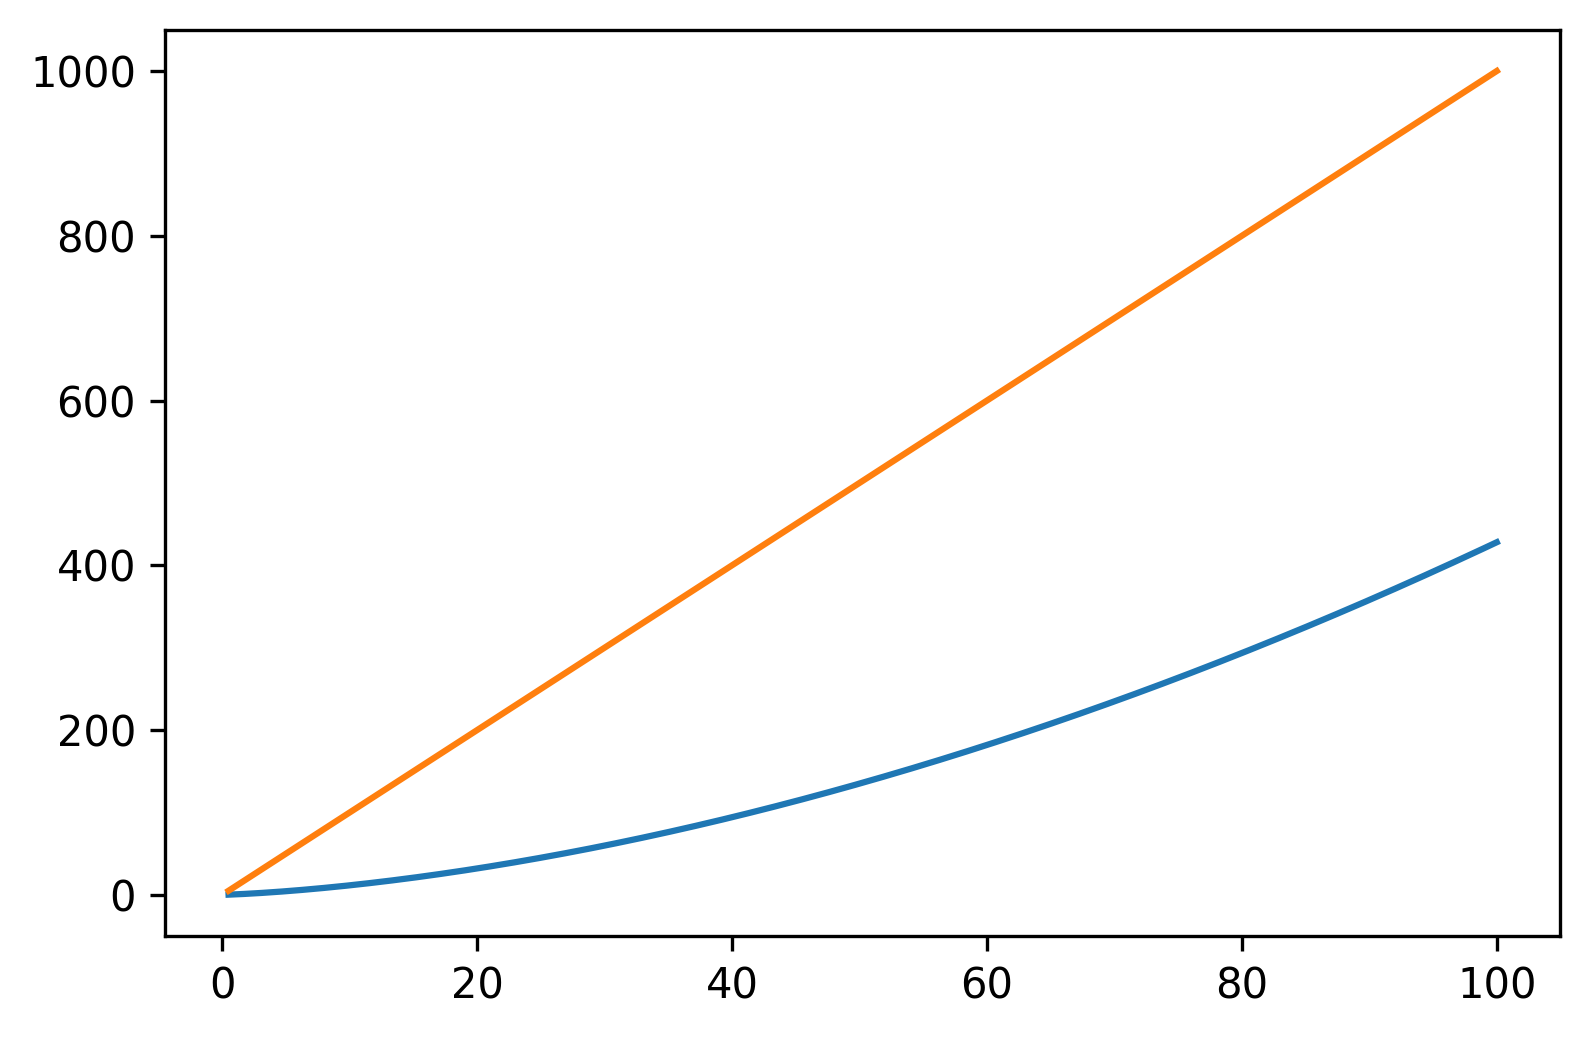

In [360]:
plt.figure()
ax = plt.axes()
#ax.scatter(m1,d)

x = np.linspace(0.5,100,num=1000)
y = ((x*0.14522845)+(x*0.3801455)**0.5)**2
y2 = x*10
plt.plot(x, y)
plt.plot(x, y2)

In [43]:
print(data.columns)
# select single run with data.loc[data["run"] == i]

selectedRun = 0

plotlyData = data.loc[data["run"] == selectedRun]
fig = px.scatter(plotlyData, x="progress", y="complexity", color=np.log10(plotlyData["loss"]), hover_data=["equation", "loss"])

# make the title for the color bar show up even if it is logarithmic
# and fix the stupid color bar which gets broken
fig.update_layout(coloraxis_colorbar = dict(
    title="loss",
    tickvals=[1,2,3],
    ticktext=["10", "100", "1000"]
))

maxScore = data.loc[data["score"] == max(data["score"])]
print(maxScore["equation"])

"""
thisBest = bestExpressions[selectedRun]
print(thisBest)
thisBestRow = data.loc[data["equation"] == thisBest]
print(thisBestRow)

fig.add_trace(
    go.Scatter(
        x=thisBestRow["progress"],
        y=thisBestRow["complexity"],
        mode="markers",
        marker = dict(
            color="Green",
            size=70
        )
    )
)
"""

fig.show()

Index(['Unnamed: 0', 'run', 'progress', 'complexity', 'loss', 'score',
       'equation'],
      dtype='object')
73      ((p / (p - -3.9763644)) - -0.64377856)
80      ((p / (p - -3.9763644)) - -0.64377856)
87      ((p / (p - -3.9763644)) - -0.64377856)
94      ((p / (p - -3.9763644)) - -0.64377856)
101     ((p / (p - -3.9763644)) - -0.64377856)
                         ...                  
1361    ((p / (p - -3.9763644)) - -0.64377856)
1368    ((p / (p - -3.9763644)) - -0.64377856)
1375    ((p / (p - -3.9763644)) - -0.64377856)
1382    ((p / (p - -3.9763644)) - -0.64377856)
1389    ((p / (p - -3.9763644)) - -0.64377856)
Name: equation, Length: 189, dtype: object
